In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **DATA PREPARATION**

In [3]:
# Read the data and import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as random
import statsmodels.api as sm
import statsmodels.tsa as tsa
import statsmodels.formula.api as smf
consumer_data = pd.read_csv("/content/gdrive/MyDrive/E-Commerce Capstone Dataset/ConsumerElectronics.csv")
climate_2015 = pd.read_excel("/content/gdrive/MyDrive/E-Commerce Capstone Dataset/ONTARIO-2015.xlsx", skiprows=24)
climate_2016 = pd.read_excel("/content/gdrive/MyDrive/E-Commerce Capstone Dataset/ONTARIO-2016.xlsx", skiprows=24)
nps_data = pd.read_excel("/content/gdrive/MyDrive/E-Commerce Capstone Dataset/Media data and other information.xlsx", sheet_name='Monthly NPS Score')
media_investment = pd.read_excel("/content/gdrive/MyDrive/E-Commerce Capstone Dataset/Media data and other information.xlsx", sheet_name='Media Investment',skiprows=2, skipfooter=4)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
consumer_data.head(5)

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400,1,\N,\N,COD,5,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,\N,\N,COD,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990,1,\N,\N,COD,10,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,\N,\N,Prepaid,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618,1,\N,\N,Prepaid,6,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [5]:
consumer_data.columns

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'deliverybdays', 'deliverycdays',
       's1_fact.order_payment_type', 'sla', 'cust_id', 'pincode',
       'product_analytic_super_category', 'product_analytic_category',
       'product_analytic_sub_category', 'product_analytic_vertical',
       'product_mrp', 'product_procurement_sla'],
      dtype='object')

In [6]:
consumer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   fsn_id                           1648824 non-null  object 
 1   order_date                       1648824 non-null  object 
 2   Year                             1648824 non-null  int64  
 3   Month                            1648824 non-null  int64  
 4   order_id                         1648824 non-null  float64
 5   order_item_id                    1648824 non-null  float64
 6   gmv                              1648824 non-null  object 
 7   units                            1648824 non-null  int64  
 8   deliverybdays                    1648824 non-null  object 
 9   deliverycdays                    1648824 non-null  object 
 10  s1_fact.order_payment_type       1648824 non-null  object 
 11  sla                              1648824 non-null 

#### We need to work in the period from July 2015 to June 2016.We can remove rows corresponding to any other dates from the order_date column

In [7]:
len(consumer_data)

1648824

In [8]:
consumer_data = consumer_data.loc[(consumer_data.order_date >= '2015-07-01')]
consumer_data = consumer_data.loc[(consumer_data.order_date < '2016-07-01')]

In [9]:
len(consumer_data)

1648215

In [10]:
## Replacing blank spaces and missing values with NaN 
consumer_data.replace(r'^\s+$', np.nan, regex=True, inplace = True)
consumer_data.replace('\\N', np.nan, inplace = True)

In [11]:
#Checking null percentage of each column
round(100*(consumer_data.isnull().sum()/len(consumer_data.index)),2)

fsn_id                              0.00
order_date                          0.00
Year                                0.00
Month                               0.00
order_id                            0.00
order_item_id                       0.00
gmv                                 0.30
units                               0.00
deliverybdays                      79.65
deliverycdays                      79.65
s1_fact.order_payment_type          0.00
sla                                 0.00
cust_id                             0.30
pincode                             0.30
product_analytic_super_category     0.00
product_analytic_category           0.00
product_analytic_sub_category       0.00
product_analytic_vertical           0.35
product_mrp                         0.00
product_procurement_sla             0.00
dtype: float64

##### `There are null values in the data that need treatment`

In [12]:
# Start with the column gmv, having 0.3% null values
consumer_data = consumer_data[consumer_data['gmv'].notna()]

In [13]:
#Checking null percentage of each column again
round(100*(consumer_data.isnull().sum()/len(consumer_data.index)),2)

fsn_id                              0.00
order_date                          0.00
Year                                0.00
Month                               0.00
order_id                            0.00
order_item_id                       0.00
gmv                                 0.00
units                               0.00
deliverybdays                      79.59
deliverycdays                      79.59
s1_fact.order_payment_type          0.00
sla                                 0.00
cust_id                             0.00
pincode                             0.00
product_analytic_super_category     0.00
product_analytic_category           0.00
product_analytic_sub_category       0.00
product_analytic_vertical           0.35
product_mrp                         0.00
product_procurement_sla             0.00
dtype: float64

In [14]:
# Remove nulls from product_analytic_vertical column
consumer_data = consumer_data[consumer_data['product_analytic_vertical'].notna()]

In [15]:
#Checking null percentage of each column again
round(100*(consumer_data.isnull().sum()/len(consumer_data.index)),2)

fsn_id                              0.00
order_date                          0.00
Year                                0.00
Month                               0.00
order_id                            0.00
order_item_id                       0.00
gmv                                 0.00
units                               0.00
deliverybdays                      79.59
deliverycdays                      79.59
s1_fact.order_payment_type          0.00
sla                                 0.00
cust_id                             0.00
pincode                             0.00
product_analytic_super_category     0.00
product_analytic_category           0.00
product_analytic_sub_category       0.00
product_analytic_vertical           0.00
product_mrp                         0.00
product_procurement_sla             0.00
dtype: float64

#### We can drop the columns 'deliverybdays' and 'deliverycdays' as they have around 80% missing values

In [16]:
consumer_data.drop(['deliverybdays','deliverycdays'],1, inplace= True)

#### Since we have to create the models for only three product sub-categories, it is better to keep only those in our data to reduce computation time

In [17]:
consumer_data = consumer_data.loc[(consumer_data.product_analytic_sub_category=='CameraAccessory') |
                       (consumer_data.product_analytic_sub_category=='HomeAudio')|
                       (consumer_data.product_analytic_sub_category=='GamingAccessory')]

In [18]:
consumer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564395 entries, 0 to 1647205
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   fsn_id                           564395 non-null  object 
 1   order_date                       564395 non-null  object 
 2   Year                             564395 non-null  int64  
 3   Month                            564395 non-null  int64  
 4   order_id                         564395 non-null  float64
 5   order_item_id                    564395 non-null  float64
 6   gmv                              564395 non-null  object 
 7   units                            564395 non-null  int64  
 8   s1_fact.order_payment_type       564395 non-null  object 
 9   sla                              564395 non-null  int64  
 10  cust_id                          564395 non-null  object 
 11  pincode                          564395 non-null  object 
 12  p

#### We can see that the data type of some of the variables are not proper here. Hence we convert them to their actual data types here

In [19]:
consumer_data['gmv'] = pd.to_numeric(consumer_data['gmv'])
consumer_data['order_date'] = pd.to_datetime(consumer_data['order_date'])
consumer_data['pincode'] = pd.to_numeric(consumer_data['pincode'])

In [20]:
len(consumer_data)

564395

In [21]:
# Drop duplicates in the data
consumer_data = consumer_data[~consumer_data.duplicated(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 's1_fact.order_payment_type', 'sla', 'cust_id',
       'pincode', 'product_analytic_super_category',
       'product_analytic_category', 'product_analytic_sub_category',
       'product_analytic_vertical', 'product_mrp', 'product_procurement_sla'])]

In [22]:
len(consumer_data)

527040

In [23]:
consumer_data.columns

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 's1_fact.order_payment_type', 'sla', 'cust_id',
       'pincode', 'product_analytic_super_category',
       'product_analytic_category', 'product_analytic_sub_category',
       'product_analytic_vertical', 'product_mrp', 'product_procurement_sla'],
      dtype='object')

#### Since we already have fsn_id, cust_id won't be of any help. We can remove it. We can also remove pincode from our data

In [24]:
consumer_data.drop(['cust_id','pincode'],1,inplace=True)

In [25]:
consumer_data.columns

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 's1_fact.order_payment_type', 'sla',
       'product_analytic_super_category', 'product_analytic_category',
       'product_analytic_sub_category', 'product_analytic_vertical',
       'product_mrp', 'product_procurement_sla'],
      dtype='object')

#### **Order_id and order_item_id cannot have a repeated combination for two different orders. Hence we should remove those rows**

In [26]:
# Drop duplicates in the data
consumer_data.duplicated(['order_id', 'order_item_id']).value_counts()

False    514068
True      12972
dtype: int64

##### There are 12,972 such rows with repeated combination of order_id and order_item_id

In [27]:
consumer_data = consumer_data[~consumer_data.duplicated(['order_id', 'order_item_id'])]

In [28]:
len(consumer_data)

514068

In [29]:
# Checking in the column 'units' for any discrepancy
consumer_data.units.value_counts()

1     504732
2       7768
3        877
4        303
5        194
6         67
10        62
8         24
7         17
9         10
12         3
15         3
18         2
13         1
34         1
16         1
17         1
20         1
39         1
Name: units, dtype: int64

#### There are no rows with zero units ordered, so this column is fine

In [30]:
## Checking in the column 's1_fact.order_payment_type'
consumer_data['s1_fact.order_payment_type'].value_counts(normalize=True)

COD        0.733391
Prepaid    0.266609
Name: s1_fact.order_payment_type, dtype: float64

#### This column also looks good with no null values or discrepant values and revealing the majority orders have been COD's.

In [31]:
## Checking in the column 'sla'
consumer_data['sla'].value_counts(normalize=True)

6     0.163934
5     0.161617
4     0.131214
7     0.128765
3     0.095059
8     0.091994
9     0.056800
2     0.044659
1     0.035984
10    0.034371
11    0.021637
12    0.012885
13    0.007946
14    0.004334
15    0.002437
0     0.002358
16    0.001484
17    0.000893
18    0.000552
19    0.000303
20    0.000169
21    0.000132
25    0.000093
24    0.000080
22    0.000076
23    0.000074
30    0.000037
26    0.000035
27    0.000025
29    0.000018
28    0.000010
39    0.000004
31    0.000004
41    0.000004
35    0.000004
42    0.000002
37    0.000002
32    0.000002
60    0.000002
Name: sla, dtype: float64

In [32]:
#Checking super-categories
consumer_data.product_analytic_super_category.unique()

array(['CE'], dtype=object)

#### We can remove the column super-categories as it has only one value

In [33]:
consumer_data.drop('product_analytic_super_category',1, inplace = True)

In [34]:
#Checking categories
consumer_data.product_analytic_category.unique()

array(['CameraAccessory', 'GamingHardware', 'EntertainmentSmall'],
      dtype=object)

In [35]:
#Checking sub categories
consumer_data.product_analytic_sub_category.unique()

array(['CameraAccessory', 'GamingAccessory', 'HomeAudio'], dtype=object)

#### Since we have removed all other sub-categories that are not relevant for our analysis before, we are left with these three to work with

In [36]:
#Checking sub categories
consumer_data.product_analytic_vertical.unique()

array(['CameraTripod', 'Lens', 'CameraBag', 'Flash', 'CameraBattery',
       'CameraBatteryCharger', 'GamePad', 'GamingAccessoryKit',
       'GamingHeadset', 'GamingMemoryCard', 'MotionController',
       'GamingMouse', 'GamingAdapter', 'TVOutCableAccessory', 'GamingGun',
       'JoystickGamingWheel', 'HomeAudioSpeaker', 'CameraRemoteControl',
       'Binoculars', 'Filter', 'GamingMousePad', 'Strap',
       'GamingKeyboard', 'Dock', 'SlingBox', 'GamingSpeaker',
       'CoolingPad', 'BoomBox', 'CameraBatteryGrip', 'CameraAccessory',
       'CameraFilmRolls', 'CameraMount', 'DockingStation', 'DJController',
       'ExtensionTube', 'FMRadio', 'HiFiSystem', 'KaraokePlayer',
       'Telescope', 'VoiceRecorder', 'GamingChargingStation',
       'CameraEyeCup', 'GameControlMount', 'SoundMixer', 'CameraLEDLight',
       'CameraMicrophone', 'FlashShoeAdapter', 'Softbox',
       'ReflectorUmbrella', 'Teleconverter', 'CameraHousing'],
      dtype=object)

In [37]:
# Checking the column 'product_mrp'
len(consumer_data[(consumer_data.product_mrp==0)])

3079

#### There cannot be zero MRP values, hence these rows need to be removed

In [38]:
consumer_data = consumer_data.loc[~(consumer_data.product_mrp==0)]

#### There are some rows where gmv is more than mrp, which is not possible logically. We could remove those rows which would in turn lead to further loss of data, so we will cap those mrp's at GMV per unit

In [39]:
# GMV per unit
consumer_data['gmv_per_unit'] = consumer_data.gmv/consumer_data.units

In [40]:
# No.of records in which gmv_per_unit is more than product_mrp
len(consumer_data['product_mrp'].loc[consumer_data.gmv_per_unit>consumer_data.product_mrp])

12442

In [41]:
len(consumer_data)

510989

In [42]:
consumer_data['product_mrp'].loc[consumer_data.gmv_per_unit>consumer_data.product_mrp]= consumer_data['gmv_per_unit']

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [43]:
consumer_data.drop(['gmv_per_unit'],1,inplace=True)

# **OUTLIER TREATMENT**

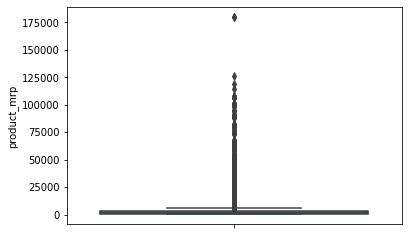

In [44]:
#Column 'product_mrp'
sns.boxplot(y = consumer_data['product_mrp'])

In [45]:
# Checking the distribution 
consumer_data['product_mrp'].describe()

count    510989.000000
mean       2501.566955
std        4700.410465
min          79.000000
25%         766.000000
50%        1200.000000
75%        2800.000000
max      180000.000000
Name: product_mrp, dtype: float64

In [46]:
# Using the IQR to remove the outliers
q = consumer_data['product_mrp'].quantile(0.99)
q1 = consumer_data['product_mrp'].quantile(0.25)
q3 = consumer_data['product_mrp'].quantile(0.75)
iqr = q3-q1
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
consumer_data = consumer_data.loc[(consumer_data['product_mrp'] > fence_low) & (consumer_data['product_mrp'] < fence_high)]

In [47]:
# Checking the distribution again
consumer_data['product_mrp'].describe()

count    468618.000000
mean       1608.034760
std        1311.547202
min          79.000000
25%         699.000000
50%        1070.000000
75%        1999.000000
max        5850.000000
Name: product_mrp, dtype: float64

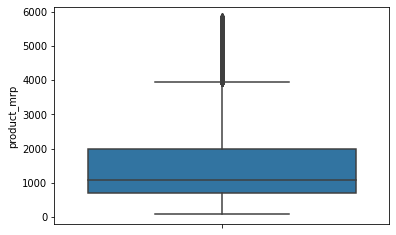

In [48]:
sns.boxplot(y = consumer_data['product_mrp'])

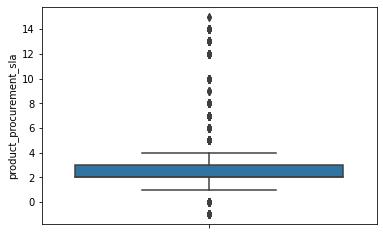

In [49]:
# Checking the column 'product_procurement_sla'
sns.boxplot(y = consumer_data['product_procurement_sla'])

#### There seems to be outliers in this column. We need to treat those

In [50]:
# Checking the distribution 
consumer_data['product_procurement_sla'].describe()

count    468618.000000
mean          2.443948
std           1.518481
min          -1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          15.000000
Name: product_procurement_sla, dtype: float64

#### No.of days to procure a product can't be negative, so we need to convert all those negative values into positives

In [51]:
consumer_data.product_procurement_sla = abs(consumer_data.product_procurement_sla)

In [52]:
# Using IQR to remove outliers
q1 = consumer_data['product_procurement_sla'].quantile(0.25)
q3 = consumer_data['product_procurement_sla'].quantile(0.75)
iqr = q3-q1
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
consumer_data = consumer_data.loc[(consumer_data['product_procurement_sla'] > fence_low) & (consumer_data['product_procurement_sla'] < fence_high)]

In [53]:
consumer_data['product_procurement_sla'].describe()

count    392973.000000
mean          2.091543
std           0.859300
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: product_procurement_sla, dtype: float64

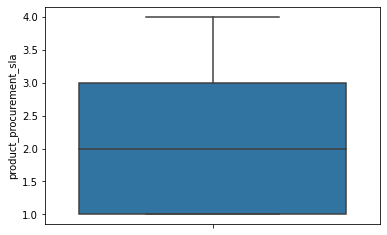

In [54]:
# Checking the column 'product_procurement_sla'
sns.boxplot(y = consumer_data['product_procurement_sla'])

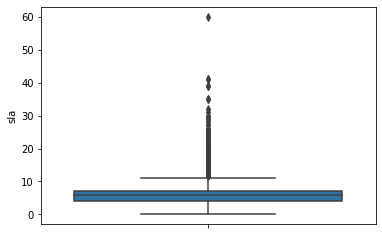

In [55]:
# Checking the column 'sla'
sns.boxplot(y = consumer_data['sla'])

In [56]:
# Checking the distribution 
consumer_data['sla'].describe()

count    392973.000000
mean          6.020778
std           2.622111
min           0.000000
25%           4.000000
50%           6.000000
75%           7.000000
max          60.000000
Name: sla, dtype: float64

In [57]:
# Using IQR to remove outliers
q1 = consumer_data['sla'].quantile(0.25)
q3 = consumer_data['sla'].quantile(0.75)
iqr = q3-q1
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
consumer_data = consumer_data.loc[(consumer_data['sla'] > fence_low) & (consumer_data['sla'] < fence_high)]

In [58]:
consumer_data['sla'].describe()

count    380337.000000
mean          5.774016
std           2.252434
min           0.000000
25%           4.000000
50%           6.000000
75%           7.000000
max          11.000000
Name: sla, dtype: float64

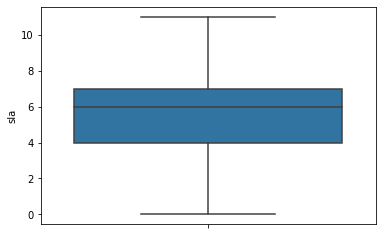

In [59]:
# Checking the column 'sla'
sns.boxplot(y = consumer_data['sla'])

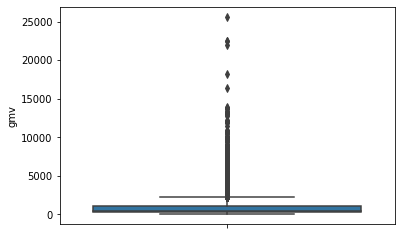

In [60]:
# Checking the column 'gmv'
sns.boxplot(y = consumer_data['gmv'])

In [61]:
consumer_data['gmv'].describe()

count    380337.000000
mean        822.260662
std         843.895779
min           0.000000
25%         278.000000
50%         468.000000
75%        1045.000000
max       25626.000000
Name: gmv, dtype: float64

In [62]:
# Using IQR to remove outliers
q1 = consumer_data['gmv'].quantile(0.25)
q3 = consumer_data['gmv'].quantile(0.75)
iqr = q3-q1
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
consumer_data = consumer_data.loc[(consumer_data['gmv'] > fence_low) & (consumer_data['gmv'] < fence_high)]

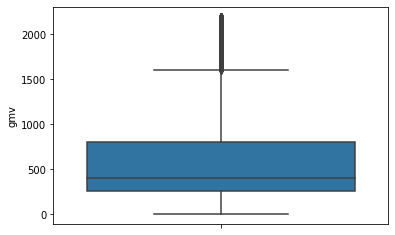

In [63]:
# Checking the column 'gmv'
sns.boxplot(y = consumer_data['gmv'])

## **FEATURE ENGINEERING**

## **Introducing New KPI's**

#### Genrating 'Week' from the 'order_date' column

In [64]:
# Creating separate 'Date' column
consumer_data['Date'] = pd.to_datetime(consumer_data['order_date'], format='%Y%m%d').dt.date

In [65]:
consumer_data['Date'] = pd.to_datetime(consumer_data['Date'])

In [66]:
# Creating 'Week' column and taking care of the fact that January,2016 should start from week 27
consumer_data['Week'] = np.where(consumer_data.Date.dt.year == 2015, (consumer_data.Date.dt.week - pd.to_datetime('2015-07-01').week + 1), consumer_data.Date.dt.week+27)
consumer_data.Week.values[(consumer_data.Date.dt.year == 2016) & (consumer_data.Week == 80)] = 27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [67]:
# Dropping the 53rd week starting from 27th June as we won't have the nps and media_investment data from that period and it is not a problem to lose 4 days of data
consumer_data = consumer_data[consumer_data.Week != 53]

In [68]:
consumer_data.head(5)

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Date,Week
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,COD,10,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-20,17
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,Prepaid,4,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-14,16
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,Prepaid,6,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-17,16
577,ACCCX3SH73WUYMEF,2015-10-13 06:39:17,2015,10,3.415534e+15,3.415534e+15,1100.0,1,Prepaid,5,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-13,16
578,ACCCX3SH73WUYMEF,2015-10-17 10:35:29,2015,10,3.419135e+15,3.419135e+15,1425.0,1,COD,3,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-17,16


## Price KPI and Discount KPI

In [69]:
#List Price
consumer_data['list_price'] = round(consumer_data['gmv']/consumer_data['units'],2)

In [70]:
# Discount Rate
consumer_data['discount'] = round(100*((consumer_data['product_mrp'] - consumer_data['list_price'])/(consumer_data['product_mrp'])),2)

In [71]:
#Order Value
consumer_data['Order_value'] = round(consumer_data['units']*consumer_data['product_mrp'],2)

***If mrp is more than 90 percentile, premium, otherwise, it is non-premium***

In [72]:
#New column on the mrp. If mrp is more than 90 percentile, premium, otherwise, it is non-premium
consumer_data['product_mrp'].quantile(.9)

2499.0

In [73]:
# Premium or Non-premium product
consumer_data['premium_product'] = consumer_data['product_mrp'].apply(lambda x:'premium' if x >= 2499 else 'non-premium')
consumer_data.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Date,Week,list_price,discount,Order_value,premium_product
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,COD,10,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-20,17,1990.0,5.19,2099.0,non-premium
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,Prepaid,4,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-14,16,1690.0,19.49,2099.0,non-premium
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,Prepaid,6,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-17,16,1618.0,22.92,2099.0,non-premium
577,ACCCX3SH73WUYMEF,2015-10-13 06:39:17,2015,10,3.415534e+15,3.415534e+15,1100.0,1,Prepaid,5,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-13,16,1100.0,44.97,1999.0,non-premium
578,ACCCX3SH73WUYMEF,2015-10-17 10:35:29,2015,10,3.419135e+15,3.419135e+15,1425.0,1,COD,3,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-17,16,1425.0,28.71,1999.0,non-premium


**PAY DATE**

In [74]:
# Extracting Day from Date column
consumer_data['Day'] = pd.to_datetime(consumer_data['Date'], format='%Y-%m-%d').dt.day

In [75]:
# Labelling the 1st and 15th of the month as pay date
consumer_data['Pay_day'] = ((consumer_data['Day'] ==1) | (consumer_data['Day'] ==15))

In [76]:
consumer_data.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Date,Week,list_price,discount,Order_value,premium_product,Day,Pay_day
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,COD,10,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-20,17,1990.0,5.19,2099.0,non-premium,20,False
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,Prepaid,4,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-14,16,1690.0,19.49,2099.0,non-premium,14,False
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,Prepaid,6,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-17,16,1618.0,22.92,2099.0,non-premium,17,False
577,ACCCX3SH73WUYMEF,2015-10-13 06:39:17,2015,10,3.415534e+15,3.415534e+15,1100.0,1,Prepaid,5,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-13,16,1100.0,44.97,1999.0,non-premium,13,False
578,ACCCX3SH73WUYMEF,2015-10-17 10:35:29,2015,10,3.419135e+15,3.419135e+15,1425.0,1,COD,3,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-17,16,1425.0,28.71,1999.0,non-premium,17,False


**HOLIDAY**

In [77]:
# Creating a binary column to see whether an order is placed on special sale day and holiday
holiday_list = ["2015-07-18","2015-07-19","2015-08-15","2015-08-16",
                                                                             "2015-08-17","2015-08-28","2015-08-29","2015-08-30",
                                                                             "2015-10-15","2015-10-16","2015-10-17","2015-11-07",
                                                                             "2015-11-08","2015-11-09","2015-11-10","2015-11-11",
                                                                             "2015-11-12","2015-11-13","2015-11-14","2015-12-25",
                                                                             "2015-12-26","2015-12-27","2015-12-28","2015-12-29",
                                                                             "2015-12-30","2015-12-31","2016-01-01","2016-01-02",
                                                                             "2016-01-03","2016-01-20","2016-01-21","2016-01-22",
                                                                             "2016-02-01","2016-02-02","2016-02-14","2016-02-15",
                                                                             "2016-02-20","2016-02-21","2016-03-07","2016-03-08",
                                                                             "2016-03-09","2016-05-25","2016-05-26","2016-05-27"]

holiday_list = pd.DataFrame(holiday_list,columns = ['Holiday_Date'])
holiday_list['Date'] = pd.to_datetime(holiday_list['Holiday_Date'])
holiday_list

consumer_data = consumer_data.merge(holiday_list, 'left')
consumer_data.fillna(0, inplace=True)
consumer_data

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Date,Week,list_price,discount,Order_value,premium_product,Day,Pay_day,Holiday_Date
0,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,COD,10,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-20,17,1990.0,5.19,2099.0,non-premium,20,False,0
1,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,Prepaid,4,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-14,16,1690.0,19.49,2099.0,non-premium,14,False,0
2,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,Prepaid,6,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-17,16,1618.0,22.92,2099.0,non-premium,17,False,2015-10-17
3,ACCCX3SH73WUYMEF,2015-10-13 06:39:17,2015,10,3.415534e+15,3.415534e+15,1100.0,1,Prepaid,5,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-13,16,1100.0,44.97,1999.0,non-premium,13,False,0
4,ACCCX3SH73WUYMEF,2015-10-17 10:35:29,2015,10,3.419135e+15,3.419135e+15,1425.0,1,COD,3,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-17,16,1425.0,28.71,1999.0,non-premium,17,False,2015-10-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343426,VOREAZ3EZSVXZWSQ,2015-09-19 19:10:55,2015,9,3.395252e+15,3.395252e+15,1299.0,1,COD,5,EntertainmentSmall,HomeAudio,VoiceRecorder,2499.0,2,2015-09-19,12,1299.0,48.02,2499.0,premium,19,False,0
343427,VOREAZ3EZSVXZWSQ,2015-09-23 17:18:25,2015,9,4.398638e+15,4.398638e+15,1299.0,1,COD,6,EntertainmentSmall,HomeAudio,VoiceRecorder,2499.0,2,2015-09-23,13,1299.0,48.02,2499.0,premium,23,False,0
343428,VOREAZ3EZSVXZWSQ,2015-09-26 12:16:12,2015,9,1.401014e+15,1.401014e+15,1299.0,1,COD,5,EntertainmentSmall,HomeAudio,VoiceRecorder,2499.0,2,2015-09-26,13,1299.0,48.02,2499.0,premium,26,False,0
343429,VOREAZ3EZSVXZWSQ,2015-09-27 16:31:05,2015,9,2.402069e+15,2.402069e+15,1299.0,1,COD,6,EntertainmentSmall,HomeAudio,VoiceRecorder,2499.0,2,2015-09-27,13,1299.0,48.02,2499.0,premium,27,False,0


In [78]:
consumer_data['is_special_saleday_holiday'] = consumer_data['Holiday_Date'].apply(lambda x:0 if x==0 else 1)

***DEALING WITH CATEGORICAL VARIABLES***

In [79]:
# Changing the column 'order payment type' to a binary column 
consumer_data['is_cod'] = consumer_data['s1_fact.order_payment_type'].apply(lambda x:1 if x=='COD' else 0)

In [80]:
# Changing the column 'premium_product' created earlier into a binary column
consumer_data['is_premium'] = consumer_data['premium_product'].apply(lambda x:1 if x=='premium' else 0)

In [81]:
consumer_data.replace({False: 0, True: 1}, inplace=True)

In [82]:
consumer_data.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Date,Week,list_price,discount,Order_value,premium_product,Day,Pay_day,Holiday_Date,is_special_saleday_holiday,is_cod,is_premium
0,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,COD,10,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-20,17,1990.0,5.19,2099.0,non-premium,20,0,0,0,1,0
1,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,Prepaid,4,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-14,16,1690.0,19.49,2099.0,non-premium,14,0,0,0,0,0
2,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,Prepaid,6,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-17,16,1618.0,22.92,2099.0,non-premium,17,0,2015-10-17,1,0,0
3,ACCCX3SH73WUYMEF,2015-10-13 06:39:17,2015,10,3.415534e+15,3.415534e+15,1100.0,1,Prepaid,5,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-13,16,1100.0,44.97,1999.0,non-premium,13,0,0,0,0,0
4,ACCCX3SH73WUYMEF,2015-10-17 10:35:29,2015,10,3.419135e+15,3.419135e+15,1425.0,1,COD,3,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-17,16,1425.0,28.71,1999.0,non-premium,17,0,2015-10-17,1,1,0


In [83]:
# Dropping the columns for which dummies were created
consumer_data.drop(['s1_fact.order_payment_type','premium_product','Holiday_Date'], axis=1, inplace=True)

**CLIMATE**

In [84]:
# Merging 2015 and 2016 climate data
climate = climate_2015.append(climate_2016)
climate.reset_index()
climate.head()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2015-01-01,2015,1,1,†,0.0,NaN,-8.5,NaN,-4.3,NaN,22.3,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,2015,1,2,†,3.0,NaN,-3.0,NaN,0.0,NaN,18.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,2015,1,3,†,2.5,NaN,-4.0,NaN,-0.8,NaN,18.8,NaN,0.0,NaN,24.0,NaN,0.0,NaN,24.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,2015,1,4,†,2.5,NaN,0.0,NaN,1.3,NaN,16.7,NaN,0.0,NaN,0.0,NaN,1.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,2015,1,5,†,-10.0,NaN,-13.5,NaN,-11.8,NaN,29.8,NaN,0.0,NaN,0.0,NaN,3.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


#### We need the climate data from July, 2015 to June, 2016. So we can delete all the remaining records

In [85]:
# July,2015 to June,2016 climate data
climate = climate.loc[(climate['Date/Time'] >= '2015-07-01')]
climate = climate.loc[(climate['Date/Time'] < '2016-07-01')]
climate.head()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
181,2015-07-01,2015,7,1,†,24.5,NaN,17.0,NaN,20.8,NaN,0.0,NaN,2.8,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
182,2015-07-02,2015,7,2,†,24.0,NaN,14.0,NaN,19.0,NaN,0.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
183,2015-07-03,2015,7,3,†,25.0,NaN,10.0,NaN,17.5,NaN,0.5,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
184,2015-07-04,2015,7,4,†,26.0,NaN,11.0,NaN,18.5,NaN,0.0,NaN,0.5,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
185,2015-07-05,2015,7,5,†,28.0,NaN,14.0,NaN,21.0,NaN,0.0,NaN,3.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [86]:
# Missing percentages in climate data variables
round(100*(climate.isnull().sum()/len(climate.index)),2)

Date/Time                      0.00
Year                           0.00
Month                          0.00
Day                            0.00
Data Quality                  41.26
Max Temp (°C)                 43.17
Max Temp Flag                 98.09
Min Temp (°C)                 47.81
Min Temp Flag                 93.44
Mean Temp (°C)                47.81
Mean Temp Flag                93.44
Heat Deg Days (°C)            47.81
Heat Deg Days Flag            93.44
Cool Deg Days (°C)            47.81
Cool Deg Days Flag            93.44
Total Rain (mm)               41.26
Total Rain Flag               98.09
Total Snow (cm)               41.26
Total Snow Flag               98.36
Total Precip (mm)             41.26
Total Precip Flag             96.99
Snow on Grnd (cm)             41.26
Snow on Grnd Flag             98.36
Dir of Max Gust (10s deg)    100.00
Dir of Max Gust Flag         100.00
Spd of Max Gust (km/h)       100.00
Spd of Max Gust Flag         100.00
dtype: float64

#### Lot of the columns in the above data seems to be irrelevant and filled with missing values. We can drop them.

In [87]:
climate.drop(['Data Quality','Max Temp Flag','Min Temp Flag','Mean Temp Flag','Heat Deg Days Flag','Cool Deg Days Flag',
              'Total Rain Flag','Total Snow Flag','Total Precip Flag','Snow on Grnd Flag','Dir of Max Gust (10s deg)','Dir of Max Gust Flag',
              'Spd of Max Gust (km/h)','Spd of Max Gust Flag'],axis=1, inplace= True)

In [88]:
# Renaming the columns for convenience
climate.columns = ['Date','Year','Month','Day','max_temp_c','min_temp_c','mean_temp_c','heat_deg_days_c','cool_deg_days_c',
                   'total_rain_mm','total_snow_cm','total_precip_mm','snow_on_grnd_cm']

In [89]:
climate['Date'] = pd.to_datetime(climate['Date'])

#### Merging Week into the Climate data

In [90]:
# Creating 'Week' column and taking care of the fact that January,2016 should start from week 27
climate['Week'] = np.where(climate.Date.dt.year == 2015, (climate.Date.dt.week - pd.to_datetime('2015-07-01').week + 1), climate.Date.dt.week+27)
climate.Week.values[(climate.Date.dt.year == 2016) & (climate.Week == 80)] = 27

climate = climate[climate.Week != 53]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [91]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 181 to 177
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             362 non-null    datetime64[ns]
 1   Year             362 non-null    int64         
 2   Month            362 non-null    int64         
 3   Day              362 non-null    int64         
 4   max_temp_c       206 non-null    float64       
 5   min_temp_c       189 non-null    float64       
 6   mean_temp_c      189 non-null    float64       
 7   heat_deg_days_c  189 non-null    float64       
 8   cool_deg_days_c  189 non-null    float64       
 9   total_rain_mm    213 non-null    float64       
 10  total_snow_cm    213 non-null    float64       
 11  total_precip_mm  213 non-null    float64       
 12  snow_on_grnd_cm  213 non-null    float64       
 13  Week             362 non-null    int64         
dtypes: datetime64[ns](1), float64(9), int64(

In [92]:
# Reset index and drop the index
climate = climate.reset_index()
climate.drop('index',axis=1,inplace=True)

**Remaining Missing values in Climate**

There are still lots of missing values in the climate dataset. We will impute them with their mean values because in terms of weather measurements, average seems to be the ideal measure as we identify normal temperature as the average of temperatures on a date for a certain number of years.

In [93]:
#Imputing columns in climate missing values by their means
column_with_nan = climate.columns[climate.isnull().any()]
for column in column_with_nan:
  climate[column] = climate[column].fillna(climate[column].mean()) 

In [94]:
round(100*(climate.isnull().sum()/len(climate.index)),2)

Date               0.0
Year               0.0
Month              0.0
Day                0.0
max_temp_c         0.0
min_temp_c         0.0
mean_temp_c        0.0
heat_deg_days_c    0.0
cool_deg_days_c    0.0
total_rain_mm      0.0
total_snow_cm      0.0
total_precip_mm    0.0
snow_on_grnd_cm    0.0
Week               0.0
dtype: float64

In [95]:
# Grouping by week and taking the mean of the climatic conditions
climate = pd.DataFrame(climate.groupby(['Week'])['max_temp_c','min_temp_c','mean_temp_c','heat_deg_days_c','cool_deg_days_c',
                   'total_rain_mm','total_snow_cm','total_precip_mm','snow_on_grnd_cm'].mean())
climate.reset_index(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
climate.head()

,Week,max_temp_c,min_temp_c,mean_temp_c,heat_deg_days_c,cool_deg_days_c,total_rain_mm,total_snow_cm,total_precip_mm,snow_on_grnd_cm
0,1,25.500000,13.200000,19.360000,0.100000,1.460000,0.000000,0.00000,0.000000,0.000000
1,2,24.007282,14.373394,19.247695,1.067498,2.315193,4.156942,0.02951,4.186452,0.041583
2,3,27.364424,16.301965,21.890552,0.824641,4.715193,1.571227,0.02951,1.600738,0.041583
3,4,28.221567,14.318216,20.509675,1.649282,4.158957,1.142656,0.02951,1.172166,0.041583
4,5,29.792996,16.230537,23.076266,0.824641,5.900907,4.342656,0.02951,4.372166,0.041583


# **NPS Score Data**

In [97]:
nps_data

,Unnamed: 0,July'15,Aug'15,Sept'15,Oct'15,Nov'15,Dec'15,Jan'16,Feb'16,Mar'16,Apr'16,May'16,June'16
0,NPS,54.599588,59.987101,46.925419,44.398389,47.0,45.8,47.093031,50.327406,49.02055,51.827605,47.306951,50.516687
1,Stock Index,1177.000000,1206.000000,1101.000000,1210.000000,1233.0,1038.0,1052.000000,1222.000000,1015.00000,1242.000000,1228.000000,1194.000000


Bringing the NPS data into the correct format by resetting the index and transposing the data and again resetting the index 

In [98]:
nps_data.reset_index(drop=True, inplace=True)
nps_data

,Unnamed: 0,July'15,Aug'15,Sept'15,Oct'15,Nov'15,Dec'15,Jan'16,Feb'16,Mar'16,Apr'16,May'16,June'16
0,NPS,54.599588,59.987101,46.925419,44.398389,47.0,45.8,47.093031,50.327406,49.02055,51.827605,47.306951,50.516687
1,Stock Index,1177.000000,1206.000000,1101.000000,1210.000000,1233.0,1038.0,1052.000000,1222.000000,1015.00000,1242.000000,1228.000000,1194.000000


In [99]:
# Transposing the data
nps_data = nps_data.T
nps_data.reset_index(drop=False, inplace=True)
nps_data

,index,0,1
0,Unnamed: 0,NPS,Stock Index
1,July'15,54.5996,1177
2,Aug'15,59.9871,1206
3,Sept'15,46.9254,1101
4,Oct'15,44.3984,1210
5,Nov'15,47,1233
6,Dec'15,45.8,1038
7,Jan'16,47.093,1052
8,Feb'16,50.3274,1222
9,Mar'16,49.0206,1015


In [100]:
# Renaming the columns and dropping the first index
nps_data.columns = ['Month','NPS','Stock Index']
nps_data = nps_data.drop(nps_data.index[0]).reset_index(drop=True)
nps_data

,Month,NPS,Stock Index
0,July'15,54.5996,1177
1,Aug'15,59.9871,1206
2,Sept'15,46.9254,1101
3,Oct'15,44.3984,1210
4,Nov'15,47,1233
5,Dec'15,45.8,1038
6,Jan'16,47.093,1052
7,Feb'16,50.3274,1222
8,Mar'16,49.0206,1015
9,Apr'16,51.8276,1242


In [101]:
# Drop the month column and add month and year separately for avoiding complex coding
nps_data.drop(['Month'], axis=1, inplace=True)
nps_data['Month'] = pd.Series([7,8,9,10,11,12,1,2,3,4,5,6])
nps_data['Year'] = pd.Series([2015,2015,2015,2015,2015,2015,2016,2016,2016,2016,2016,2016])
nps_data.head()

,NPS,Stock Index,Month,Year
0,54.5996,1177,7,2015
1,59.9871,1206,8,2015
2,46.9254,1101,9,2015
3,44.3984,1210,10,2015
4,47,1233,11,2015


In [102]:
# Adding dates to the nps data 
Date = ['2015-07-01','2015-08-01','2015-09-01','2015-10-01','2015-11-01','2015-12-01','2016-01-01','2016-02-01','2016-03-01','2016-04-01','2016-05-01','2016-06-01']
nps_data['Date'] = Date
nps_data

,NPS,Stock Index,Month,Year,Date
0,54.5996,1177,7,2015,2015-07-01
1,59.9871,1206,8,2015,2015-08-01
2,46.9254,1101,9,2015,2015-09-01
3,44.3984,1210,10,2015,2015-10-01
4,47,1233,11,2015,2015-11-01
5,45.8,1038,12,2015,2015-12-01
6,47.093,1052,1,2016,2016-01-01
7,50.3274,1222,2,2016,2016-02-01
8,49.0206,1015,3,2016,2016-03-01
9,51.8276,1242,4,2016,2016-04-01


In [103]:
# Setting Date as the index
nps_data.set_index('Date', inplace = True)
nps_data.head()

,NPS,Stock Index,Month,Year
Date,,,,
2015-07-01,54.5996,1177,7,2015
2015-08-01,59.9871,1206,8,2015
2015-09-01,46.9254,1101,9,2015
2015-10-01,44.3984,1210,10,2015
2015-11-01,47,1233,11,2015


In [104]:
# Resampling weekly
nps_data.index = pd.to_datetime(nps_data.index)

ix = nps_data.index[-1] + pd.offsets.MonthBegin(1)
ix

nps_data = nps_data.append(nps_data.iloc[[-1]].rename({nps_data.index[-1]: ix}))
nps_data

,NPS,Stock Index,Month,Year
Date,,,,
2015-07-01,54.5996,1177,7,2015
2015-08-01,59.9871,1206,8,2015
2015-09-01,46.9254,1101,9,2015
2015-10-01,44.3984,1210,10,2015
2015-11-01,47,1233,11,2015
2015-12-01,45.8,1038,12,2015
2016-01-01,47.093,1052,1,2016
2016-02-01,50.3274,1222,2,2016
2016-03-01,49.0206,1015,3,2016


In [105]:
nps_data = nps_data.resample('W').ffill().iloc[:-1]
nps_data

,NPS,Stock Index,Month,Year
Date,,,,
2015-07-05,54.5996,1177,7,2015
2015-07-12,54.5996,1177,7,2015
2015-07-19,54.5996,1177,7,2015
2015-07-26,54.5996,1177,7,2015
2015-08-02,59.9871,1206,8,2015
2015-08-09,59.9871,1206,8,2015
2015-08-16,59.9871,1206,8,2015
2015-08-23,59.9871,1206,8,2015
2015-08-30,59.9871,1206,8,2015


In [106]:
nps_data.reset_index(inplace = True)
nps_data['Date'] = pd.to_datetime(nps_data['Date'])
nps_data

,Date,NPS,Stock Index,Month,Year
0,2015-07-05,54.5996,1177,7,2015
1,2015-07-12,54.5996,1177,7,2015
2,2015-07-19,54.5996,1177,7,2015
3,2015-07-26,54.5996,1177,7,2015
4,2015-08-02,59.9871,1206,8,2015
5,2015-08-09,59.9871,1206,8,2015
6,2015-08-16,59.9871,1206,8,2015
7,2015-08-23,59.9871,1206,8,2015
8,2015-08-30,59.9871,1206,8,2015
9,2015-09-06,46.9254,1101,9,2015


In [107]:
# Creating 'Week' column and taking care of the fact that January,2016 should start from week 27
nps_data['Week'] = np.where(nps_data.Date.dt.year == 2015, (nps_data.Date.dt.week - pd.to_datetime('2015-07-01').week + 1), nps_data.Date.dt.week+27)
nps_data.Week.values[(nps_data.Date.dt.year == 2016) & (nps_data.Week == 80)] = 27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [108]:
nps_data.head()

,Date,NPS,Stock Index,Month,Year,Week
0,2015-07-05,54.5996,1177,7,2015,1
1,2015-07-12,54.5996,1177,7,2015,2
2,2015-07-19,54.5996,1177,7,2015,3
3,2015-07-26,54.5996,1177,7,2015,4
4,2015-08-02,59.9871,1206,8,2015,5


In [109]:
# Setting index as 'Week' and dropping irrelevant columns
nps_data.set_index('Week',inplace = True)
nps_data.drop(['Date','Month','Year'], axis=1, inplace=True)
nps_data

,NPS,Stock Index
Week,,
1,54.5996,1177
2,54.5996,1177
3,54.5996,1177
4,54.5996,1177
5,59.9871,1206
6,59.9871,1206
7,59.9871,1206
8,59.9871,1206
9,59.9871,1206


In [110]:
# Resetting index and seeing the nps final data
nps_data.reset_index(inplace = True)
nps_data.head()

,Week,NPS,Stock Index
0,1,54.5996,1177
1,2,54.5996,1177
2,3,54.5996,1177
3,4,54.5996,1177
4,5,59.9871,1206


In [111]:
nps_data

,Week,NPS,Stock Index
0,1,54.5996,1177
1,2,54.5996,1177
2,3,54.5996,1177
3,4,54.5996,1177
4,5,59.9871,1206
5,6,59.9871,1206
6,7,59.9871,1206
7,8,59.9871,1206
8,9,59.9871,1206
9,10,46.9254,1101


So, now, we have the climate and nps-stock index data in weekly format. We will now move on to marketing data and create adstocks

##  MEDIA DATA

In [112]:
media_investment

,Unnamed: 0,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,NaN,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
1,NaN,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
2,NaN,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
3,NaN,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
4,NaN,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN
5,NaN,2015,12,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,NaN,NaN
6,NaN,2016,1,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000
7,NaN,2016,2,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,NaN,NaN
8,NaN,2016,3,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545
9,NaN,2016,4,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,NaN,NaN


In [113]:
# Dropping the irrelevant column
media_investment.drop('Unnamed: 0', axis=1, inplace =True)

In [114]:
# Replacing some missing values with 0 as missing values in this case of advertisement would mean that no advertisement has been done 
media_investment.replace(np.nan,0,inplace=True)

In [115]:
# Adding dates to the media data 
Date = ['2015-07-01','2015-08-01','2015-09-01','2015-10-01','2015-11-01','2015-12-01','2016-01-01','2016-02-01','2016-03-01','2016-04-01','2016-05-01','2016-06-01']
media_investment['Date'] = Date
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other,Date
0,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000,2015-07-01
1,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000,2015-08-01
2,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000,2015-09-01
3,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000,2015-10-01
4,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000,2015-11-01
5,2015,12,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000,2015-12-01
6,2016,1,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000,2016-01-01
7,2016,2,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000,2016-02-01
8,2016,3,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545,2016-03-01
9,2016,4,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000,2016-04-01


In [116]:
# Setting Date as the index
media_investment.set_index('Date', inplace = True)
media_investment.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
Date,,,,,,,,,,,,
2015-07-01,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.0,0.0
2015-08-01,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.0,0.0
2015-09-01,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.0,0.0
2015-10-01,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.0,0.0
2015-11-01,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.0,0.0


In [117]:
# Resampling weekly
media_investment.index = pd.to_datetime(media_investment.index)

ix = media_investment.index[-1] + pd.offsets.MonthBegin(1)
ix

media_investment = media_investment.append(media_investment.iloc[[-1]].rename({media_investment.index[-1]: ix}))

media_investment = media_investment.resample('W').ffill().iloc[:-1]
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
Date,,,,,,,,,,,,
2015-07-05,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000
2015-07-12,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000
2015-07-19,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000
2015-07-26,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000
2015-08-02,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000
2015-08-09,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000
2015-08-16,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000
2015-08-23,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000
2015-08-30,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000


In [118]:
media_investment.columns

Index(['Year', 'Month', 'Total Investment', 'TV', 'Digital', 'Sponsorship',
       'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio',
       'Other'],
      dtype='object')

In [119]:
media_investment.columns = ['Year', 'Month', 'Total_Investment', 'TV', 'Digital', 'Sponsorship',
       'Content_Marketing', 'Online_marketing', 'Affiliates', 'SEM', 'Radio',
       'Other']

In [120]:
media_investment.columns

Index(['Year', 'Month', 'Total_Investment', 'TV', 'Digital', 'Sponsorship',
       'Content_Marketing', 'Online_marketing', 'Affiliates', 'SEM', 'Radio',
       'Other'],
      dtype='object')

Now, since this is media information and we have resampled on a weekly level, we have to divide each month's numbers to an aggregate. Otherwise, it would lead to an overestimated information

In [121]:
media_investment['Total_Investment'] /= media_investment.resample('MS')['Total_Investment'].transform('size')
media_investment['TV'] /= media_investment.resample('MS')['TV'].transform('size')
media_investment['Digital'] /= media_investment.resample('MS')['Digital'].transform('size')
media_investment['Sponsorship'] /= media_investment.resample('MS')['Sponsorship'].transform('size')
media_investment['Content_Marketing'] /= media_investment.resample('MS')['Content_Marketing'].transform('size')
media_investment['Online_marketing'] /= media_investment.resample('MS')['Online_marketing'].transform('size')
media_investment['Affiliates'] /= media_investment.resample('MS')['Affiliates'].transform('size')
media_investment['SEM'] /= media_investment.resample('MS')['SEM'].transform('size')
media_investment['Radio'] /= media_investment.resample('MS')['Radio'].transform('size')
media_investment['Other'] /= media_investment.resample('MS')['Other'].transform('size')

In [122]:
# Resetting the index and changing the type of the date column
media_investment.reset_index(inplace = True)
media_investment['Date'] = pd.to_datetime(media_investment['Date'])
media_investment = pd.DataFrame(media_investment, columns= ['Date', 'Year', 'Month', 'Total_Investment', 'TV', 'Digital',
       'Sponsorship', 'Content_Marketing', 'Online_marketing', 'Affiliates',
       'SEM', 'Radio', 'Other'])
media_investment

,Date,Year,Month,Total_Investment,TV,Digital,Sponsorship,Content_Marketing,Online_marketing,Affiliates,SEM,Radio,Other
0,2015-07-05,2015,7,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0000,0.000000
1,2015-07-12,2015,7,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0000,0.000000
2,2015-07-19,2015,7,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0000,0.000000
3,2015-07-26,2015,7,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0000,0.000000
4,2015-08-02,2015,8,1.012861,0.001288,0.255615,0.212666,0.000001,0.025849,0.014737,0.502706,0.0000,0.000000
5,2015-08-09,2015,8,1.012861,0.001288,0.255615,0.212666,0.000001,0.025849,0.014737,0.502706,0.0000,0.000000
6,2015-08-16,2015,8,1.012861,0.001288,0.255615,0.212666,0.000001,0.025849,0.014737,0.502706,0.0000,0.000000
7,2015-08-23,2015,8,1.012861,0.001288,0.255615,0.212666,0.000001,0.025849,0.014737,0.502706,0.0000,0.000000
8,2015-08-30,2015,8,1.012861,0.001288,0.255615,0.212666,0.000001,0.025849,0.014737,0.502706,0.0000,0.000000
9,2015-09-06,2015,9,24.063595,0.969876,0.339132,15.696913,0.152573,4.094997,1.259567,1.550537,0.0000,0.000000


In [123]:
# Creating 'Week' column and taking care of the fact that January,2016 should start from week 27
media_investment['Week'] = np.where(media_investment.Date.dt.year == 2015, (media_investment.Date.dt.week - pd.to_datetime('2015-07-01').week + 1), media_investment.Date.dt.week+27)
media_investment.Week.values[(media_investment.Date.dt.year == 2016) & (media_investment.Week == 80)] = 27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [124]:
# Setting index as 'Week' and dropping irrelevant columns
media_investment.set_index('Week',inplace = True)
media_investment.drop(['Date','Month','Year'], axis=1, inplace=True)
media_investment.reset_index(inplace = True)
media_investment.head()

,Week,Total_Investment,TV,Digital,Sponsorship,Content_Marketing,Online_marketing,Affiliates,SEM,Radio,Other
0,1,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,2,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
2,3,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
3,4,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
4,5,1.012861,0.001288,0.255615,0.212666,0.000001,0.025849,0.014737,0.502706,0.0,0.0


## **CREATING ADSTOCKS**

In [125]:
media_investment.columns

Index(['Week', 'Total_Investment', 'TV', 'Digital', 'Sponsorship',
       'Content_Marketing', 'Online_marketing', 'Affiliates', 'SEM', 'Radio',
       'Other'],
      dtype='object')

In [126]:
# Taking adstock rate as 0.5
adstock_rate = 0.5
TV_adstock = tsa.filters.filtertools.recursive_filter(media_investment['TV'], adstock_rate)
Digital_adstock = tsa.filters.filtertools.recursive_filter(media_investment['Digital'], adstock_rate)
Sponsorship_adstock = tsa.filters.filtertools.recursive_filter(media_investment['Sponsorship'], adstock_rate)
Content_Marketing_adstock = tsa.filters.filtertools.recursive_filter(media_investment['Content_Marketing'], adstock_rate)
Online_marketing_adstock = tsa.filters.filtertools.recursive_filter(media_investment['Online_marketing'], adstock_rate)
Affiliates_adstock = tsa.filters.filtertools.recursive_filter(media_investment['Affiliates'], adstock_rate)
SEM_adstock = tsa.filters.filtertools.recursive_filter(media_investment['SEM'], adstock_rate)
Radio_adstock = tsa.filters.filtertools.recursive_filter(media_investment['Radio'], adstock_rate)
Other_adstock = tsa.filters.filtertools.recursive_filter(media_investment['Other'], adstock_rate)
media_investment = pd.concat([media_investment['Week'],media_investment['Total_Investment'], media_investment['TV'],
                              media_investment['Digital'], media_investment['Sponsorship'],
                              media_investment['Content_Marketing'], media_investment['Online_marketing'], media_investment['Affiliates'],
                              media_investment['SEM'], media_investment['Radio'], media_investment['Other'],TV_adstock,Digital_adstock,
                              Sponsorship_adstock,Content_Marketing_adstock,Online_marketing_adstock,Affiliates_adstock,SEM_adstock,
                              Radio_adstock,Other_adstock],axis=1)
media_investment.columns = ['Week', 'Total_Investment', 'TV', 'Digital', 'Sponsorship',
       'Content_Marketing', 'Online_marketing', 'Affiliates', 'SEM', 'Radio',
       'Other','TV_adstock','Digital_adstock','Sponsorship_adstock','Content_Marketing_adstock','Online_marketing_adstock',
       'Affiliates_adstock','SEM_adstock','Radio_adstock','Other_adstock']


In [127]:
media_investment.head()

,Week,Total_Investment,TV,Digital,Sponsorship,Content_Marketing,Online_marketing,Affiliates,SEM,Radio,Other,TV_adstock,Digital_adstock,Sponsorship_adstock,Content_Marketing_adstock,Online_marketing_adstock,Affiliates_adstock,SEM_adstock,Radio_adstock,Other_adstock
0,1,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,2,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0
2,3,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0
3,4,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0
4,5,1.012861,0.001288,0.255615,0.212666,0.000001,0.025849,0.014737,0.502706,0.0,0.0,0.051756,0.849290,1.950386,0.000220,0.336930,0.142999,1.680135,0.0,0.0


**CREATING SEPARATE DATAFRAMES FOR THE THREE SUB-CATEGORIES**

In [128]:
consumer_data['product_analytic_sub_category'].unique()

array(['CameraAccessory', 'GamingAccessory', 'HomeAudio'], dtype=object)

In [129]:
camera_data = consumer_data[consumer_data['product_analytic_sub_category'] == 'CameraAccessory']
gaming_data = consumer_data[consumer_data['product_analytic_sub_category'] == 'GamingAccessory']
homeaudio_data = consumer_data[consumer_data['product_analytic_sub_category'] == 'HomeAudio']

In [130]:
camera_data

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Date,Week,list_price,discount,Order_value,Day,Pay_day,is_special_saleday_holiday,is_cod,is_premium
0,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,10,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-20,17,1990.0,5.19,2099.0,20,0,0,1,0
1,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,4,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-14,16,1690.0,19.49,2099.0,14,0,0,0,0
2,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,6,CameraAccessory,CameraAccessory,CameraTripod,2099.0,3,2015-10-17,16,1618.0,22.92,2099.0,17,0,1,0,0
3,ACCCX3SH73WUYMEF,2015-10-13 06:39:17,2015,10,3.415534e+15,3.415534e+15,1100.0,1,5,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-13,16,1100.0,44.97,1999.0,13,0,0,0,0
4,ACCCX3SH73WUYMEF,2015-10-17 10:35:29,2015,10,3.419135e+15,3.419135e+15,1425.0,1,3,CameraAccessory,CameraAccessory,CameraBag,1999.0,3,2015-10-17,16,1425.0,28.71,1999.0,17,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343357,TESEAHDGZRUYWSF2,2015-09-15 20:48:07,2015,9,1.391853e+15,1.391853e+15,329.0,1,9,CameraAccessory,CameraAccessory,Telescope,340.0,2,2015-09-15,12,329.0,3.24,340.0,15,1,0,0,0
343358,TESEAHDGZRUYWSF2,2015-09-17 13:18:17,2015,9,3.393313e+15,3.000373e+17,329.0,1,6,CameraAccessory,CameraAccessory,Telescope,340.0,2,2015-09-17,12,329.0,3.24,340.0,17,0,0,1,0
343359,TESEAHDGZRUYWSF2,2015-09-25 11:43:35,2015,9,1.400166e+15,1.400166e+15,329.0,1,7,CameraAccessory,CameraAccessory,Telescope,340.0,2,2015-09-25,13,329.0,3.24,340.0,25,0,0,0,0
343360,TESEAHDGZRUYWSF2,2015-09-27 21:59:48,2015,9,2.402265e+15,2.402265e+15,329.0,1,7,CameraAccessory,CameraAccessory,Telescope,340.0,2,2015-09-27,13,329.0,3.24,340.0,27,0,0,0,0


We need to group the three dataframes by weeks

In [131]:
camera_data.columns

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'sla', 'product_analytic_category',
       'product_analytic_sub_category', 'product_analytic_vertical',
       'product_mrp', 'product_procurement_sla', 'Date', 'Week', 'list_price',
       'discount', 'Order_value', 'Day', 'Pay_day',
       'is_special_saleday_holiday', 'is_cod', 'is_premium'],
      dtype='object')

**The column product_analytic_vertical can provide us with many insights regarding the products sold under each sub category. We will do a dummy encoding for it now for the three dataframes**

In [132]:
# Creating dummies for the three dataframes
camera_dummy = pd.get_dummies(camera_data[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)
gaming_dummy = pd.get_dummies(gaming_data[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)
homeaudio_dummy = pd.get_dummies(homeaudio_data[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)

# Adding the results to the original dataframes
camera_data = pd.concat([camera_data, camera_dummy], axis=1)
gaming_data = pd.concat([gaming_data, gaming_dummy], axis=1)
homeaudio_data = pd.concat([homeaudio_data, homeaudio_dummy], axis=1)

#Dropping the 'product_analytic_vertical' from the three dataframes
camera_data = camera_data.drop('product_analytic_vertical', axis=1)
gaming_data = gaming_data.drop('product_analytic_vertical', axis=1)
homeaudio_data = homeaudio_data.drop('product_analytic_vertical', axis=1)

In [133]:
camera_data.columns

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'sla', 'product_analytic_category',
       'product_analytic_sub_category', 'product_mrp',
       'product_procurement_sla', 'Date', 'Week', 'list_price', 'discount',
       'Order_value', 'Day', 'Pay_day', 'is_special_saleday_holiday', 'is_cod',
       'is_premium', 'product_vertical_CameraAccessory',
       'product_vertical_CameraBag', 'product_vertical_CameraBattery',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup',
       'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing',
       'product_vertical_CameraMicrophone', 'product_vertical_CameraMount',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_ExtensionTube', 'product_vertical_Filter',
       'product_vertical_Flash', 'product_vertical_FlashShoeAdapter',
       'product_vertical_Len

**GROUP THE THREE DATAFRAMES BY WEEKS**

In [134]:
camera_data = camera_data.groupby('Week').agg({'gmv':"sum",'sla':"mean",'product_mrp':"mean",'product_procurement_sla':"mean",
                                                            'list_price':"mean",'discount':"mean",'Order_value':"mean",
                                                            'Pay_day':"sum",'is_special_saleday_holiday':"mean",
                                                            'is_cod':"sum",'is_premium':"sum",
                                                            'product_vertical_CameraAccessory':"sum",'product_vertical_CameraBag':"sum",
                                                            'product_vertical_CameraBattery':"sum",'product_vertical_CameraBatteryCharger':"sum",
                                                            'product_vertical_CameraBatteryGrip':"sum",'product_vertical_CameraEyeCup':"sum",
                                                            'product_vertical_CameraFilmRolls':"sum",'product_vertical_CameraHousing':"sum",
                                                            'product_vertical_CameraMicrophone':"sum",'product_vertical_CameraMount':"sum",
                                                            'product_vertical_CameraRemoteControl':"sum",'product_vertical_CameraTripod':"sum",
                                                            'product_vertical_ExtensionTube':"sum",'product_vertical_Filter':"sum",
                                                            'product_vertical_Flash':"sum",'product_vertical_FlashShoeAdapter':"sum",
                                                            'product_vertical_Lens':"sum",'product_vertical_ReflectorUmbrella':"sum",
                                                            'product_vertical_Softbox':"sum",'product_vertical_Strap':"sum",
                                                            'product_vertical_Telescope':"sum"}).reset_index(drop=False)
camera_data.head()

,Week,gmv,sla,product_mrp,product_procurement_sla,list_price,discount,Order_value,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraBatteryGrip,product_vertical_CameraEyeCup,product_vertical_CameraFilmRolls,product_vertical_CameraHousing,product_vertical_CameraMicrophone,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_ExtensionTube,product_vertical_Filter,product_vertical_Flash,product_vertical_FlashShoeAdapter,product_vertical_Lens,product_vertical_ReflectorUmbrella,product_vertical_Softbox,product_vertical_Strap,product_vertical_Telescope
0,1,11423.0,2.428571,1159.952381,2.142857,543.952381,45.747143,1159.952381,0,0.000000,0,1,1,1.0,3.0,1.0,0,0,0,0,0,0,1.0,12.0,0,0.0,0.0,0,1.0,0,0,0,0
1,2,1052037.0,6.359890,1126.484066,2.074176,566.962088,45.517758,1151.614286,0,0.000000,1241,101,40,263.0,362.0,167.0,6,0,0,0,0,3,70.0,344.0,0,169.0,5.0,0,265.0,0,0,13,4
2,3,1188957.0,6.053924,1190.542128,2.092922,562.407318,46.903707,1214.628792,348,0.279249,1420,129,31,287.0,438.0,179.0,3,0,0,0,0,10,85.0,402.0,0,145.0,10.0,0,295.0,0,0,22,15
3,4,1177970.0,6.179661,1154.124455,2.096852,558.878935,44.554160,1177.308959,0,0.000000,1454,113,43,225.0,470.0,218.0,3,0,0,0,0,7,68.0,376.0,0,152.0,4.0,0,328.0,0,0,21,23
4,5,811287.0,6.088698,1158.401288,2.125894,567.469957,44.634642,1186.590844,0,0.000000,1017,66,38,151.0,304.0,151.0,1,0,0,0,0,2,52.0,293.0,0,83.0,7.0,0,182.0,0,0,23,11


In [135]:
gaming_data.columns

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'sla', 'product_analytic_category',
       'product_analytic_sub_category', 'product_mrp',
       'product_procurement_sla', 'Date', 'Week', 'list_price', 'discount',
       'Order_value', 'Day', 'Pay_day', 'is_special_saleday_holiday', 'is_cod',
       'is_premium', 'product_vertical_GameControlMount',
       'product_vertical_GamePad', 'product_vertical_GamingAccessoryKit',
       'product_vertical_GamingAdapter',
       'product_vertical_GamingChargingStation', 'product_vertical_GamingGun',
       'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard',
       'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse',
       'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker',
       'product_vertical_JoystickGamingWheel',
       'product_vertical_MotionController',
       'product_vertical_TVOutCableAccessory'],
      dtype='object')

In [136]:
gaming_data = gaming_data.groupby('Week').agg({'gmv':"sum",'sla':"mean",'product_mrp':"mean",'product_procurement_sla':"mean",
                                                            'list_price':"mean",'discount':"mean",'Order_value':"mean",
                                                            'Pay_day':"sum",'is_special_saleday_holiday':"sum",
                                                            'is_cod':"sum",'is_premium':"sum",
                                                            'product_vertical_GameControlMount':"sum",'product_vertical_GamePad':"sum",
                                                            'product_vertical_GamingAccessoryKit':"sum",'product_vertical_GamingAdapter':"sum",
                                                            'product_vertical_GamingChargingStation':"sum",'product_vertical_GamingGun':"sum",
                                                            'product_vertical_GamingHeadset':"sum",'product_vertical_GamingKeyboard':"sum",
                                                            'product_vertical_GamingMemoryCard':"sum",'product_vertical_GamingMouse':"sum",
                                                            'product_vertical_GamingMousePad':"sum",'product_vertical_GamingSpeaker':"sum",
                                                            'product_vertical_JoystickGamingWheel':"sum",'product_vertical_MotionController':"sum",
                                                            'product_vertical_TVOutCableAccessory':"sum"}).reset_index(drop=False)
gaming_data.head()


,Week,gmv,sla,product_mrp,product_procurement_sla,list_price,discount,Order_value,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_GameControlMount,product_vertical_GamePad,product_vertical_GamingAccessoryKit,product_vertical_GamingAdapter,product_vertical_GamingChargingStation,product_vertical_GamingGun,product_vertical_GamingHeadset,product_vertical_GamingKeyboard,product_vertical_GamingMemoryCard,product_vertical_GamingMouse,product_vertical_GamingMousePad,product_vertical_GamingSpeaker,product_vertical_JoystickGamingWheel,product_vertical_MotionController,product_vertical_TVOutCableAccessory
0,1,12518.000000,3.000000,864.210526,2.315789,635.736842,23.572632,887.842105,2,0,0,0,0,13.0,3,0,0,0,0.0,1.0,0.0,2.0,0,0,0,0,0
1,2,843423.000000,5.265807,983.446900,2.357888,502.656845,42.716378,1017.532842,0,0,1208,53,0,609.0,81,37,0,0,102.0,360.0,26.0,180.0,162,0,1,4,67
2,3,798715.359198,5.006639,773.335036,2.378447,394.967497,47.248059,804.598059,209,531,1496,57,0,1235.0,120,37,0,0,122.0,141.0,25.0,120.0,70,0,2,0,86
3,4,852036.500000,5.497503,1112.008739,2.092385,518.418539,41.131448,1133.332085,0,0,1276,154,0,771.0,143,26,0,0,195.0,142.0,34.0,119.0,83,0,1,2,86
4,5,635994.000000,5.888007,1346.320988,2.014991,548.551146,44.001843,1368.554674,1,0,945,155,0,498.0,93,25,0,0,256.0,54.0,11.0,72.0,52,1,1,2,69


In [137]:
homeaudio_data.columns

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'sla', 'product_analytic_category',
       'product_analytic_sub_category', 'product_mrp',
       'product_procurement_sla', 'Date', 'Week', 'list_price', 'discount',
       'Order_value', 'Day', 'Pay_day', 'is_special_saleday_holiday', 'is_cod',
       'is_premium', 'product_vertical_Dock',
       'product_vertical_DockingStation', 'product_vertical_FMRadio',
       'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker',
       'product_vertical_VoiceRecorder'],
      dtype='object')

In [138]:
homeaudio_data = homeaudio_data.groupby('Week').agg({'gmv':"sum",'sla':"mean",'product_mrp':"mean",'product_procurement_sla':"mean",
                                                            'list_price':"mean",'discount':"mean",'Order_value':"mean",
                                                            'Pay_day':"sum",'is_special_saleday_holiday':"sum",
                                                            'is_cod':"sum",'is_premium':"sum",
                                                            'product_vertical_Dock':"sum",'product_vertical_DockingStation':"sum",
                                                            'product_vertical_FMRadio':"sum",'product_vertical_HiFiSystem':"sum",
                                                            'product_vertical_HomeAudioSpeaker':"sum",'product_vertical_VoiceRecorder':"sum"}).reset_index(drop=False)
homeaudio_data.head()


,Week,gmv,sla,product_mrp,product_procurement_sla,list_price,discount,Order_value,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_Dock,product_vertical_DockingStation,product_vertical_FMRadio,product_vertical_HiFiSystem,product_vertical_HomeAudioSpeaker,product_vertical_VoiceRecorder
0,1,11721.0,5.625000,2613.125000,2.250000,1465.125000,42.330000,2613.125000,0,0,0,4,0,0,2.0,0,6.0,0
1,2,1057708.0,7.019253,1930.619479,1.932050,1197.319366,32.643182,1931.177803,0,0,667,235,24,0,367.0,8,477.0,2
2,3,1336985.0,6.619270,1994.634238,1.740879,1248.863424,32.040234,1997.660430,161,291,820,317,39,0,408.0,17,592.0,7
3,4,1244599.0,6.734375,1886.336914,1.760742,1211.885742,29.583369,1891.963867,0,0,817,266,41,0,438.0,12,516.0,3
4,5,962597.0,6.496706,2169.252964,1.830040,1266.538867,32.185138,2172.637681,0,0,594,238,39,0,305.0,5,406.0,0


In [142]:
camera_data.head(52)

,Week,gmv,sla,product_mrp,product_procurement_sla,list_price,discount,Order_value,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraBatteryGrip,product_vertical_CameraEyeCup,product_vertical_CameraFilmRolls,product_vertical_CameraHousing,product_vertical_CameraMicrophone,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_ExtensionTube,product_vertical_Filter,product_vertical_Flash,product_vertical_FlashShoeAdapter,product_vertical_Lens,product_vertical_ReflectorUmbrella,product_vertical_Softbox,product_vertical_Strap,product_vertical_Telescope
0,1,1.142300e+04,2.428571,1159.952381,2.142857,543.952381,45.747143,1159.952381,0,0.000000,0,1,1,1.0,3.0,1.0,0,0,0,0,0,0,1.0,12.0,0,0.0,0.0,0,1.0,0,0,0,0
1,2,1.052037e+06,6.359890,1126.484066,2.074176,566.962088,45.517758,1151.614286,0,0.000000,1241,101,40,263.0,362.0,167.0,6,0,0,0,0,3,70.0,344.0,0,169.0,5.0,0,265.0,0,0,13,4
2,3,1.188957e+06,6.053924,1190.542128,2.092922,562.407318,46.903707,1214.628792,348,0.279249,1420,129,31,287.0,438.0,179.0,3,0,0,0,0,10,85.0,402.0,0,145.0,10.0,0,295.0,0,0,22,15
3,4,1.177970e+06,6.179661,1154.124455,2.096852,558.878935,44.554160,1177.308959,0,0.000000,1454,113,43,225.0,470.0,218.0,3,0,0,0,0,7,68.0,376.0,0,152.0,4.0,0,328.0,0,0,21,23
4,5,8.112870e+05,6.088698,1158.401288,2.125894,567.469957,44.634642,1186.590844,0,0.000000,1017,66,38,151.0,304.0,151.0,1,0,0,0,0,2,52.0,293.0,0,83.0,7.0,0,182.0,0,0,23,11
5,6,6.990000e+02,5.000000,1450.000000,4.000000,699.000000,51.790000,1450.000000,0,0.000000,1,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,1.0,0,0.0,0.0,0,0.0,0,0,0,0
6,7,2.990000e+02,6.000000,1990.000000,1.000000,299.000000,84.970000,1990.000000,1,1.000000,1,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,1.0,0,0.0,0.0,0,0.0,0,0,0,0
7,9,9.050000e+02,7.500000,744.500000,1.500000,452.500000,47.520000,744.500000,0,0.500000,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,0,2.0,0,0,0,0
8,10,1.092589e+06,6.043743,1171.284607,2.038760,593.834994,43.804219,1190.540975,293,0.000000,1344,124,30,184.0,347.0,117.0,0,0,14,0,0,9,94.0,370.0,0,122.0,105.0,0,267.0,0,0,11,26
9,11,1.269110e+06,5.990503,1222.377018,2.108262,596.214625,45.553552,1233.064577,0,0.000000,1516,155,40,210.0,348.0,153.0,0,0,4,0,0,5,127.0,497.0,0,172.0,87.0,0,279.0,0,0,18,15


**MERGING WITH OTHER DATASETS**

In [143]:
#Merging the three dataframes with climate data
camera_data = camera_data.merge(climate, how = 'left', on = 'Week')
gaming_data = gaming_data.merge(climate, how = 'left', on = 'Week')
homeaudio_data = homeaudio_data.merge(climate, how = 'left', on = 'Week')

In [144]:
#Merging the three dataframes with nps data
camera_data = camera_data.merge(nps_data, how = 'left', on = 'Week')
gaming_data = gaming_data.merge(nps_data, how = 'left', on = 'Week')
homeaudio_data = homeaudio_data.merge(nps_data, how = 'left', on = 'Week')

In [145]:
#Merging the three dataframes with media_investment data
camera_data = camera_data.merge(media_investment, how = 'left', on = 'Week')
gaming_data = gaming_data.merge(media_investment, how = 'left', on = 'Week')
homeaudio_data = homeaudio_data.merge(media_investment, how = 'left', on = 'Week')

In [146]:
camera_data

,Week,gmv,sla,product_mrp,product_procurement_sla,list_price,discount,Order_value,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraBatteryGrip,product_vertical_CameraEyeCup,product_vertical_CameraFilmRolls,product_vertical_CameraHousing,product_vertical_CameraMicrophone,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_ExtensionTube,product_vertical_Filter,product_vertical_Flash,product_vertical_FlashShoeAdapter,product_vertical_Lens,product_vertical_ReflectorUmbrella,product_vertical_Softbox,product_vertical_Strap,product_vertical_Telescope,max_temp_c,min_temp_c,mean_temp_c,heat_deg_days_c,cool_deg_days_c,total_rain_mm,total_snow_cm,total_precip_mm,snow_on_grnd_cm,NPS,Stock Index,Total_Investment,TV,Digital,Sponsorship,Content_Marketing,Online_marketing,Affiliates,SEM,Radio,Other,TV_adstock,Digital_adstock,Sponsorship_adstock,Content_Marketing_adstock,Online_marketing_adstock,Affiliates_adstock,SEM_adstock,Radio_adstock,Other_adstock
0,1,1.142300e+04,2.428571,1159.952381,2.142857,543.952381,45.747143,1159.952381,0,0.000000,0,1,1,1.0,3.0,1.0,0,0,0,0,0,0,1.0,12.0,0,0.0,0.0,0,1.0,0,0,0,0,25.500000,13.200000,19.360000,0.100000,1.460000,0.000000,0.000000,0.000000,0.000000,54.5996,1177,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0000,0.000000,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.000000,0.000000
1,2,1.052037e+06,6.359890,1126.484066,2.074176,566.962088,45.517758,1151.614286,0,0.000000,1241,101,40,263.0,362.0,167.0,6,0,0,0,0,3,70.0,344.0,0,169.0,5.0,0,265.0,0,0,13,4,24.007282,14.373394,19.247695,1.067498,2.315193,4.156942,0.029510,4.186452,0.041583,54.5996,1177,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0000,0.000000,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.000000,0.000000
2,3,1.188957e+06,6.053924,1190.542128,2.092922,562.407318,46.903707,1214.628792,348,0.279249,1420,129,31,287.0,438.0,179.0,3,0,0,0,0,10,85.0,402.0,0,145.0,10.0,0,295.0,0,0,22,15,27.364424,16.301965,21.890552,0.824641,4.715193,1.571227,0.029510,1.600738,0.041583,54.5996,1177,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0000,0.000000,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.000000,0.000000
3,4,1.177970e+06,6.179661,1154.124455,2.096852,558.878935,44.554160,1177.308959,0,0.000000,1454,113,43,225.0,470.0,218.0,3,0,0,0,0,7,68.0,376.0,0,152.0,4.0,0,328.0,0,0,21,23,28.221567,14.318216,20.509675,1.649282,4.158957,1.142656,0.029510,1.172166,0.041583,54.5996,1177,4.265444,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0000,0.000000,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.000000,0.000000
4,5,8.112870e+05,6.088698,1158.401288,2.125894,567.469957,44.634642,1186.590844,0,0.000000,1017,66,38,151.0,304.0,151.0,1,0,0,0,0,2,52.0,293.0,0,83.0,7.0,0,182.0,0,0,23,11,29.792996,16.230537,23.076266,0.824641,5.900907,4.342656,0.029510,4.372166,0.041583,59.9871,1206,1.012861,0.001288,0.255615,0.212666,0.000001,0.025849,0.014737,0.502706,0.0000,0.000000,0.051756,0.849290,1.950386,0.000220,0.336930,0.142999,1.680135,0.000000,0.000000
5,6,6.990000e+02,5.000000,1450.000000,4.000000,699.000000,51.790000,1450.000000,0,0.000000,1,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,1.0,0,0.0,0.0,0,0.0,0,0,0,0,24.871706,12.834467,18.428798,2.473923,2.902721,0.942455,0.059021,1.001476,0.083166,59.9871,1206,1.012861,0.001288,0.255615,0.212666,0.000001,0.025849,0.014737,0.502706,0.0000,0.000000,0.027165,0.680260,1.187859,0.000111,0.194314,0.086237,1.342773,0.000000,0.000000
6,7,2.990000e+02,6.000000,1990.000000,1.000000,299.000000,84.970000,1990.000000,1,1.000000,1,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,1.0,0,0.0,0.0,0,0.0,0,0,0,0,25.093273,14.120181,19.743084,2.473923,4.217007,2.770825,0.088531,2.859356,0.12

***CREATING MA and LAG functions for some of the important variables in the three dataframes***

In [147]:
# Defining the Moving Average function for all three dataframes
def MA_variables(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_MA_'+np.str(n),value=df[i].rolling(window=n).mean())
    return df

In [148]:
#Creating the column list for which MA will be done
col_list = ['list_price','discount','NPS','Stock Index','Total_Investment','TV','Digital', 'Sponsorship', 'Content_Marketing',
       'Online_marketing', 'Affiliates', 'SEM', 'Radio', 'Other']

In [149]:
# 3 Weeks MA for camera_data
camera_data = MA_variables(camera_data,col_list,3) 

# 5 Weeks MA for camera_data
camera_data = MA_variables(camera_data,col_list,5)

camera_data.head()

,Week,gmv,sla,product_mrp,product_procurement_sla,list_price,list_price_MA_5,list_price_MA_3,discount,discount_MA_5,discount_MA_3,Order_value,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraBatteryGrip,product_vertical_CameraEyeCup,product_vertical_CameraFilmRolls,product_vertical_CameraHousing,product_vertical_CameraMicrophone,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_ExtensionTube,product_vertical_Filter,product_vertical_Flash,product_vertical_FlashShoeAdapter,product_vertical_Lens,product_vertical_ReflectorUmbrella,product_vertical_Softbox,product_vertical_Strap,product_vertical_Telescope,max_temp_c,min_temp_c,mean_temp_c,...,Stock Index_MA_3,Total_Investment,Total_Investment_MA_5,Total_Investment_MA_3,TV,TV_MA_5,TV_MA_3,Digital,Digital_MA_5,Digital_MA_3,Sponsorship,Sponsorship_MA_5,Sponsorship_MA_3,Content_Marketing,Content_Marketing_MA_5,Content_Marketing_MA_3,Online_marketing,Online_marketing_MA_5,Online_marketing_MA_3,Affiliates,Affiliates_MA_5,Affiliates_MA_3,SEM,SEM_MA_5,SEM_MA_3,Radio,Radio_MA_5,Radio_MA_3,Other,Other_MA_5,Other_MA_3,TV_adstock,Digital_adstock,Sponsorship_adstock,Content_Marketing_adstock,Online_marketing_adstock,Affiliates_adstock,SEM_adstock,Radio_adstock,Other_adstock
0,1,11423.0,2.428571,1159.952381,2.142857,543.952381,NaN,NaN,45.747143,NaN,NaN,1159.952381,0,0.000000,0,1,1,1.0,3.0,1.0,0,0,0,0,0,0,1.0,12.0,0,0.0,0.0,0,1.0,0,0,0,0,25.500000,13.200000,19.360000,...,NaN,4.265444,NaN,NaN,0.053833,NaN,NaN,0.633253,NaN,NaN,1.853567,NaN,NaN,0.000233,NaN,NaN,0.331819,NaN,NaN,0.136813,NaN,NaN,1.255924,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,2,1052037.0,6.359890,1126.484066,2.074176,566.962088,NaN,NaN,45.517758,NaN,NaN,1151.614286,0,0.000000,1241,101,40,263.0,362.0,167.0,6,0,0,0,0,3,70.0,344.0,0,169.0,5.0,0,265.0,0,0,13,4,24.007282,14.373394,19.247695,...,NaN,4.265444,NaN,NaN,0.053833,NaN,NaN,0.633253,NaN,NaN,1.853567,NaN,NaN,0.000233,NaN,NaN,0.331819,NaN,NaN,0.136813,NaN,NaN,1.255924,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0
2,3,1188957.0,6.053924,1190.542128,2.092922,562.407318,NaN,557.773929,46.903707,NaN,46.056203,1214.628792,348,0.279249,1420,129,31,287.0,438.0,179.0,3,0,0,0,0,10,85.0,402.0,0,145.0,10.0,0,295.0,0,0,22,15,27.364424,16.301965,21.890552,...,1177.000000,4.265444,NaN,4.265444,0.053833,NaN,0.053833,0.633253,NaN,0.633253,1.853567,NaN,1.853567,0.000233,NaN,0.000233,0.331819,NaN,0.331819,0.136813,NaN,0.136813,1.255924,NaN,1.255924,0.0,NaN,0.0,0.0,NaN,0.0,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0
3,4,1177970.0,6.179661,1154.124455,2.096852,558.878935,NaN,562.749447,44.554160,NaN,45.658542,1177.308959,0,0.000000,1454,113,43,225.0,470.0,218.0,3,0,0,0,0,7,68.0,376.0,0,152.0,4.0,0,328.0,0,0,21,23,28.221567,14.318216,20.509675,...,1177.000000,4.265444,NaN,4.265444,0.053833,NaN,0.053833,0.633253,NaN,0.633253,1.853567,NaN,1.853567,0.000233,NaN,0.000233,0.331819,NaN,0.331819,0.136813,NaN,0.136813,1.255924,NaN,1.255924,0.0,NaN,0.0,0.0,NaN,0.0,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0
4,5,811287.0,6.088698,1158.401288,2.125894,567.469957,559.934136,562.918737,44.634642,45.471482,45.364170,1186.590844,0,0.000000,1017,66,38,151.0,304.0,151.0,1,0,0,0,0,2,52.0,293.0,0,83.0,7.0,0,182.0,0,0,23,11,29.792996,16.230537,23.076266,...,1186.666667,1.012861,3.614927,3.181250,0.001288,0.043324,0.036318,0.255615,0.557726,0.507374,0.212666,1.525387,1.306600,0.000001,0.000187,0.000156,0.025849,0.270625,0.229829,0.014737,0.112398,0.096121,0.502706,1.105281,1.004851,0.0,0.0,0.0,0.0,0.0,0.0,0.051756,0.849290,1.950386,0.000220,0.336930,0.142999,1.680135,0.0,0.0


In [150]:
# 3 Weeks MA for gaming_data
gaming_data = MA_variables(gaming_data,col_list,3) 

# 5 Weeks MA for gaming_data
gaming_data = MA_variables(gaming_data,col_list,5)

gaming_data.head()

,Week,gmv,sla,product_mrp,product_procurement_sla,list_price,list_price_MA_5,list_price_MA_3,discount,discount_MA_5,discount_MA_3,Order_value,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_GameControlMount,product_vertical_GamePad,product_vertical_GamingAccessoryKit,product_vertical_GamingAdapter,product_vertical_GamingChargingStation,product_vertical_GamingGun,product_vertical_GamingHeadset,product_vertical_GamingKeyboard,product_vertical_GamingMemoryCard,product_vertical_GamingMouse,product_vertical_GamingMousePad,product_vertical_GamingSpeaker,product_vertical_JoystickGamingWheel,product_vertical_MotionController,product_vertical_TVOutCableAccessory,max_temp_c,min_temp_c,mean_temp_c,heat_deg_days_c,cool_deg_days_c,total_rain_mm,total_snow_cm,total_precip_mm,snow_on_grnd_cm,...,Stock Index_MA_3,Total_Investment,Total_Investment_MA_5,Total_Investment_MA_3,TV,TV_MA_5,TV_MA_3,Digital,Digital_MA_5,Digital_MA_3,Sponsorship,Sponsorship_MA_5,Sponsorship_MA_3,Content_Marketing,Content_Marketing_MA_5,Content_Marketing_MA_3,Online_marketing,Online_marketing_MA_5,Online_marketing_MA_3,Affiliates,Affiliates_MA_5,Affiliates_MA_3,SEM,SEM_MA_5,SEM_MA_3,Radio,Radio_MA_5,Radio_MA_3,Other,Other_MA_5,Other_MA_3,TV_adstock,Digital_adstock,Sponsorship_adstock,Content_Marketing_adstock,Online_marketing_adstock,Affiliates_adstock,SEM_adstock,Radio_adstock,Other_adstock
0,1,12518.000000,3.000000,864.210526,2.315789,635.736842,NaN,NaN,23.572632,NaN,NaN,887.842105,2,0,0,0,0,13.0,3,0,0,0,0.0,1.0,0.0,2.0,0,0,0,0,0,25.500000,13.200000,19.360000,0.100000,1.460000,0.000000,0.00000,0.000000,0.000000,...,NaN,4.265444,NaN,NaN,0.053833,NaN,NaN,0.633253,NaN,NaN,1.853567,NaN,NaN,0.000233,NaN,NaN,0.331819,NaN,NaN,0.136813,NaN,NaN,1.255924,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,2,843423.000000,5.265807,983.446900,2.357888,502.656845,NaN,NaN,42.716378,NaN,NaN,1017.532842,0,0,1208,53,0,609.0,81,37,0,0,102.0,360.0,26.0,180.0,162,0,1,4,67,24.007282,14.373394,19.247695,1.067498,2.315193,4.156942,0.02951,4.186452,0.041583,...,NaN,4.265444,NaN,NaN,0.053833,NaN,NaN,0.633253,NaN,NaN,1.853567,NaN,NaN,0.000233,NaN,NaN,0.331819,NaN,NaN,0.136813,NaN,NaN,1.255924,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0
2,3,798715.359198,5.006639,773.335036,2.378447,394.967497,NaN,511.120395,47.248059,NaN,37.845690,804.598059,209,531,1496,57,0,1235.0,120,37,0,0,122.0,141.0,25.0,120.0,70,0,2,0,86,27.364424,16.301965,21.890552,0.824641,4.715193,1.571227,0.02951,1.600738,0.041583,...,1177.000000,4.265444,NaN,4.265444,0.053833,NaN,0.053833,0.633253,NaN,0.633253,1.853567,NaN,1.853567,0.000233,NaN,0.000233,0.331819,NaN,0.331819,0.136813,NaN,0.136813,1.255924,NaN,1.255924,0.0,NaN,0.0,0.0,NaN,0.0,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0
3,4,852036.500000,5.497503,1112.008739,2.092385,518.418539,NaN,472.014294,41.131448,NaN,43.698629,1133.332085,0,0,1276,154,0,771.0,143,26,0,0,195.0,142.0,34.0,119.0,83,0,1,2,86,28.221567,14.318216,20.509675,1.649282,4.158957,1.142656,0.02951,1.172166,0.041583,...,1177.000000,4.265444,NaN,4.265444,0.053833,NaN,0.053833,0.633253,NaN,0.633253,1.853567,NaN,1.853567,0.000233,NaN,0.000233,0.331819,NaN,0.331819,0.136813,NaN,0.136813,1.255924,NaN,1.255924,0.0,NaN,0.0,0.0,NaN,0.0,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0
4,5,635994.000000,5.888007,1346.320988,2.014991,548.551146,520.066174,487.312394,44.001843,39.734072,44.127117,1368.554674,1,0,945,155,0,498.0,93,25,0,0,256.0,54.0,11.0,72.0,52,1,1,2,69,29.792996,16.230537,23.076266,0.824641,5.900907,4.342656,0.02951,4.372166,0.041583,...,1186.666667,1.012861,3.614927,3.181250,0.001288,0.043324,0.036318,0.255615,0.557726,0.507374,0.212666,1.525387,1.306600,0.000001,0.000187,0.000156,0.025849,0.270625,0.229829,0.014737,0.112398,0.096121,0.502706,1.105281,1.004851,0.0,0.0,0.0,0.0,0.0,0.0,0.051756,0.849290,1.950386,0.000220,

In [151]:
# 3 Weeks MA for homeaudio_data
homeaudio_data = MA_variables(homeaudio_data,col_list,3) 

# 5 Weeks MA for homeaudio_data
homeaudio_data = MA_variables(homeaudio_data,col_list,5)

homeaudio_data.head()

,Week,gmv,sla,product_mrp,product_procurement_sla,list_price,list_price_MA_5,list_price_MA_3,discount,discount_MA_5,discount_MA_3,Order_value,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_Dock,product_vertical_DockingStation,product_vertical_FMRadio,product_vertical_HiFiSystem,product_vertical_HomeAudioSpeaker,product_vertical_VoiceRecorder,max_temp_c,min_temp_c,mean_temp_c,heat_deg_days_c,cool_deg_days_c,total_rain_mm,total_snow_cm,total_precip_mm,snow_on_grnd_cm,NPS,NPS_MA_5,NPS_MA_3,Stock Index,Stock Index_MA_5,Stock Index_MA_3,Total_Investment,Total_Investment_MA_5,Total_Investment_MA_3,TV,TV_MA_5,TV_MA_3,Digital,Digital_MA_5,Digital_MA_3,Sponsorship,Sponsorship_MA_5,Sponsorship_MA_3,Content_Marketing,Content_Marketing_MA_5,Content_Marketing_MA_3,Online_marketing,Online_marketing_MA_5,Online_marketing_MA_3,Affiliates,Affiliates_MA_5,Affiliates_MA_3,SEM,SEM_MA_5,SEM_MA_3,Radio,Radio_MA_5,Radio_MA_3,Other,Other_MA_5,Other_MA_3,TV_adstock,Digital_adstock,Sponsorship_adstock,Content_Marketing_adstock,Online_marketing_adstock,Affiliates_adstock,SEM_adstock,Radio_adstock,Other_adstock
0,1,11721.0,5.625000,2613.125000,2.250000,1465.125000,NaN,NaN,42.330000,NaN,NaN,2613.125000,0,0,0,4,0,0,2.0,0,6.0,0,25.500000,13.200000,19.360000,0.100000,1.460000,0.000000,0.00000,0.000000,0.000000,54.5996,NaN,NaN,1177,NaN,NaN,4.265444,NaN,NaN,0.053833,NaN,NaN,0.633253,NaN,NaN,1.853567,NaN,NaN,0.000233,NaN,NaN,0.331819,NaN,NaN,0.136813,NaN,NaN,1.255924,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,2,1057708.0,7.019253,1930.619479,1.932050,1197.319366,NaN,NaN,32.643182,NaN,NaN,1931.177803,0,0,667,235,24,0,367.0,8,477.0,2,24.007282,14.373394,19.247695,1.067498,2.315193,4.156942,0.02951,4.186452,0.041583,54.5996,NaN,NaN,1177,NaN,NaN,4.265444,NaN,NaN,0.053833,NaN,NaN,0.633253,NaN,NaN,1.853567,NaN,NaN,0.000233,NaN,NaN,0.331819,NaN,NaN,0.136813,NaN,NaN,1.255924,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0
2,3,1336985.0,6.619270,1994.634238,1.740879,1248.863424,NaN,1303.769263,32.040234,NaN,35.671139,1997.660430,161,291,820,317,39,0,408.0,17,592.0,7,27.364424,16.301965,21.890552,0.824641,4.715193,1.571227,0.02951,1.600738,0.041583,54.5996,NaN,54.599588,1177,NaN,1177.000000,4.265444,NaN,4.265444,0.053833,NaN,0.053833,0.633253,NaN,0.633253,1.853567,NaN,1.853567,0.000233,NaN,0.000233,0.331819,NaN,0.331819,0.136813,NaN,0.136813,1.255924,NaN,1.255924,0.0,NaN,0.0,0.0,NaN,0.0,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0
3,4,1244599.0,6.734375,1886.336914,1.760742,1211.885742,NaN,1219.356177,29.583369,NaN,31.422262,1891.963867,0,0,817,266,41,0,438.0,12,516.0,3,28.221567,14.318216,20.509675,1.649282,4.158957,1.142656,0.02951,1.172166,0.041583,54.5996,NaN,54.599588,1177,NaN,1177.000000,4.265444,NaN,4.265444,0.053833,NaN,0.053833,0.633253,NaN,0.633253,1.853567,NaN,1.853567,0.000233,NaN,0.000233,0.331819,NaN,0.331819,0.136813,NaN,0.136813,1.255924,NaN,1.255924,0.0,NaN,0.0,0.0,NaN,0.0,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0
4,5,962597.0,6.496706,2169.252964,1.830040,1266.538867,1277.94648,1242.429344,32.185138,33.756385,31.269580,2172.637681,0,0,594,238,39,0,305.0,5,406.0,0,29.792996,16.230537,23.076266,0.824641,5.900907,4.342656,0.02951,4.372166,0.041583,59.9871,55.677091,56.395426,1206,1182.8,1186.666667,1.012861,3.614927,3.181250,0.001288,0.043324,0.036318,0.255615,0.557726,0.507374,0.212666,1.525387,1.306600,0.000001,0.000187,0.000156,0.025849,0.270625,0.229829,0.014737,0.112398,0.096121,0.502706,1.105281,1.004851,0.0,0.0,0.0,0.0,0.0,0.0,0.051756,0.849290,1.950386,0.000220,0.336930,0.142999,1.680135,0.0,0.0


In [152]:
# Creating lag variable functions for all the three dataframes
#def Lag_variables(df,var,n):
#    for i in var:
 #       loc_index = df.columns.get_loc(i) + 1
  #      df.insert(loc=loc_index,column= i+'_Lag_'+np.str(n),value=df[i].shift(-n))
   # return df

In [153]:
# Creating the column list for which lag will be done
#column_list = ['list_price','discount','NPS','Stock Index']

In [154]:
# LAG 1 for camera_data
#camera_data = Lag_variables(camera_data,column_list,1) 

# LAG 2 for camera_data
#camera_data = Lag_variables(camera_data,column_list,2)

# LAG 2 for camera_data
#camera_data = Lag_variables(camera_data,column_list,3)

#camera_data.head()

In [155]:
# Filling the missing values with zero
camera_data.fillna(0)
gaming_data.fillna(0)
homeaudio_data.fillna(0)

,Week,gmv,sla,product_mrp,product_procurement_sla,list_price,list_price_MA_5,list_price_MA_3,discount,discount_MA_5,discount_MA_3,Order_value,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_Dock,product_vertical_DockingStation,product_vertical_FMRadio,product_vertical_HiFiSystem,product_vertical_HomeAudioSpeaker,product_vertical_VoiceRecorder,max_temp_c,min_temp_c,mean_temp_c,heat_deg_days_c,cool_deg_days_c,total_rain_mm,total_snow_cm,total_precip_mm,snow_on_grnd_cm,NPS,NPS_MA_5,NPS_MA_3,Stock Index,Stock Index_MA_5,Stock Index_MA_3,Total_Investment,Total_Investment_MA_5,Total_Investment_MA_3,TV,TV_MA_5,TV_MA_3,Digital,Digital_MA_5,Digital_MA_3,Sponsorship,Sponsorship_MA_5,Sponsorship_MA_3,Content_Marketing,Content_Marketing_MA_5,Content_Marketing_MA_3,Online_marketing,Online_marketing_MA_5,Online_marketing_MA_3,Affiliates,Affiliates_MA_5,Affiliates_MA_3,SEM,SEM_MA_5,SEM_MA_3,Radio,Radio_MA_5,Radio_MA_3,Other,Other_MA_5,Other_MA_3,TV_adstock,Digital_adstock,Sponsorship_adstock,Content_Marketing_adstock,Online_marketing_adstock,Affiliates_adstock,SEM_adstock,Radio_adstock,Other_adstock
0,1,1.172100e+04,5.625000,2613.125000,2.250000,1465.125000,0.000000,0.000000,42.330000,0.000000,0.000000,2613.125000,0,0,0,4,0,0,2.0,0,6.0,0,25.500000,13.200000,19.360000,0.100000,1.460000,0.000000,0.000000,0.000000,0.000000,54.599588,0.000000,0.000000,1177.0,0.0,0.000000,4.265444,0.000000,0.000000,0.053833,0.000000,0.000000,0.633253,0.000000,0.000000,1.853567,0.000000,0.000000,0.000233,0.000000,0.000000,0.331819,0.000000,0.000000,0.136813,0.000000,0.000000,1.255924,0.000000,0.000000,0.0000,0.0000,0.000000e+00,0.000000,0.000000,0.000000,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.000000,0.000000
1,2,1.057708e+06,7.019253,1930.619479,1.932050,1197.319366,0.000000,0.000000,32.643182,0.000000,0.000000,1931.177803,0,0,667,235,24,0,367.0,8,477.0,2,24.007282,14.373394,19.247695,1.067498,2.315193,4.156942,0.029510,4.186452,0.041583,54.599588,0.000000,0.000000,1177.0,0.0,0.000000,4.265444,0.000000,0.000000,0.053833,0.000000,0.000000,0.633253,0.000000,0.000000,1.853567,0.000000,0.000000,0.000233,0.000000,0.000000,0.331819,0.000000,0.000000,0.136813,0.000000,0.000000,1.255924,0.000000,0.000000,0.0000,0.0000,0.000000e+00,0.000000,0.000000,0.000000,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.000000,0.000000
2,3,1.336985e+06,6.619270,1994.634238,1.740879,1248.863424,0.000000,1303.769263,32.040234,0.000000,35.671139,1997.660430,161,291,820,317,39,0,408.0,17,592.0,7,27.364424,16.301965,21.890552,0.824641,4.715193,1.571227,0.029510,1.600738,0.041583,54.599588,0.000000,54.599588,1177.0,0.0,1177.000000,4.265444,0.000000,4.265444,0.053833,0.000000,0.053833,0.633253,0.000000,0.633253,1.853567,0.000000,1.853567,0.000233,0.000000,0.000233,0.331819,0.000000,0.331819,0.136813,0.000000,0.136813,1.255924,0.000000,1.255924,0.0000,0.0000,0.000000e+00,0.000000,0.000000,0.000000,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.000000,0.000000
3,4,1.244599e+06,6.734375,1886.336914,1.760742,1211.885742,0.000000,1219.356177,29.583369,0.000000,31.422262,1891.963867,0,0,817,266,41,0,438.0,12,516.0,3,28.221567,14.318216,20.509675,1.649282,4.158957,1.142656,0.029510,1.172166,0.041583,54.599588,0.000000,54.599588,1177.0,0.0,1177.000000,4.265444,0.000000,4.265444,0.053833,0.000000,0.053833,0.633253,0.000000,0.633253,1.853567,0.000000,1.853567,0.000233,0.000000,0.000233,0.331819,0.000000,0.331819,0.136813,0.000000,0.136813,1.255924,0.000000,1.255924,0.0000,0.0000,0.000000e+00,0.000000,0.000000,0.000000,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.000000,0.000000
4,5,9.625970e+05,6.496706,2169.252964,1.830040,1266.538867,1277.946480,1242.429344,32.185138,33.756385,31.269580,2172.637681,0,0,594,238,39,0,305.0,5,406.0,0,29.792996,16.230537,23.076266,0.824641,5.900907,4.342656,0.029510,4.372166,0.041583,59.987101,55.677091,56.395426,1206.0,1182.8,1186.666667,1.012861,3.614927,3.181250,0.0012

# **EXPLORATORY DATA ANALYSIS**

***Since we need to do the EDA with the pre-analytical dataset, we are moving back to our original dataframe***

In [156]:
consumer_data.columns

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'sla', 'product_analytic_category',
       'product_analytic_sub_category', 'product_analytic_vertical',
       'product_mrp', 'product_procurement_sla', 'Date', 'Week', 'list_price',
       'discount', 'Order_value', 'Day', 'Pay_day',
       'is_special_saleday_holiday', 'is_cod', 'is_premium'],
      dtype='object')

## **Univariate Analysis**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

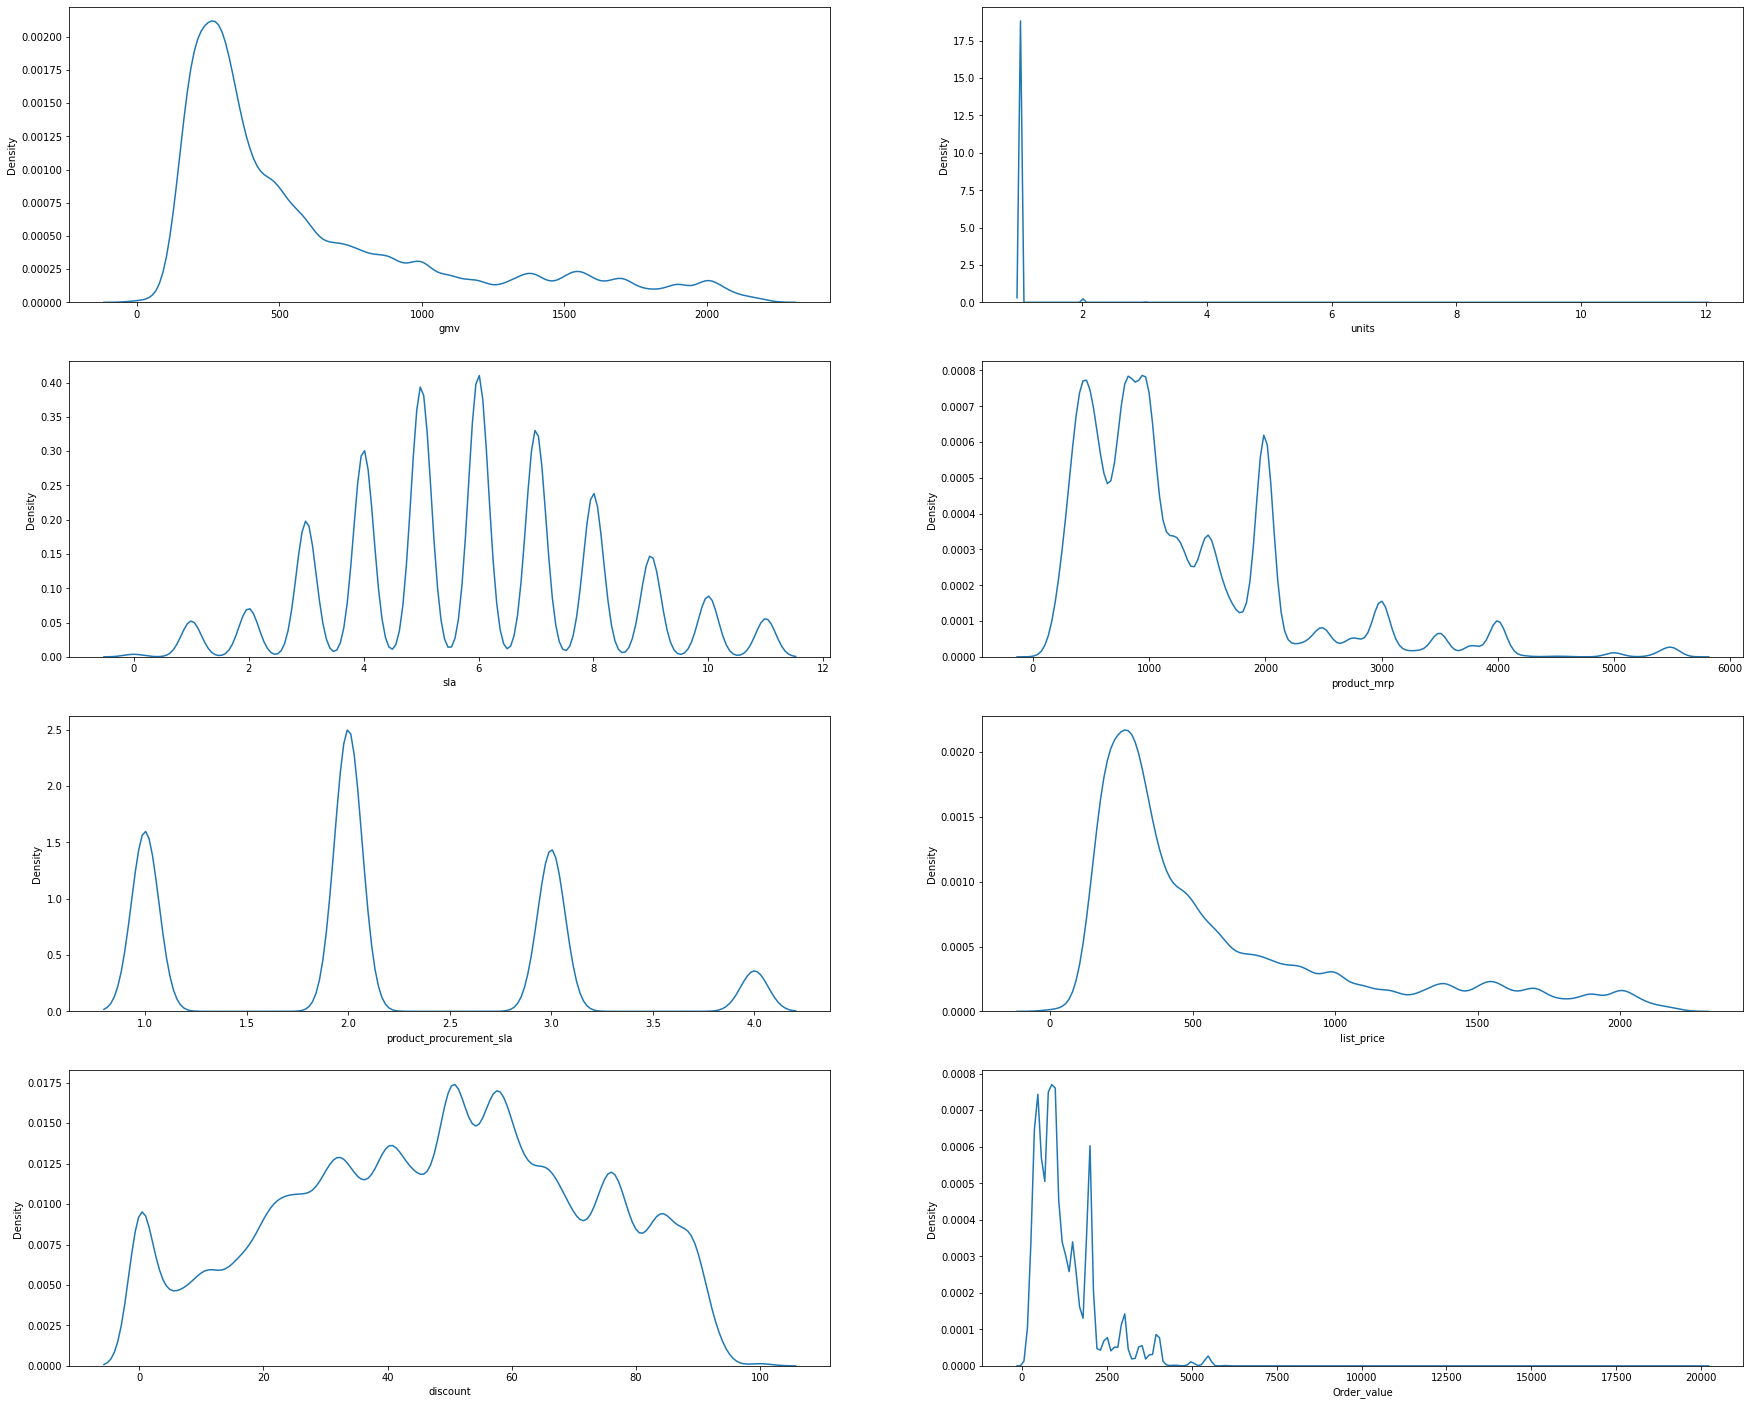

In [157]:
# Continuous Variables
plt.figure(figsize = (30, 25))
features = ['gmv','units','sla','product_mrp','product_procurement_sla','list_price','discount','Order_value']
for i in enumerate(features):
    plt.subplot(4, 2, i[0]+1)
    sns.distplot(consumer_data[i[1]].dropna(),hist = False)

**From the univariate analysis of the continuous variables, we can observe the following:**
***1) GMV of most products are in the range ```$```300-```$```400
2) Majority of people buy 1 unit at a time
3) Most products take around 5-6 days to get delivered to the customers
4) Most of the products have an MRP of around ```$```1000
5) Time taken to procure most products is 2 days
6) List price is mostly in the range of ```$```300-```$```400
7) Discounts are in the range of ```$```50-```$```60
8) Order value of the products are mostly around ```$```1000, same as MPR as majority people buy only 1 unit at a time***



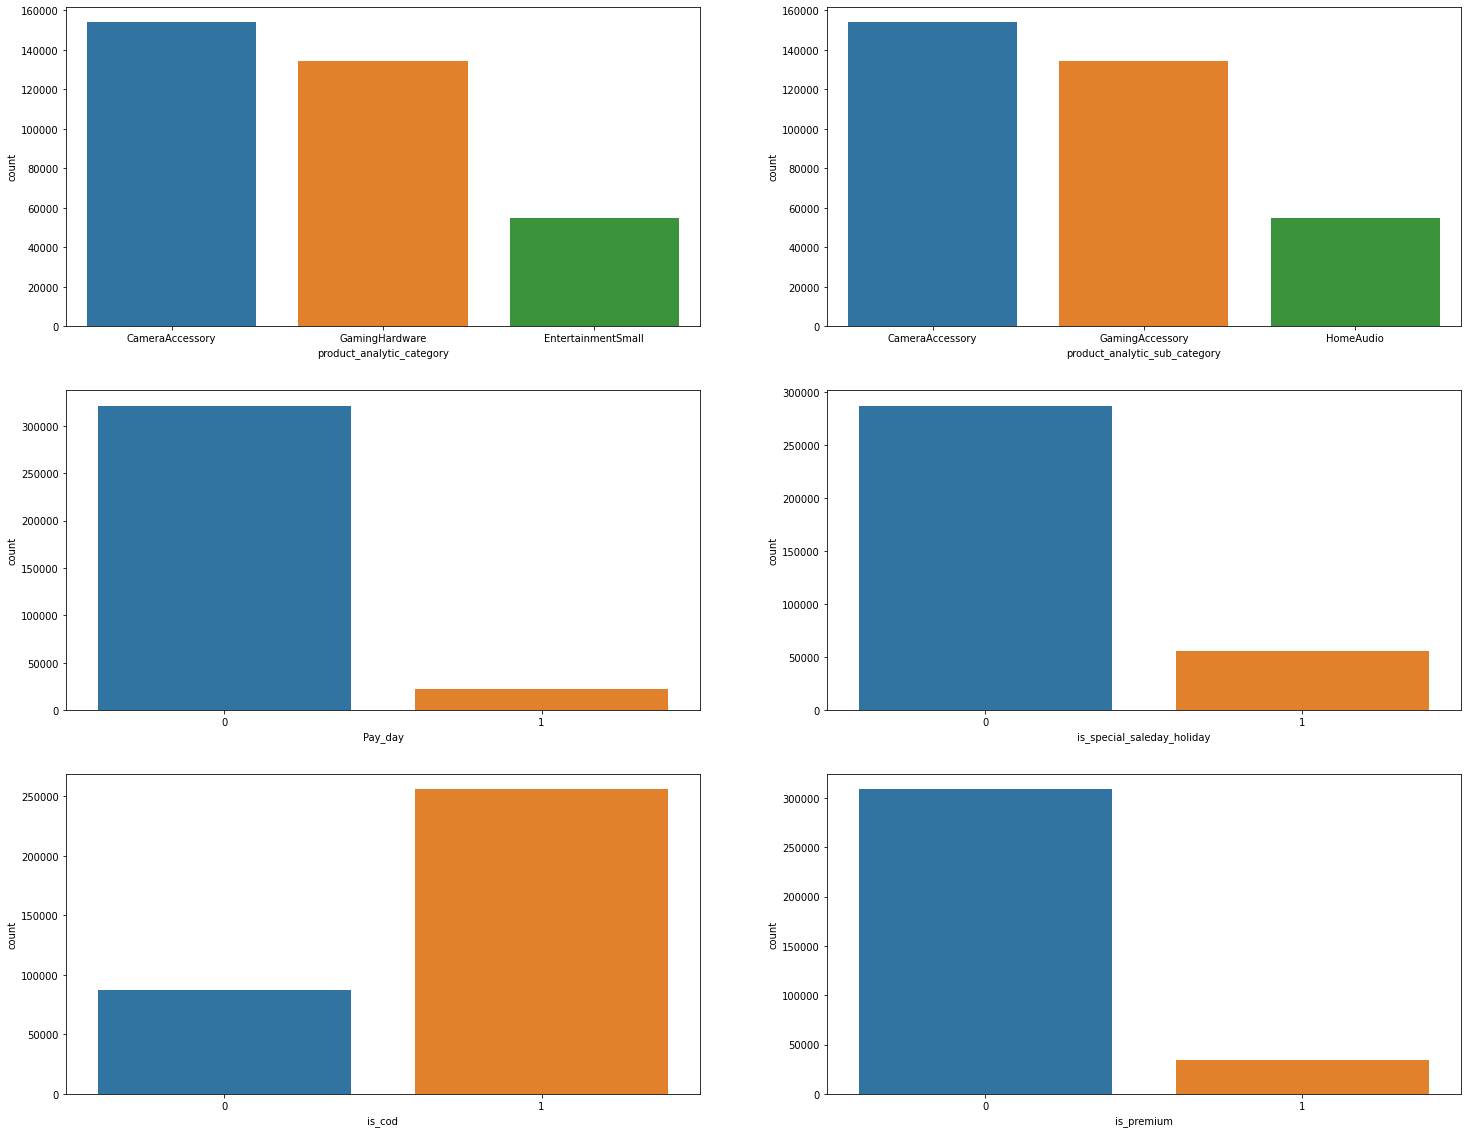

In [158]:
# Categorical Variables
plt.figure(figsize = (25, 20))
features = ['product_analytic_category','product_analytic_sub_category','Pay_day','is_special_saleday_holiday','is_cod','is_premium']
for i in enumerate(features):
    plt.subplot(3, 2, i[0]+1)
    sns.countplot(x = i[1], data = consumer_data)

**From the univariate anaysis of the categorical variables, we observe the following:**
***1) Camera Accessories have the highest units sold followed by gaming accessories
2) Majority products are non-premium and are sold on non-pay days, non-special days and are mostly COD's and this is consistent with the knowledge that we have***

### **NPS and STOCK INDEX**

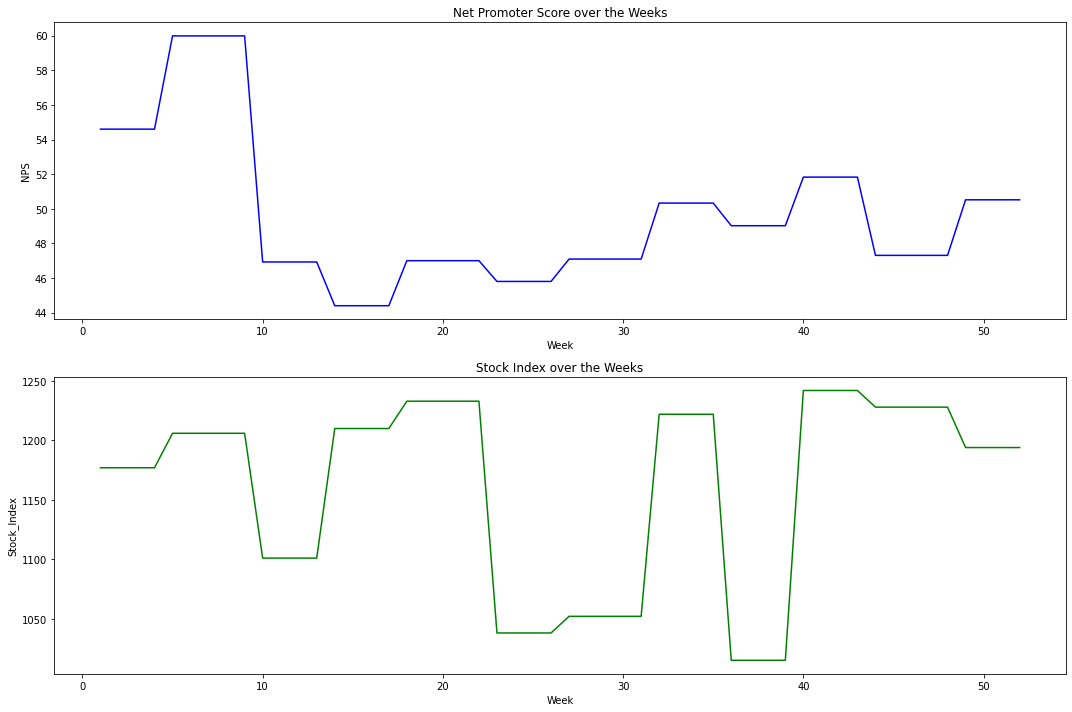

In [159]:
#Plotting the nps and stock index data over the weeks

plt.rcParams["figure.figsize"] = (15,10)
#NPS
plt.subplot(2,1,1)
plt.plot(nps_data.iloc[:,0], nps_data.iloc[:,1], 'b-')
plt.xlabel('Week')
plt.ylabel('NPS')
plt.title('Net Promoter Score over the Weeks')

#Stock Index
plt.subplot(2,1,2)
plt.plot(nps_data.iloc[:,0], nps_data.iloc[:,2], 'g-')
plt.xlabel('Week')
plt.ylabel('Stock_Index')
plt.title('Stock Index over the Weeks')

plt.tight_layout()
plt.show()

***Stock Index is the highest around the 20th week and the 40th week but it is notable that NPS is very low around 15th-20th week though it reaches a good stage in and around the 40th week(month of April-May).***

### **MEDIA INVESTMENT**


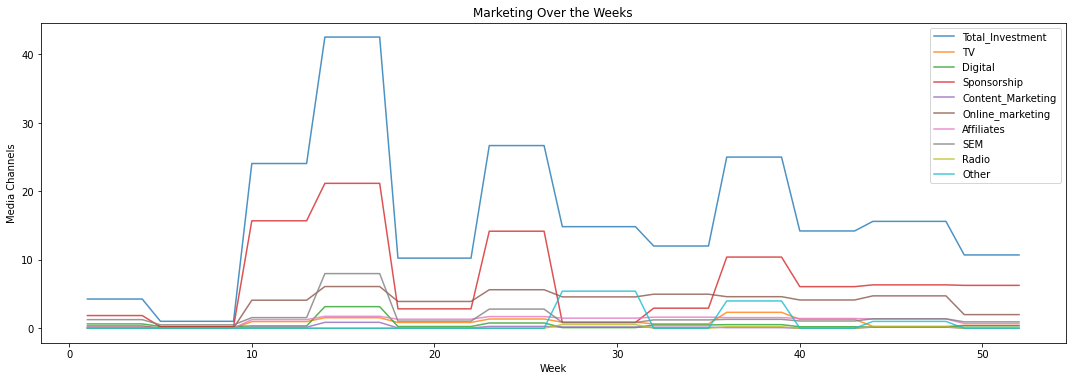

In [160]:
plt.rcParams["figure.figsize"] = (15,10)

plt.subplot(2,1,1)
plt.plot(media_investment.iloc[:,0], media_investment.iloc[:,1:11], alpha = 0.8)
plt.xlabel('Week')
plt.ylabel('Media Channels')
plt.title('Marketing Over the Weeks')
plt.legend(media_investment.iloc[:,1:11])

plt.tight_layout()
plt.show()

**Marketing for almost all the items has been the highest in and around the 15th-20th week. It will be interesting to see whether sales/revenue is also high in this period. Marketing is again high just before the 40th week. It will be interesting to see whether revenue/sales is also high just after that period**

## **Bivariate & Multivariate Analysis**

***Premium/Non-premium product by Sub-categories***

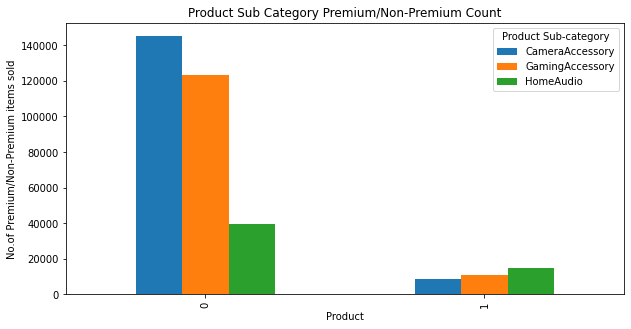

In [161]:
consumer_data.groupby(["is_premium", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', figsize=(10,5))
plt.xlabel('Product')
plt.ylabel('No.of Premium/Non-Premium items sold') 
plt.title('Product Sub Category Premium/Non-Premium Count')
plt.legend(title = 'Product Sub-category')

Number of premium items sold in all three sub-categories is lower as expected. But the notable thing is that:
***Home Audio has very high number of items sold in the premium category***.

***CASH ON DELIVERY***

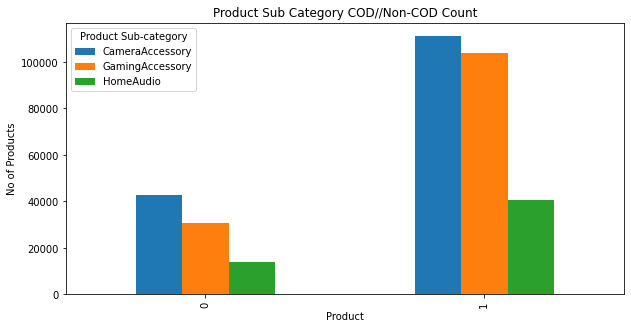

In [162]:
consumer_data.groupby(["is_cod", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', figsize=(10,5))
plt.xlabel('Product')
plt.ylabel('No of Products') 
plt.title('Product Sub Category COD//Non-COD Count')
plt.legend(title = 'Product Sub-category')

***All the three products are mainly COD***

***SALES AND GMV(REVENUE) BASED ON PRODUCT SUB-CATEGORIES***

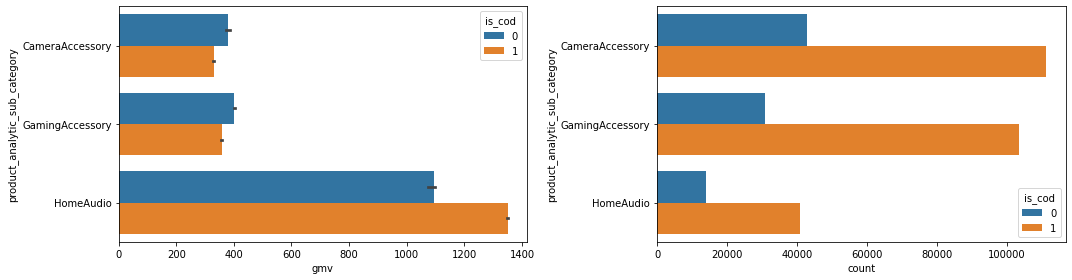

In [163]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
sns.barplot(x='gmv', y='product_analytic_sub_category', hue ='is_cod',data=consumer_data, estimator=np.median)

plt.subplot(1, 2, 2)
sns.countplot(y='product_analytic_sub_category', hue ='is_cod',data=consumer_data)

plt.tight_layout()
plt.show()

***Revenue(median) for prepaid products is higher for Camera and Gaming Accessories while for Home Audio, COD is higher***

***PAY-DAY & GMV***

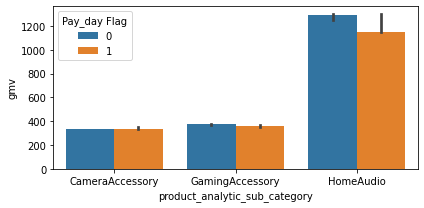

In [164]:
plt.rcParams["figure.figsize"] = (6,3)
sns.barplot(y='gmv',x='product_analytic_sub_category',hue = 'Pay_day',data = consumer_data, estimator=np.median)
plt.legend(title = 'Pay_day Flag')
plt.tight_layout()
plt.show()

***For Home Audio, the revenue is slightly higher than the other two when it comes to non-pay days***

***HOLIDAY/SPECIAL SALE & GMV***

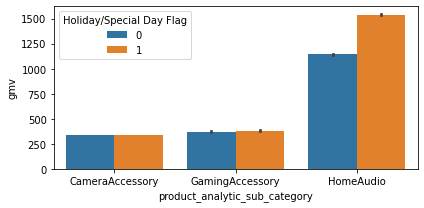

In [165]:
plt.rcParams["figure.figsize"] = (6,3)
sns.barplot(y='gmv',x='product_analytic_sub_category',hue = 'is_special_saleday_holiday',data = consumer_data, estimator=np.median)
plt.legend(title = 'Holiday/Special Day Flag')
plt.tight_layout()
plt.show()

***Revenue of Home Audio products is much higher on holidays than Camera and Gaming products***

***REVENUE OF SPECIAL SALE DAYS/HOLIDAYS BY MONTHS***

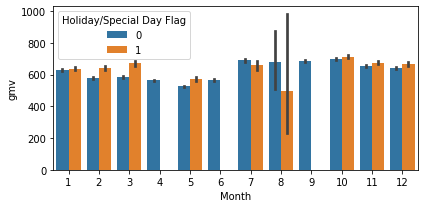

In [166]:
plt.rcParams["figure.figsize"] = (6,3)
sns.barplot(y='gmv',x='Month',hue = 'is_special_saleday_holiday',data = consumer_data)
plt.legend(title = 'Holiday/Special Day Flag')
plt.tight_layout()
plt.show()

***Revenue on holidays or special days is the highest in the period of October-December which is a festive season in Canada, starting from THANKSGIVING to CHRISTMAS!***

***COUNT OF SALES BY MONTHS***

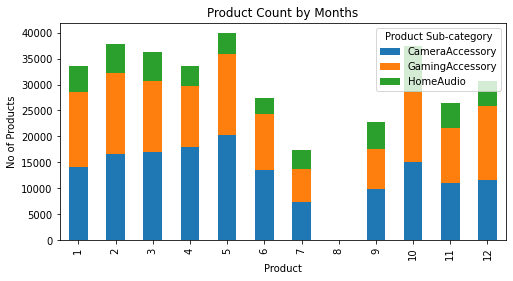

In [167]:
consumer_data.groupby(["Month", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', stacked = True, figsize=(8,4))
plt.xlabel('Product')
plt.ylabel('No of Products') 
plt.title('Product Count by Months')
plt.legend(title = 'Product Sub-category')

***May and October have the highest sales in terms of volume***

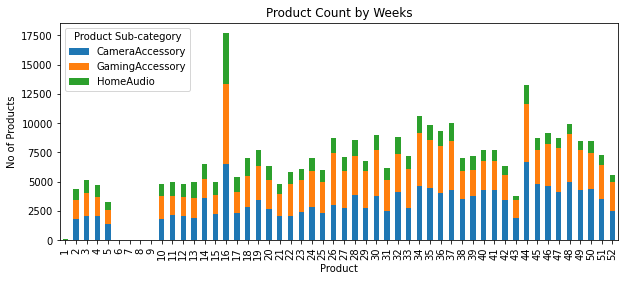

In [168]:
consumer_data.groupby(["Week", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', stacked = True, figsize=(10,4))
plt.xlabel('Product')
plt.ylabel('No of Products') 
plt.title('Product Count by Weeks')
plt.legend(title = 'Product Sub-category')

***Sales in 16th week (in October) is the highest followed by the last week in April, which is due to the marketing spends that happened just before, accompanied by high NPS and stock values.***

In [169]:
consumer_data.loc[consumer_data.Week==44]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,sla,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,Date,Week,list_price,discount,Order_value,Day,Pay_day,is_special_saleday_holiday,is_cod,is_premium
3320,ACCDFYZ479GFENYC,2016-04-27 01:33:04,2016,4,4.418233e+15,4.418233e+15,306.0,1,8,CameraAccessory,CameraAccessory,CameraBatteryCharger,306.0,1,2016-04-27,44,306.0,0.00,306.0,27,0,0,0,0
6535,ACCDR62K6HG3SENW,2016-04-27 00:42:56,2016,4,1.431577e+15,1.431577e+15,850.0,1,6,GamingHardware,GamingAccessory,GamingKeyboard,1670.0,4,2016-04-27,44,850.0,49.10,1670.0,27,0,0,0,0
30499,ACCEBJBCV6KF3AZ6,2016-04-27 00:32:00,2016,4,4.430620e+15,4.430620e+15,299.0,1,10,GamingHardware,GamingAccessory,GamingMouse,500.0,2,2016-04-27,44,299.0,40.20,500.0,27,0,0,0,0
37676,ACCCZ34CBZFWKPBQ,2016-04-27 00:41:42,2016,4,2.453381e+15,2.453381e+15,1090.0,1,5,GamingHardware,GamingAccessory,GamePad,3500.0,1,2016-04-27,44,1090.0,68.86,3500.0,27,0,0,0,1
37742,ACCCZ34CBZFWKPBQ,2016-04-27 00:51:27,2016,4,2.454119e+15,2.454119e+15,999.0,1,7,GamingHardware,GamingAccessory,GamePad,3500.0,1,2016-04-27,44,999.0,71.46,3500.0,27,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337443,ACCE9YXYEHYYH8KG,2016-04-27 02:37:36,2016,4,2.378843e+15,2.378843e+15,421.0,1,6,GamingHardware,GamingAccessory,GamingHeadset,999.0,1,2016-04-27,44,421.0,57.86,999.0,27,0,0,0,0
337472,ACCE9YXYEHYYH8KG,2016-04-26 19:37:56,2016,4,2.378843e+15,2.378843e+15,421.0,1,11,GamingHardware,GamingAccessory,GamingHeadset,999.0,1,2016-04-26,44,421.0,57.86,999.0,26,0,0,0,0
337638,ACCEA4ZHZSRFZYJN,2016-04-27 00:52:29,2016,4,2.378843e+15,2.378843e+15,431.0,1,6,GamingHardware,GamingAccessory,GamingHeadset,999.0,1,2016-04-27,44,431.0,56.86,999.0,27,0,0,0,0
339484,ACCEAYHJHWMKEYNH,2016-04-27 01:34:16,2016,4,1.392638e+15,1.392638e+15,519.0,1,7,GamingHardware,GamingAccessory,GamingMemoryCard,849.0,3,2016-04-27,44,519.0,38.87,849.0,27,0,0,0,0


***DISCOUNT RATE AND SALES***

In [170]:
# Binning Discounts
consumer_data['discount_bin'] = pd.cut(consumer_data.discount, [0,10,20,30,40,50,60,70,80,90,100], labels = ["Below 10%","10%-20%","20%-30%","30%-40%","40%-50%","50%-60%","60%-70%","70%-80%","80%-90%","Above 90%"])

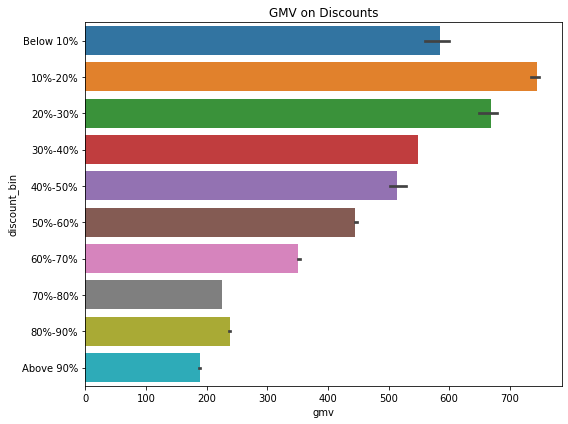

In [171]:
# Discount Rate Plot
plt.rcParams["figure.figsize"] = (8,6)
sns.barplot(y='discount_bin',x='gmv',data = consumer_data, estimator=np.median)
plt.title('GMV on Discounts')
plt.tight_layout()
plt.show()

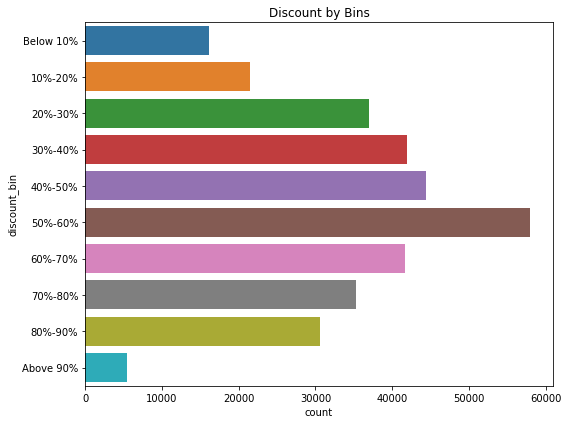

In [172]:
plt.rcParams["figure.figsize"] = (8,6)
sns.countplot(y='discount_bin',data = consumer_data)
plt.title('Discount by Bins')
plt.tight_layout()
plt.show()

***Highest revenue is generated when the discount is between 10%-20% and falls down gradually with higher discounts though it is being observed that maximum discounts are provided in the range of 50%-60%. This is one area which needs to be worked on surely***

***Correlation Matrix***

In [173]:
consumer_data.columns

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'sla', 'product_analytic_category',
       'product_analytic_sub_category', 'product_analytic_vertical',
       'product_mrp', 'product_procurement_sla', 'Date', 'Week', 'list_price',
       'discount', 'Order_value', 'Day', 'Pay_day',
       'is_special_saleday_holiday', 'is_cod', 'is_premium', 'discount_bin'],
      dtype='object')

(8.5, -0.5)

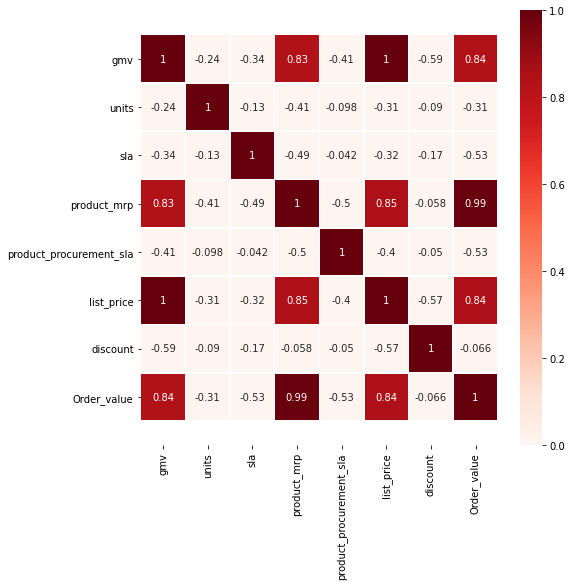

In [174]:
fig, ax = plt.subplots(figsize=(8,8)) 
corr_matrix= consumer_data[['gmv', 'units', 'sla','product_mrp', 'product_procurement_sla','list_price','discount', 'Order_value']].corr()
ax = sns.heatmap(corr_matrix.corr(), annot = True, cmap = 'Reds',linewidths=.5,vmin=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

In [175]:
corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_consumers = corr.unstack().reset_index()
corr_consumers.columns  = ['VAR1', 'VAR2', 'Correlation']
corr_consumers = corr_consumers.dropna(subset = ['Correlation'])
corr_consumers.Correlation = abs(corr_consumers.Correlation)

In [176]:
corr_consumers.sort_values("Correlation", ascending=False).head(10)

,VAR1,VAR2,Correlation
40,list_price,gmv,0.991205
59,Order_value,product_mrp,0.983791
43,list_price,product_mrp,0.744787
56,Order_value,gmv,0.738211
24,product_mrp,gmv,0.735499
61,Order_value,list_price,0.728090
48,discount,gmv,0.352307
53,discount,list_price,0.350134
62,Order_value,discount,0.258760
51,discount,product_mrp,0.257035


As expected, list_price and gmv, order_value and product_mrp, list_price and product_mrp have very high correlation since they are derived from one another. ***The high correlations between gmv (our dependent variable in the models) and other variables is good thing, so we won't be removing that but we should definitely remove the Order_value and product_mrp columns from the three dataframes as that is one of the variables that can lead to high multicollinearity in the model***

### **SELECTING VARIABLES FOR MODEL**

In [177]:
# We can remove product_mrp and Order_value from all the three dataframes now as it leads to high multicollinearity in the model
camera_data = camera_data.drop(['product_mrp','Order_value'],axis = 1)
gaming_data = gaming_data.drop(['product_mrp','Order_value'],axis = 1)
homeaudio_data = homeaudio_data.drop(['product_mrp','Order_value'],axis = 1)

In [178]:
#Filling all the missing values with '0'
camera_data.fillna(0, inplace = True)
gaming_data.fillna(0, inplace = True)
homeaudio_data.fillna(0, inplace = True)

In [179]:
# We also drop the variables with 'Other' suffix as it can't be interpreted in the model
camera_data = camera_data.drop(['Other','Other_MA_3','Other_MA_5','Other_adstock'],axis = 1)
gaming_data = gaming_data.drop(['Other','Other_MA_3','Other_MA_5','Other_adstock'],axis = 1)
homeaudio_data = homeaudio_data.drop(['Other','Other_MA_3','Other_MA_5','Other_adstock'],axis = 1)

## **MODEL BUILDING**

# **LINEAR REGRESSION**

***ADDITIVE MODEL***

In [180]:
# Creating a copy of the three dfs to use in the first model
camera_data_add = camera_data.copy()
gaming_data_add = gaming_data.copy()
homeaudio_data_add = homeaudio_data.copy()

In [181]:
# We can remove week from all the three dataframes now as we will not need it in the model
camera_data_add = camera_data_add.drop('Week',axis = 1)
gaming_data_add = gaming_data_add.drop('Week',axis = 1)
homeaudio_data_add = homeaudio_data_add.drop('Week',axis = 1)

In [182]:
#Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [183]:
# Scaling the variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

camera_data_add[camera_data_add.columns]=scaler.fit_transform(camera_data_add[camera_data_add.columns])
gaming_data_add[gaming_data_add.columns]=scaler.fit_transform(gaming_data_add[gaming_data_add.columns])
homeaudio_data_add[homeaudio_data_add.columns]=scaler.fit_transform(homeaudio_data_add[homeaudio_data_add.columns])

In [184]:
#Dividing into Train and Test sets
from sklearn.model_selection import train_test_split
#Camera
camera_train, camera_test = train_test_split(camera_data_add, train_size=0.7, test_size=0.3, random_state=100)

#Camera
gaming_train, gaming_test = train_test_split(gaming_data_add, train_size=0.7, test_size=0.3, random_state=100)

#Camera
homeaudio_train, homeaudio_test = train_test_split(homeaudio_data_add, train_size=0.7, test_size=0.3, random_state=100)


In [185]:
# Putting feature variable to X and response variable to Y
#Camera
y_train_camera = camera_train.pop('gmv')
X_train_camera = camera_train

y_test_camera = camera_test.pop('gmv')
X_test_camera = camera_test

#Gaming
y_train_gaming = gaming_train.pop('gmv')
X_train_gaming = gaming_train

y_test_gaming = gaming_test.pop('gmv')
X_test_gaming = gaming_test

#Home Audio
y_train_homeaudio = homeaudio_train.pop('gmv')
X_train_homeaudio = homeaudio_train

y_test_homeaudio = homeaudio_test.pop('gmv')
X_test_homeaudio = homeaudio_test

In [186]:
X_train_camera.head()

,sla,product_procurement_sla,list_price,list_price_MA_5,list_price_MA_3,discount,discount_MA_5,discount_MA_3,Pay_day,is_special_saleday_holiday,is_cod,is_premium,product_vertical_CameraAccessory,product_vertical_CameraBag,product_vertical_CameraBattery,product_vertical_CameraBatteryCharger,product_vertical_CameraBatteryGrip,product_vertical_CameraEyeCup,product_vertical_CameraFilmRolls,product_vertical_CameraHousing,product_vertical_CameraMicrophone,product_vertical_CameraMount,product_vertical_CameraRemoteControl,product_vertical_CameraTripod,product_vertical_ExtensionTube,product_vertical_Filter,product_vertical_Flash,product_vertical_FlashShoeAdapter,product_vertical_Lens,product_vertical_ReflectorUmbrella,product_vertical_Softbox,product_vertical_Strap,product_vertical_Telescope,max_temp_c,min_temp_c,mean_temp_c,heat_deg_days_c,cool_deg_days_c,total_rain_mm,total_snow_cm,...,NPS_MA_5,NPS_MA_3,Stock Index,Stock Index_MA_5,Stock Index_MA_3,Total_Investment,Total_Investment_MA_5,Total_Investment_MA_3,TV,TV_MA_5,TV_MA_3,Digital,Digital_MA_5,Digital_MA_3,Sponsorship,Sponsorship_MA_5,Sponsorship_MA_3,Content_Marketing,Content_Marketing_MA_5,Content_Marketing_MA_3,Online_marketing,Online_marketing_MA_5,Online_marketing_MA_3,Affiliates,Affiliates_MA_5,Affiliates_MA_3,SEM,SEM_MA_5,SEM_MA_3,Radio,Radio_MA_5,Radio_MA_3,TV_adstock,Digital_adstock,Sponsorship_adstock,Content_Marketing_adstock,Online_marketing_adstock,Affiliates_adstock,SEM_adstock,Radio_adstock
47,0.003192,-0.132484,-1.412156,-0.348836,-0.580754,0.920900,0.772916,0.739888,1.772657,-0.529412,1.112209,-0.400662,0.088286,0.762291,0.061187,0.426644,-0.253204,0.113813,3.341331,2.456804,-0.498184,-0.399117,0.307556,-0.613220,-0.708464,0.119851,1.247764,-0.202031,1.477750,-0.141421,-0.365148,0.831204,0.930973,0.680818,0.738756,0.722851,-0.732465,0.523332,0.387147,-0.265645,...,0.194200,0.098886,0.415232,0.484791,0.435770,-0.557565,-0.149246,-0.237103,-0.717634,-0.982676,-0.911529,-0.285105,-0.580009,-0.494505,-0.143468,-0.101378,-0.122033,-0.660568,-0.168337,-0.248517,-0.991175,0.265140,0.037103,-0.931052,0.099228,-0.089248,-0.448452,-0.269635,-0.301023,-0.540901,0.657137,0.372247,-0.884679,-0.502215,-0.140022,-0.412557,-0.229648,-0.299658,-0.393574,0.111604
43,-0.190916,-0.415143,-1.405601,-0.131765,-0.365698,1.326913,0.648448,0.723914,-0.759631,-0.529412,1.528594,0.285503,-0.464662,0.996154,0.214494,0.924248,-0.253204,0.113813,0.671658,1.016608,0.875188,0.618631,0.062472,0.229664,-0.708464,0.091087,1.748687,-0.202031,0.543920,-0.141421,5.842374,1.392149,2.349284,-0.173093,-0.370355,-0.322840,0.044544,-0.949270,-0.133369,-0.438229,...,0.346079,0.141490,0.836538,0.532737,0.503682,-0.091852,-0.133781,-0.117112,-0.941459,0.069525,-0.412757,-0.544219,-0.583140,-0.561798,-0.131664,-0.128763,-0.132951,0.002661,-0.526484,-0.252911,0.513114,0.368786,0.432291,0.285965,0.404064,0.350709,-0.210499,-0.341451,-0.276856,0.758651,-0.027775,0.372247,-0.560212,-0.632227,-0.133822,-0.193318,0.477470,0.351728,-0.295524,0.555333
36,-0.106413,-0.293275,-0.848878,-0.124378,-0.317507,0.698467,0.398157,0.350931,1.096306,-0.529412,0.494724,-0.505331,-0.543655,-0.206568,-0.097066,0.102448,-0.253204,0.500777,-0.155565,-0.423587,-0.498184,0.720405,-0.084578,0.002173,2.517576,0.019176,0.768558,-0.202031,-0.265399,7.071068,-0.365148,0.350394,0.525742,-0.875635,-0.600213,-0.635780,0.529683,-0.750351,-0.981302,-0.524522,...,0.311158,0.161645,-1.802821,0.095546,-0.420207,0.800539,0.418854,0.896090,2.298706,1.435176,2.473986,-0.066406,-0.053236,-0.047344,0.517383,0.110924,0.601270,-0.293403,-0.248485,-0.334240,0.446865,0.583025,0.476649,0.640172,0.725803,0.663452,-0.254892,-0.287137,-0.261650,0.743883,0.303007,0.850803,2.220651,-0.085127,0.459368,-0.316050,0.514439,0.691787,-0.307257,0.744375
17,-0.261018,0.592376,0.356756,0.544806,0.594044,-0.202750,0.098793,-0.167417,-0.759631,1.229541,0.521426,0.948407,-0.306677,0.194340,-0.319608,-0.545945,-0.253204,-0.660115,-0.493974,-0.423587,-0.498184,0.415081,0.6996

### **Camera Accessories**

 ***Without Feature Selection***

In [187]:
lr_camera = LinearRegression().fit(X_train_camera,y_train_camera)

In [188]:
y_test_pred_camera = lr_camera.predict(X_test_camera)

In [189]:
# Evaluating the fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [190]:
# R-Squared and MSE
print('R2 Score: ',r2_score(y_test_camera, y_test_pred_camera))
print('Mean Squared Error: ',mean_squared_error(y_test_camera, y_test_pred_camera))

R2 Score:  0.9091930022343485
Mean Squared Error:  0.1166473559123124


In [191]:
cols = X_train_camera.columns

 ***With Feature Selection***

**Using RFE**

In [192]:
lr_camera_rfe = LinearRegression()
from sklearn.feature_selection import RFE
rfe = RFE(lr_camera_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_camera, y_train_camera)

In [193]:
rfe.support_

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False,  True,  True, False,  True,  True, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False])

In [194]:
list(zip(X_train_camera.columns, rfe.support_, rfe.ranking_))

[('sla', False, 26),
 ('product_procurement_sla', False, 13),
 ('list_price', False, 34),
 ('list_price_MA_5', True, 1),
 ('list_price_MA_3', False, 32),
 ('discount', False, 35),
 ('discount_MA_5', False, 40),
 ('discount_MA_3', False, 48),
 ('Pay_day', False, 3),
 ('is_special_saleday_holiday', False, 11),
 ('is_cod', False, 4),
 ('is_premium', False, 15),
 ('product_vertical_CameraAccessory', False, 62),
 ('product_vertical_CameraBag', True, 1),
 ('product_vertical_CameraBattery', True, 1),
 ('product_vertical_CameraBatteryCharger', True, 1),
 ('product_vertical_CameraBatteryGrip', False, 68),
 ('product_vertical_CameraEyeCup', False, 8),
 ('product_vertical_CameraFilmRolls', False, 33),
 ('product_vertical_CameraHousing', True, 1),
 ('product_vertical_CameraMicrophone', True, 1),
 ('product_vertical_CameraMount', False, 16),
 ('product_vertical_CameraRemoteControl', True, 1),
 ('product_vertical_CameraTripod', True, 1),
 ('product_vertical_ExtensionTube', False, 20),
 ('product_ver

In [195]:
col = X_train_camera.columns[rfe.support_]

In [196]:
X_train_camera.columns[~rfe.support_]

Index(['sla', 'product_procurement_sla', 'list_price', 'list_price_MA_3',
       'discount', 'discount_MA_5', 'discount_MA_3', 'Pay_day',
       'is_special_saleday_holiday', 'is_cod', 'is_premium',
       'product_vertical_CameraAccessory',
       'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup',
       'product_vertical_CameraFilmRolls', 'product_vertical_CameraMount',
       'product_vertical_ExtensionTube', 'product_vertical_Filter',
       'product_vertical_FlashShoeAdapter',
       'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox',
       'product_vertical_Strap', 'product_vertical_Telescope', 'max_temp_c',
       'min_temp_c', 'mean_temp_c', 'heat_deg_days_c', 'cool_deg_days_c',
       'total_rain_mm', 'total_precip_mm', 'snow_on_grnd_cm', 'NPS_MA_5',
       'NPS_MA_3', 'Stock Index', 'Stock Index_MA_3', 'Total_Investment',
       'Total_Investment_MA_5', 'Total_Investment_MA_3', 'TV', 'TV_MA_5',
       'TV_MA_3', 'Digital', 'Digital_MA_5', 'D

**We will be using the statsmodels linear regression package now as we need to inspect the p-values of the variables now**

In [197]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera[col]
y = y_train_camera

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     276.5
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.53e-19
Time:                        15:54:52   Log-Likelihood:                 47.788
No. Observations:                  35   AIC:                            -63.58
Df Residuals:                      19   BIC:                            -38.69
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

We have to drop the columns 'product_vertical_CameraHousing','product_vertical_CameraBag','product_vertical_CameraMicrophone' due to high p values

In [198]:
col = col.drop(['product_vertical_CameraHousing','product_vertical_CameraBag','product_vertical_CameraMicrophone'],1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'total_snow_cm',
       'NPS', 'Stock Index_MA_5', 'Sponsorship', 'Radio'],
      dtype='object')

In [199]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera[col]
y = y_train_camera

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     270.7
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.41e-21
Time:                        15:54:52   Log-Likelihood:                 40.985
No. Observations:                  35   AIC:                            -55.97
Df Residuals:                      22   BIC:                            -35.75
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

We have to drop the columns 'total_snow_cm' due to high p value

In [200]:
col = col.drop('total_snow_cm',1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Stock Index_MA_5', 'Sponsorship', 'Radio'],
      dtype='object')

In [201]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera[col]
y = y_train_camera

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     266.5
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.59e-21
Time:                        15:54:52   Log-Likelihood:                 38.431
No. Observations:                  35   AIC:                            -52.86
Df Residuals:                      23   BIC:                            -34.20
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [202]:
col = col.drop('Radio',1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Stock Index_MA_5', 'Sponsorship'],
      dtype='object')

In [203]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera[col]
y = y_train_camera

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     261.7
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.58e-22
Time:                        15:54:52   Log-Likelihood:                 35.722
No. Observations:                  35   AIC:                            -49.44
Df Residuals:                      24   BIC:                            -32.33
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [204]:
col = col.drop('product_vertical_CameraBatteryCharger',1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Stock Index_MA_5', 'Sponsorship'],
      dtype='object')

In [205]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera[col]
y = y_train_camera

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     275.9
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           9.76e-23
Time:                        15:54:52   Log-Likelihood:                 34.106
No. Observations:                  35   AIC:                            -48.21
Df Residuals:                      25   BIC:                            -32.66
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


**All the p-values are within acceptable range(less than 0.05).**

In [206]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [207]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera[col].values, i) for i in range(X_train_camera[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,Stock Index_MA_5,17.77
0,list_price_MA_5,15.98
4,product_vertical_Flash,5.34
2,product_vertical_CameraRemoteControl,4.31
5,product_vertical_Lens,4.27
8,Sponsorship,3.23
1,product_vertical_CameraBattery,3.20
6,NPS,3.05
3,product_vertical_CameraTripod,2.39


In [208]:
col = col.drop('Stock Index_MA_5',1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Sponsorship'],
      dtype='object')

In [209]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera[col]
y = y_train_camera

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     245.6
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.74e-22
Time:                        15:54:52   Log-Likelihood:                 29.374
No. Observations:                  35   AIC:                            -40.75
Df Residuals:                      26   BIC:                            -26.75
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [210]:
col = col.drop('list_price_MA_5',1)
col

Index(['product_vertical_CameraBattery',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Sponsorship'],
      dtype='object')

In [211]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera[col]
y = y_train_camera

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     253.6
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           6.16e-23
Time:                        15:54:52   Log-Likelihood:                 26.974
No. Observations:                  35   AIC:                            -37.95
Df Residuals:                      27   BIC:                            -25.51
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [212]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera[col].values, i) for i in range(X_train_camera[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,product_vertical_CameraRemoteControl,4.15
4,product_vertical_Lens,3.96
3,product_vertical_Flash,2.88
6,Sponsorship,2.55
0,product_vertical_CameraBattery,2.43
5,NPS,2.32
2,product_vertical_CameraTripod,2.11


**All the p-values and VIF's within acceptable range, we will keep these variables in our model!**

In [213]:
lr_camera_new = LinearRegression().fit(X_train_camera[col],y_train_camera)

In [214]:
y_test_pred_camera = lr_camera_new.predict(X_test_camera[col])

In [215]:
# R-Squared and MSE
print('R2 Score: ',r2_score(y_test_camera, y_test_pred_camera))
print('Mean Squared Error: ',mean_squared_error(y_test_camera, y_test_pred_camera))

R2 Score:  0.919421135996422
Mean Squared Error:  0.10350866849152199


The R-squared value after applying RFE is 0.92, not a bad value to be honest!

In [216]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_camera_new.coef_, lr_camera_new.intercept_)

[ 0.4717513   0.11479068  0.20928012  0.28810656  0.18840666 -0.17900837
 -0.13710761] 0.05786218884331389


In [217]:
# intercept
intercept_df = pd.DataFrame(lr_camera_new.intercept_.reshape((1,1)), columns = ['intercept'])

In [218]:
X_test_camera[col].columns

Index(['product_vertical_CameraBattery',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Sponsorship'],
      dtype='object')

In [219]:
# Coefficients 
coefficients = lr_camera_new.coef_.reshape((7, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_camera[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [220]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
0,product_vertical_CameraBattery,0.472
3,product_vertical_Flash,0.288
2,product_vertical_CameraTripod,0.209
4,product_vertical_Lens,0.188
1,product_vertical_CameraRemoteControl,0.115
6,Sponsorship,-0.137
5,NPS,-0.179


**TOP VARIABLES AFFECTING GMV OF CAMERA ACCESSORIES**

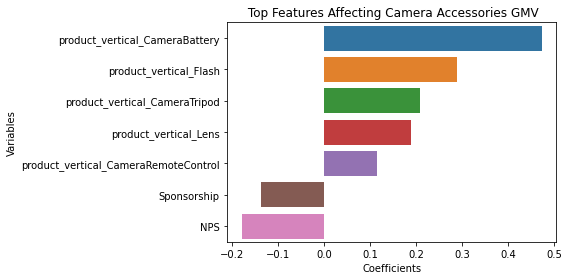

In [221]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (8,4)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title(' Top Features Affecting Camera Accessories GMV')
plt.tight_layout()
plt.show()

### **Gaming Accessories**

 ***Without Feature Selection***

In [222]:
lr_gaming = LinearRegression().fit(X_train_gaming,y_train_gaming)

In [223]:
y_test_pred_gaming = lr_gaming.predict(X_test_gaming)

In [224]:
# R-Squared and MSE
print('R2 Score: ',r2_score(y_test_gaming, y_test_pred_gaming))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming, y_test_pred_gaming))

R2 Score:  0.7423739560032983
Mean Squared Error:  0.284075304019366


 ***With Feature Selection***

**Using RFE**

In [225]:
lr_gaming_rfe = LinearRegression()
from sklearn.feature_selection import RFE
rfe = RFE(lr_gaming_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_gaming, y_train_gaming)

In [226]:
list(zip(X_train_gaming.columns, rfe.support_, rfe.ranking_))

[('sla', False, 11),
 ('product_procurement_sla', False, 19),
 ('list_price', True, 1),
 ('list_price_MA_5', False, 35),
 ('list_price_MA_3', True, 1),
 ('discount', False, 62),
 ('discount_MA_5', False, 22),
 ('discount_MA_3', False, 50),
 ('Pay_day', False, 21),
 ('is_special_saleday_holiday', True, 1),
 ('is_cod', False, 37),
 ('is_premium', False, 4),
 ('product_vertical_GameControlMount', False, 46),
 ('product_vertical_GamePad', False, 12),
 ('product_vertical_GamingAccessoryKit', True, 1),
 ('product_vertical_GamingAdapter', False, 15),
 ('product_vertical_GamingChargingStation', True, 1),
 ('product_vertical_GamingGun', False, 60),
 ('product_vertical_GamingHeadset', True, 1),
 ('product_vertical_GamingKeyboard', True, 1),
 ('product_vertical_GamingMemoryCard', True, 1),
 ('product_vertical_GamingMouse', False, 8),
 ('product_vertical_GamingMousePad', False, 7),
 ('product_vertical_GamingSpeaker', False, 9),
 ('product_vertical_JoystickGamingWheel', False, 3),
 ('product_vertic

In [227]:
col = X_train_gaming.columns[rfe.support_]

In [228]:
X_train_gaming.columns[~rfe.support_]

Index(['sla', 'product_procurement_sla', 'list_price_MA_5', 'discount',
       'discount_MA_5', 'discount_MA_3', 'Pay_day', 'is_cod', 'is_premium',
       'product_vertical_GameControlMount', 'product_vertical_GamePad',
       'product_vertical_GamingAdapter', 'product_vertical_GamingGun',
       'product_vertical_GamingMouse', 'product_vertical_GamingMousePad',
       'product_vertical_GamingSpeaker',
       'product_vertical_JoystickGamingWheel',
       'product_vertical_MotionController',
       'product_vertical_TVOutCableAccessory', 'max_temp_c', 'min_temp_c',
       'mean_temp_c', 'cool_deg_days_c', 'total_snow_cm', 'total_precip_mm',
       'snow_on_grnd_cm', 'NPS', 'NPS_MA_5', 'Stock Index', 'Stock Index_MA_5',
       'Stock Index_MA_3', 'Total_Investment', 'Total_Investment_MA_5',
       'Total_Investment_MA_3', 'TV', 'TV_MA_5', 'TV_MA_3', 'Sponsorship',
       'Sponsorship_MA_5', 'Sponsorship_MA_3', 'Content_Marketing',
       'Content_Marketing_MA_5', 'Content_Marketing_MA_3

In [229]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming[col]
y = y_train_gaming

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     311.0
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.47e-20
Time:                        15:54:53   Log-Likelihood:                 48.031
No. Observations:                  36   AIC:                            -64.06
Df Residuals:                      20   BIC:                            -38.73
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

We will drop the columns 'NPS_MA_3' and 'Digital_MA_3' because of their high p-values!

In [230]:
col = col.drop(['NPS_MA_3','Digital_MA_3'], 1)
col

Index(['list_price', 'list_price_MA_3', 'is_special_saleday_holiday',
       'product_vertical_GamingAccessoryKit',
       'product_vertical_GamingChargingStation',
       'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard',
       'product_vertical_GamingMemoryCard', 'heat_deg_days_c', 'total_rain_mm',
       'Digital', 'Digital_MA_5', 'Online_marketing_MA_3'],
      dtype='object')

In [231]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming[col]
y = y_train_gaming

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     341.6
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           3.04e-22
Time:                        15:54:53   Log-Likelihood:                 45.440
No. Observations:                  36   AIC:                            -62.88
Df Residuals:                      22   BIC:                            -40.71
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

**CHECK VIF**

In [232]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_gaming[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_gaming[col].values, i) for i in range(X_train_gaming[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,Online_marketing_MA_3,7.12
5,product_vertical_GamingHeadset,4.63
6,product_vertical_GamingKeyboard,4.00
8,heat_deg_days_c,3.84
10,Digital,3.08
4,product_vertical_GamingChargingStation,2.78
7,product_vertical_GamingMemoryCard,2.78
2,is_special_saleday_holiday,2.71
1,list_price_MA_3,2.60
3,product_vertical_GamingAccessoryKit,2.48


***All the VIF values being satisfactory, we shall use these 13 variables to build our final Logistic Regression Model.***

In [233]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_gaming_rfe = LinearRegression()
lr_gaming_rfe.fit(X_train_gaming[col], y_train_gaming)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [234]:
y_pred_rf_gaming = lr_gaming_rfe.predict(X_test_gaming[col])

In [235]:
print('R2 Score: ',r2_score(y_test_gaming, y_pred_rf_gaming))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming, y_pred_rf_gaming))

R2 Score:  0.6843660394088888
Mean Squared Error:  0.34803862188290413


The R-squared value after applying RFE is 0.68!

In [236]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_gaming_rfe.coef_, lr_gaming_rfe.intercept_)

[ 0.16439065  0.24536236  0.07975192  0.32006207  0.10068461  0.37118503
  0.3749276   0.11112048 -0.25934096  0.18075057 -0.08983845 -0.08021899
  0.35123038] -0.011680567572481648


In [237]:
# intercept
intercept_df = pd.DataFrame(lr_gaming_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [238]:
# Coefficients 
coefficients = lr_gaming_rfe.coef_.reshape((13, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_gaming[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [239]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
6,product_vertical_GamingKeyboard,0.375
5,product_vertical_GamingHeadset,0.371
12,Online_marketing_MA_3,0.351
3,product_vertical_GamingAccessoryKit,0.320
1,list_price_MA_3,0.245
9,total_rain_mm,0.181
0,list_price,0.164
7,product_vertical_GamingMemoryCard,0.111
4,product_vertical_GamingChargingStation,0.101
2,is_special_saleday_holiday,0.080


**TOP VARIABLES AFFECTING GMV OF GAMING ACCESSORIES**

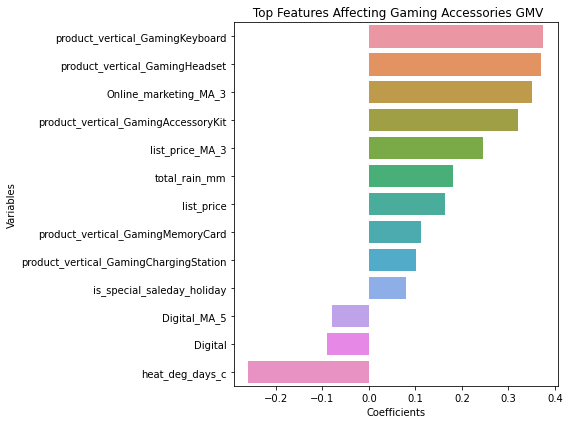

In [240]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (8,6)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title(' Top Features Affecting Gaming Accessories GMV')
plt.tight_layout()
plt.show()

### **Home Audio**

 ***Without Feature Selection***

In [241]:
lr_homeaudio = LinearRegression().fit(X_train_homeaudio,y_train_homeaudio)

In [242]:
y_test_pred_homeaudio = lr_homeaudio.predict(X_test_homeaudio)

In [243]:
# R-Squared and MSE
print('R2 Score: ',r2_score(y_test_homeaudio, y_test_pred_homeaudio))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio, y_test_pred_homeaudio))

R2 Score:  0.9138755401205166
Mean Squared Error:  0.2366004383711899


 ***With Feature Selection***

**Using RFE**

In [244]:
lr_homeaudio_rfe = LinearRegression()
from sklearn.feature_selection import RFE
rfe = RFE(lr_homeaudio_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_homeaudio, y_train_homeaudio)

In [245]:
list(zip(X_train_homeaudio.columns, rfe.support_, rfe.ranking_))

[('sla', False, 3),
 ('product_procurement_sla', False, 7),
 ('list_price', True, 1),
 ('list_price_MA_5', False, 53),
 ('list_price_MA_3', False, 11),
 ('discount', False, 19),
 ('discount_MA_5', False, 39),
 ('discount_MA_3', True, 1),
 ('Pay_day', False, 17),
 ('is_special_saleday_holiday', False, 32),
 ('is_cod', True, 1),
 ('is_premium', True, 1),
 ('product_vertical_Dock', False, 4),
 ('product_vertical_DockingStation', False, 8),
 ('product_vertical_FMRadio', True, 1),
 ('product_vertical_HiFiSystem', False, 30),
 ('product_vertical_HomeAudioSpeaker', True, 1),
 ('product_vertical_VoiceRecorder', True, 1),
 ('max_temp_c', True, 1),
 ('min_temp_c', False, 15),
 ('mean_temp_c', False, 16),
 ('heat_deg_days_c', False, 20),
 ('cool_deg_days_c', False, 36),
 ('total_rain_mm', False, 38),
 ('total_snow_cm', False, 14),
 ('total_precip_mm', False, 24),
 ('snow_on_grnd_cm', False, 44),
 ('NPS', True, 1),
 ('NPS_MA_5', False, 12),
 ('NPS_MA_3', True, 1),
 ('Stock Index', False, 45),
 ('S

In [246]:
col = X_train_homeaudio.columns[rfe.support_]

In [247]:
X_train_homeaudio.columns[~rfe.support_]

Index(['sla', 'product_procurement_sla', 'list_price_MA_5', 'list_price_MA_3',
       'discount', 'discount_MA_5', 'Pay_day', 'is_special_saleday_holiday',
       'product_vertical_Dock', 'product_vertical_DockingStation',
       'product_vertical_HiFiSystem', 'min_temp_c', 'mean_temp_c',
       'heat_deg_days_c', 'cool_deg_days_c', 'total_rain_mm', 'total_snow_cm',
       'total_precip_mm', 'snow_on_grnd_cm', 'NPS_MA_5', 'Stock Index',
       'Stock Index_MA_5', 'Stock Index_MA_3', 'Total_Investment',
       'Total_Investment_MA_5', 'Total_Investment_MA_3', 'TV', 'TV_MA_5',
       'TV_MA_3', 'Digital', 'Digital_MA_5', 'Digital_MA_3', 'Sponsorship',
       'Sponsorship_MA_5', 'Sponsorship_MA_3', 'Content_Marketing',
       'Content_Marketing_MA_5', 'Content_Marketing_MA_3',
       'Online_marketing_MA_3', 'Affiliates_MA_5', 'Affiliates_MA_3', 'SEM',
       'SEM_MA_5', 'SEM_MA_3', 'Radio', 'Radio_MA_5', 'Radio_MA_3',
       'Sponsorship_adstock', 'Content_Marketing_adstock',
       'Onl

In [248]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio[col]
y = y_train_homeaudio

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3875.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.34e-27
Time:                        15:54:54   Log-Likelihood:                 114.37
No. Observations:                  33   AIC:                            -196.7
Df Residuals:                      17   BIC:                            -172.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [249]:
col = col.drop(['discount_MA_3','is_premium','NPS_MA_3'], 1)
col

Index(['list_price', 'is_cod', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder',
       'max_temp_c', 'NPS', 'Online_marketing', 'Online_marketing_MA_5',
       'Affiliates', 'TV_adstock', 'Digital_adstock'],
      dtype='object')

In [250]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio[col]
y = y_train_homeaudio

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3478.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.91e-30
Time:                        15:54:54   Log-Likelihood:                 106.23
No. Observations:                  33   AIC:                            -186.5
Df Residuals:                      20   BIC:                            -167.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [251]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_homeaudio[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_homeaudio[col].values, i) for i in range(X_train_homeaudio[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,Affiliates,230.48
7,Online_marketing,178.26
8,Online_marketing_MA_5,12.79
1,is_cod,9.60
3,product_vertical_HomeAudioSpeaker,8.10
6,NPS,7.56
0,list_price,7.55
2,product_vertical_FMRadio,5.77
5,max_temp_c,5.55
10,TV_adstock,5.32


In [252]:
col = col.drop('Affiliates', 1)
col

Index(['list_price', 'is_cod', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder',
       'max_temp_c', 'NPS', 'Online_marketing', 'Online_marketing_MA_5',
       'TV_adstock', 'Digital_adstock'],
      dtype='object')

In [253]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio[col]
y = y_train_homeaudio

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1030.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.23e-26
Time:                        15:54:54   Log-Likelihood:                 83.924
No. Observations:                  33   AIC:                            -143.8
Df Residuals:                      21   BIC:                            -125.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [254]:
col = col.drop(['Digital_adstock','TV_adstock','Online_marketing_MA_5','Online_marketing','NPS','max_temp_c','is_cod'], 1)
col

Index(['list_price', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder'],
      dtype='object')

In [255]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio[col]
y = y_train_homeaudio

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2503.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.57e-35
Time:                        15:54:54   Log-Likelihood:                 77.160
No. Observations:                  33   AIC:                            -144.3
Df Residuals:                      28   BIC:                            -136.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [256]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_homeaudio[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_homeaudio[col].values, i) for i in range(X_train_homeaudio[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,product_vertical_HomeAudioSpeaker,3.30
0,list_price,3.08
1,product_vertical_FMRadio,2.16
3,product_vertical_VoiceRecorder,1.56


In [257]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_homeaudio_rfe = LinearRegression()
lr_homeaudio_rfe.fit(X_train_homeaudio[col], y_train_homeaudio)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [258]:
y_pred_rf_homeaudio = lr_homeaudio_rfe.predict(X_test_homeaudio[col])

In [259]:
print('R2 Score: ',r2_score(y_test_homeaudio, y_pred_rf_homeaudio))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio, y_pred_rf_homeaudio))

R2 Score:  0.9757189557326561
Mean Squared Error:  0.06670469371654525


The R-squared value after applying RFE is 0.97!

In [260]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_homeaudio_rfe.coef_, lr_homeaudio_rfe.intercept_)

[0.11313269 0.20606013 0.66410972 0.02889709] -0.006954841703644146


In [261]:
# intercept
intercept_df = pd.DataFrame(lr_homeaudio_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [262]:
# Coefficients 
coefficients = lr_homeaudio_rfe.coef_.reshape((4, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_homeaudio[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [263]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
2,product_vertical_HomeAudioSpeaker,0.664
1,product_vertical_FMRadio,0.206
0,list_price,0.113
3,product_vertical_VoiceRecorder,0.029


**TOP VARIABLES AFFECTING GMV OF HOMEAUDIO**

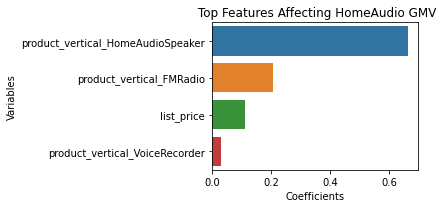

In [264]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (6,3)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title(' Top Features Affecting HomeAudio GMV')
plt.tight_layout()
plt.show()

***MULTIPLICATIVE MODEL***

In [265]:
# Creating a copy of the three dfs to use in the first model
camera_data_mult = camera_data.copy()
gaming_data_mult = gaming_data.copy()
homeaudio_data_mult = homeaudio_data.copy()

In [266]:
# We can remove week from all the three dataframes now as we will not need it in the model
camera_data_mult = camera_data_mult.drop('Week',axis = 1)
gaming_data_mult = gaming_data_mult.drop('Week',axis = 1)
homeaudio_data_mult = homeaudio_data_mult.drop('Week',axis = 1)

In [267]:
# Taking log of all the three dfs and replacing the infinite and null values with 0
camera_data_mult = camera_data_mult.applymap(lambda x: np.log(x))
camera_data_mult = camera_data_mult.replace([np.inf, -np.inf], 0)
camera_data_mult = camera_data_mult.fillna(0)

gaming_data_mult = gaming_data_mult.applymap(lambda x: np.log(x))
gaming_data_mult = gaming_data_mult.replace([np.inf, -np.inf], 0)
gaming_data_mult = gaming_data_mult.fillna(0)

homeaudio_data_mult = homeaudio_data_mult.applymap(lambda x: np.log(x))
homeaudio_data_mult = homeaudio_data_mult.replace([np.inf, -np.inf], 0)
homeaudio_data_mult = homeaudio_data_mult.fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [268]:
# Scaling the variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

camera_data_mult[camera_data_mult.columns]=scaler.fit_transform(camera_data_mult[camera_data_mult.columns])
gaming_data_mult[gaming_data_mult.columns]=scaler.fit_transform(gaming_data_mult[gaming_data_mult.columns])
homeaudio_data_mult[homeaudio_data_mult.columns]=scaler.fit_transform(homeaudio_data_mult[homeaudio_data_mult.columns])

In [269]:
#Dividing into Train and Test sets
from sklearn.model_selection import train_test_split
#Camera
camera_train, camera_test = train_test_split(camera_data_mult, train_size=0.7, test_size=0.3, random_state=100)

#Gaming
gaming_train, gaming_test = train_test_split(gaming_data_mult, train_size=0.7, test_size=0.3, random_state=100)

#HomeAudio
homeaudio_train, homeaudio_test = train_test_split(homeaudio_data_mult, train_size=0.7, test_size=0.3, random_state=100)


In [270]:
# Putting feature variable to X and response variable to Y
#Camera
y_train_camera_mult = camera_train.pop('gmv')
X_train_camera_mult = camera_train

y_test_camera_mult = camera_test.pop('gmv')
X_test_camera_mult = camera_test

#Gaming
y_train_gaming_mult = gaming_train.pop('gmv')
X_train_gaming_mult = gaming_train

y_test_gaming_mult = gaming_test.pop('gmv')
X_test_gaming_mult = gaming_test

#Home Audio
y_train_homeaudio_mult = homeaudio_train.pop('gmv')
X_train_homeaudio_mult = homeaudio_train

y_test_homeaudio_mult = homeaudio_test.pop('gmv')
X_test_homeaudio_mult = homeaudio_test

### **Camera Accessories**

***Without Feature Selection***

In [271]:
lr_camera_mult = LinearRegression().fit(X_train_camera_mult,y_train_camera_mult)

In [272]:
y_test_pred_camera_mult = lr_camera_mult.predict(X_test_camera_mult)

In [273]:
print('R2 Score: ',r2_score(y_test_camera_mult, y_test_pred_camera_mult))
print('Mean Squared Error: ',mean_squared_error(y_test_camera_mult, y_test_pred_camera_mult))

R2 Score:  0.9575410517982897
Mean Squared Error:  0.08868188644796594


**Trying Cross Validation on our Dataset**

In [274]:
y_camera_mult = camera_data_mult.pop('gmv')
X_camera_mult = camera_data_mult

In [275]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [276]:
camera_mult_model_cv = LinearRegression().fit(X_camera_mult, y_camera_mult)

In [277]:
camera_mult_predictions_cv = cross_val_predict(camera_mult_model_cv, X_camera_mult, y_camera_mult,cv=10)

In [278]:
r_squared = metrics.r2_score(y_camera_mult, camera_mult_predictions_cv)

In [279]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.9267771246213163


***Since, R-squared without using CV is higher, we will stick to the normal train-test split***

***With Feature Selection***

**Using RFE**

In [280]:
lr_camera_mult_rfe = LinearRegression()

In [281]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_camera_mult_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_camera_mult, y_train_camera_mult)

In [282]:
list(zip(X_train_camera_mult.columns, rfe.support_, rfe.ranking_))

[('sla', False, 11),
 ('product_procurement_sla', False, 19),
 ('list_price', True, 1),
 ('list_price_MA_5', False, 43),
 ('list_price_MA_3', False, 18),
 ('discount', False, 59),
 ('discount_MA_5', False, 4),
 ('discount_MA_3', False, 54),
 ('Pay_day', False, 62),
 ('is_special_saleday_holiday', False, 26),
 ('is_cod', True, 1),
 ('is_premium', False, 8),
 ('product_vertical_CameraAccessory', True, 1),
 ('product_vertical_CameraBag', False, 5),
 ('product_vertical_CameraBattery', False, 14),
 ('product_vertical_CameraBatteryCharger', False, 13),
 ('product_vertical_CameraBatteryGrip', False, 65),
 ('product_vertical_CameraEyeCup', False, 21),
 ('product_vertical_CameraFilmRolls', False, 6),
 ('product_vertical_CameraHousing', False, 40),
 ('product_vertical_CameraMicrophone', False, 66),
 ('product_vertical_CameraMount', False, 58),
 ('product_vertical_CameraRemoteControl', True, 1),
 ('product_vertical_CameraTripod', True, 1),
 ('product_vertical_ExtensionTube', False, 51),
 ('produc

In [283]:
col = X_train_camera_mult.columns[rfe.support_]

In [284]:
X_train_camera_mult.columns[~rfe.support_]

Index(['sla', 'product_procurement_sla', 'list_price_MA_5', 'list_price_MA_3',
       'discount', 'discount_MA_5', 'discount_MA_3', 'Pay_day',
       'is_special_saleday_holiday', 'is_premium',
       'product_vertical_CameraBag', 'product_vertical_CameraBattery',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup',
       'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing',
       'product_vertical_CameraMicrophone', 'product_vertical_CameraMount',
       'product_vertical_ExtensionTube', 'product_vertical_Flash',
       'product_vertical_FlashShoeAdapter',
       'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox',
       'product_vertical_Strap', 'product_vertical_Telescope', 'min_temp_c',
       'mean_temp_c', 'heat_deg_days_c', 'cool_deg_days_c', 'snow_on_grnd_cm',
       'NPS', 'NPS_MA_5', 'NPS_MA_3', 'Stock Index', 'Stock Index_MA_5',
       'Stock Index_MA_3', 'Total_Investmen

In [285]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_mult[col]
y = y_train_camera_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     188.3
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.05e-17
Time:                        15:54:55   Log-Likelihood:                 53.466
No. Observations:                  35   AIC:                            -74.93
Df Residuals:                      19   BIC:                            -50.05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [286]:
col = col.drop(['product_vertical_CameraAccessory','product_vertical_CameraRemoteControl','product_vertical_Filter','is_cod','TV_MA_3'], 1)
col

Index(['list_price', 'product_vertical_CameraTripod', 'product_vertical_Lens',
       'max_temp_c', 'total_rain_mm', 'total_snow_cm', 'total_precip_mm',
       'Sponsorship', 'Online_marketing_MA_3', 'Radio_adstock'],
      dtype='object')

In [287]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_mult[col]
y = y_train_camera_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     228.7
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.75e-21
Time:                        15:54:55   Log-Likelihood:                 45.748
No. Observations:                  35   AIC:                            -69.50
Df Residuals:                      24   BIC:                            -52.39
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [288]:
col = col.drop(['max_temp_c','Radio_adstock'], 1)
col

Index(['list_price', 'product_vertical_CameraTripod', 'product_vertical_Lens',
       'total_rain_mm', 'total_snow_cm', 'total_precip_mm', 'Sponsorship',
       'Online_marketing_MA_3'],
      dtype='object')

In [289]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_mult[col]
y = y_train_camera_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     238.0
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.60e-22
Time:                        15:54:55   Log-Likelihood:                 41.189
No. Observations:                  35   AIC:                            -64.38
Df Residuals:                      26   BIC:                            -50.38
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [290]:
col = col.drop(['list_price'], 1)
col

Index(['product_vertical_CameraTripod', 'product_vertical_Lens',
       'total_rain_mm', 'total_snow_cm', 'total_precip_mm', 'Sponsorship',
       'Online_marketing_MA_3'],
      dtype='object')

In [291]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_mult[col]
y = y_train_camera_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     266.0
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           3.28e-23
Time:                        15:54:55   Log-Likelihood:                 40.153
No. Observations:                  35   AIC:                            -64.31
Df Residuals:                      27   BIC:                            -51.86
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [292]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera_mult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera_mult[col].values, i) for i in range(X_train_camera_mult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,total_precip_mm,173.25
2,total_rain_mm,155.84
3,total_snow_cm,6.25
0,product_vertical_CameraTripod,5.88
1,product_vertical_Lens,5.16
6,Online_marketing_MA_3,5.09
5,Sponsorship,2.02


In [293]:
col = col.drop(['total_precip_mm'], 1)
col

Index(['product_vertical_CameraTripod', 'product_vertical_Lens',
       'total_rain_mm', 'total_snow_cm', 'Sponsorship',
       'Online_marketing_MA_3'],
      dtype='object')

In [294]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_mult[col]
y = y_train_camera_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     241.7
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           8.84e-23
Time:                        15:54:55   Log-Likelihood:                 35.230
No. Observations:                  35   AIC:                            -56.46
Df Residuals:                      28   BIC:                            -45.57
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [295]:
col = col.drop(['total_rain_mm','total_snow_cm','Online_marketing_MA_3'], 1)
col

Index(['product_vertical_CameraTripod', 'product_vertical_Lens',
       'Sponsorship'],
      dtype='object')

In [296]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_mult[col]
y = y_train_camera_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     475.5
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.41e-26
Time:                        15:54:55   Log-Likelihood:                 33.200
No. Observations:                  35   AIC:                            -58.40
Df Residuals:                      31   BIC:                            -52.18
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [297]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera_mult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera_mult[col].values, i) for i in range(X_train_camera_mult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,product_vertical_CameraTripod,4.47
1,product_vertical_Lens,4.11
2,Sponsorship,1.52


Using the three variables to build the final model

In [298]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_camera_mult_rfe = LinearRegression()
lr_camera_mult_rfe.fit(X_train_camera_mult[col], y_train_camera_mult)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [299]:
y_pred_rf_camera_mult = lr_camera_mult_rfe.predict(X_test_camera_mult[col])

In [300]:
print('R2 Score: ',r2_score(y_test_camera_mult, y_pred_rf_camera_mult))
print('Mean Squared Error: ',mean_squared_error(y_test_camera_mult, y_pred_rf_camera_mult))

R2 Score:  0.9598379387078441
Mean Squared Error:  0.08388449337244198


R-squared on the test set is 0.96

In [301]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_camera_mult_rfe.coef_, lr_camera_mult_rfe.intercept_)

[ 0.34389913  0.7264731  -0.05114217] -0.028298873540585717


In [302]:
# intercept
intercept_df = pd.DataFrame(lr_camera_mult_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [303]:
# Coefficients 
coefficients = lr_camera_mult_rfe.coef_.reshape((3, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_camera_mult[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [304]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
1,product_vertical_Lens,0.726
0,product_vertical_CameraTripod,0.344
2,Sponsorship,-0.051


**TOP VARIABLES AFFECTING GMV OF CAMERA ACCESSORIES**


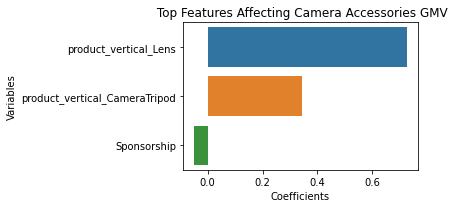

In [305]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (6,3)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title(' Top Features Affecting Camera Accessories GMV')
plt.tight_layout()
plt.show()

### **Gaming Accessories**

***Without Feature Selection***

In [306]:
lr_gaming_mult = LinearRegression().fit(X_train_gaming_mult,y_train_gaming_mult)

In [307]:
y_test_pred_gaming_mult = lr_gaming_mult.predict(X_test_gaming_mult)

In [308]:
print('R2 Score: ',r2_score(y_test_gaming_mult, y_test_pred_gaming_mult))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming_mult, y_test_pred_gaming_mult))

R2 Score:  0.963633633098015
Mean Squared Error:  0.058762181098484086


**Trying Cross Validation on our Dataset**

In [309]:
y_gaming_mult = gaming_data_mult.pop('gmv')
X_gaming_mult = gaming_data_mult

In [310]:
gaming_mult_model_cv = LinearRegression().fit(X_gaming_mult, y_gaming_mult)

In [311]:
gaming_mult_predictions_cv = cross_val_predict(gaming_mult_model_cv, X_gaming_mult, y_gaming_mult,cv=10)

In [312]:
r_squared = metrics.r2_score(y_gaming_mult, gaming_mult_predictions_cv)

In [313]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.7071662045267619


***R-squared using CV is much lower, so we will stick to the normal train-test split***

***With Feature Selection***

**Using RFE**


In [314]:
lr_gaming_mult_rfe = LinearRegression()

In [315]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_gaming_mult_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_gaming_mult, y_train_gaming_mult)

In [316]:
list(zip(X_train_gaming_mult.columns, rfe.support_, rfe.ranking_))

[('sla', False, 11),
 ('product_procurement_sla', False, 5),
 ('list_price', True, 1),
 ('list_price_MA_5', True, 1),
 ('list_price_MA_3', False, 49),
 ('discount', False, 22),
 ('discount_MA_5', False, 28),
 ('discount_MA_3', False, 54),
 ('Pay_day', False, 45),
 ('is_special_saleday_holiday', False, 23),
 ('is_cod', True, 1),
 ('is_premium', False, 6),
 ('product_vertical_GameControlMount', False, 62),
 ('product_vertical_GamePad', True, 1),
 ('product_vertical_GamingAccessoryKit', True, 1),
 ('product_vertical_GamingAdapter', False, 7),
 ('product_vertical_GamingChargingStation', False, 8),
 ('product_vertical_GamingGun', False, 63),
 ('product_vertical_GamingHeadset', True, 1),
 ('product_vertical_GamingKeyboard', False, 13),
 ('product_vertical_GamingMemoryCard', False, 58),
 ('product_vertical_GamingMouse', False, 2),
 ('product_vertical_GamingMousePad', False, 35),
 ('product_vertical_GamingSpeaker', False, 10),
 ('product_vertical_JoystickGamingWheel', False, 18),
 ('product_ve

In [317]:
col = X_train_gaming_mult.columns[rfe.support_]

In [318]:
X_train_gaming_mult.columns[~rfe.support_]

Index(['sla', 'product_procurement_sla', 'list_price_MA_3', 'discount',
       'discount_MA_5', 'discount_MA_3', 'Pay_day',
       'is_special_saleday_holiday', 'is_premium',
       'product_vertical_GameControlMount', 'product_vertical_GamingAdapter',
       'product_vertical_GamingChargingStation', 'product_vertical_GamingGun',
       'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard',
       'product_vertical_GamingMouse', 'product_vertical_GamingMousePad',
       'product_vertical_GamingSpeaker',
       'product_vertical_JoystickGamingWheel',
       'product_vertical_MotionController',
       'product_vertical_TVOutCableAccessory', 'max_temp_c', 'min_temp_c',
       'mean_temp_c', 'heat_deg_days_c', 'cool_deg_days_c', 'total_rain_mm',
       'total_snow_cm', 'total_precip_mm', 'snow_on_grnd_cm', 'NPS_MA_5',
       'NPS_MA_3', 'Stock Index', 'Stock Index_MA_5', 'Stock Index_MA_3',
       'Total_Investment', 'Total_Investment_MA_5', 'Total_Investment_MA_3',
      

In [319]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_mult[col]
y = y_train_gaming_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1474.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.55e-27
Time:                        15:54:56   Log-Likelihood:                 81.675
No. Observations:                  36   AIC:                            -131.3
Df Residuals:                      20   BIC:                            -106.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [320]:
col = col.drop(['product_vertical_GamingAccessoryKit'], 1)
col

Index(['list_price', 'list_price_MA_5', 'is_cod', 'product_vertical_GamePad',
       'product_vertical_GamingHeadset', 'NPS', 'Digital',
       'Content_Marketing_MA_3', 'Online_marketing', 'Online_marketing_MA_3',
       'Affiliates', 'Affiliates_MA_5', 'SEM', 'Radio_adstock'],
      dtype='object')

In [321]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_mult[col]
y = y_train_gaming_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1462.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.06e-28
Time:                        15:54:56   Log-Likelihood:                 79.413
No. Observations:                  36   AIC:                            -128.8
Df Residuals:                      21   BIC:                            -105.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [322]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_gaming_mult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_gaming_mult[col].values, i) for i in range(X_train_gaming_mult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,Online_marketing,6400.51
10,Affiliates,5701.58
9,Online_marketing_MA_3,260.45
11,Affiliates_MA_5,70.48
12,SEM,57.99
5,NPS,56.59
4,product_vertical_GamingHeadset,52.46
7,Content_Marketing_MA_3,32.27
6,Digital,31.66
2,is_cod,29.92


In [323]:
col = col.drop(['Online_marketing'], 1)
col

Index(['list_price', 'list_price_MA_5', 'is_cod', 'product_vertical_GamePad',
       'product_vertical_GamingHeadset', 'NPS', 'Digital',
       'Content_Marketing_MA_3', 'Online_marketing_MA_3', 'Affiliates',
       'Affiliates_MA_5', 'SEM', 'Radio_adstock'],
      dtype='object')

In [324]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_mult[col]
y = y_train_gaming_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     600.9
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           6.30e-25
Time:                        15:54:56   Log-Likelihood:                 61.264
No. Observations:                  36   AIC:                            -94.53
Df Residuals:                      22   BIC:                            -72.36
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [325]:
col = col.drop(['is_cod','NPS','Digital','Content_Marketing_MA_3','Affiliates','SEM','Radio_adstock'], 1)
col

Index(['list_price', 'list_price_MA_5', 'product_vertical_GamePad',
       'product_vertical_GamingHeadset', 'Online_marketing_MA_3',
       'Affiliates_MA_5'],
      dtype='object')

In [326]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_mult[col]
y = y_train_gaming_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1259.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.13e-33
Time:                        15:54:56   Log-Likelihood:                 55.701
No. Observations:                  36   AIC:                            -97.40
Df Residuals:                      29   BIC:                            -86.32
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [327]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_gaming_mult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_gaming_mult[col].values, i) for i in range(X_train_gaming_mult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Online_marketing_MA_3,31.66
5,Affiliates_MA_5,27.62
3,product_vertical_GamingHeadset,18.66
2,product_vertical_GamePad,13.85
1,list_price_MA_5,9.64
0,list_price,1.20


In [328]:
col = col.drop(['Online_marketing_MA_3'], 1)
col

Index(['list_price', 'list_price_MA_5', 'product_vertical_GamePad',
       'product_vertical_GamingHeadset', 'Affiliates_MA_5'],
      dtype='object')

In [329]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_mult[col]
y = y_train_gaming_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1057.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           9.18e-33
Time:                        15:54:57   Log-Likelihood:                 48.701
No. Observations:                  36   AIC:                            -85.40
Df Residuals:                      30   BIC:                            -75.90
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [330]:
col = col.drop(['list_price_MA_5','Affiliates_MA_5'], 1)
col

Index(['list_price', 'product_vertical_GamePad',
       'product_vertical_GamingHeadset'],
      dtype='object')

In [331]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_mult[col]
y = y_train_gaming_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1483.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.11e-34
Time:                        15:54:57   Log-Likelihood:                 44.461
No. Observations:                  36   AIC:                            -80.92
Df Residuals:                      32   BIC:                            -74.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [332]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_gaming_mult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_gaming_mult[col].values, i) for i in range(X_train_gaming_mult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,product_vertical_GamingHeadset,4.76
1,product_vertical_GamePad,4.66
0,list_price,1.11


**Use these 3 variables to build the final model**

In [333]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_gaming_mult_rfe = LinearRegression()
lr_gaming_mult_rfe.fit(X_train_gaming_mult[col], y_train_gaming_mult)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [334]:
y_pred_rf_gaming_mult = lr_gaming_mult_rfe.predict(X_test_gaming_mult[col])

In [335]:
print('R2 Score: ',r2_score(y_test_gaming_mult, y_pred_rf_gaming_mult))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming_mult, y_pred_rf_gaming_mult))

R2 Score:  0.994681305286978
Mean Squared Error:  0.008594152469959558


In [336]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_gaming_mult_rfe.coef_, lr_gaming_mult_rfe.intercept_)

[0.11993237 0.64745396 0.37120447] -0.014326594061048623


In [337]:
# intercept
intercept_df = pd.DataFrame(lr_gaming_mult_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [338]:
# Coefficients 
coefficients = lr_gaming_mult_rfe.coef_.reshape((3, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_gaming_mult[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [339]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
1,product_vertical_GamePad,0.647
2,product_vertical_GamingHeadset,0.371
0,list_price,0.120


**TOP VARIABLES AFFECTING GMV OF GAMING ACCESSORIES**


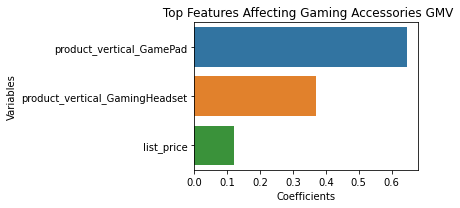

In [340]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (6,3)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title(' Top Features Affecting Gaming Accessories GMV')
plt.tight_layout()
plt.show()

### **Home Audio**

***Without Feature Selection***


In [341]:
lr_homeaudio_mult = LinearRegression().fit(X_train_homeaudio_mult,y_train_homeaudio_mult)

In [342]:
y_test_pred_homeaudio_mult = lr_homeaudio_mult.predict(X_test_homeaudio_mult)

In [343]:
print('R2 Score: ',r2_score(y_test_homeaudio_mult, y_test_pred_homeaudio_mult))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio_mult, y_test_pred_homeaudio_mult))

R2 Score:  0.9519758138690184
Mean Squared Error:  0.13157263288458038


**Trying Cross Validation on our Dataset**


In [344]:
y_homeaudio_mult = homeaudio_data_mult.pop('gmv')
X_homeaudio_mult = homeaudio_data_mult

In [345]:
homeaudio_mult_model_cv = LinearRegression().fit(X_homeaudio_mult, y_homeaudio_mult)

In [346]:
homeaudio_mult_predictions_cv = cross_val_predict(homeaudio_mult_model_cv, X_homeaudio_mult, y_homeaudio_mult,cv=10)

In [347]:
r_squared = metrics.r2_score(y_homeaudio_mult, homeaudio_mult_predictions_cv)

In [348]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.8093967348298188


***With Feature Selection***


**Using RFE**


In [349]:
lr_homeaudio_mult_rfe = LinearRegression()

In [350]:
rfe = RFE(lr_homeaudio_mult_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_homeaudio_mult, y_train_homeaudio_mult)

In [351]:
list(zip(X_train_homeaudio_mult.columns, rfe.support_, rfe.ranking_))

[('sla', True, 1),
 ('product_procurement_sla', True, 1),
 ('list_price', False, 25),
 ('list_price_MA_5', False, 6),
 ('list_price_MA_3', False, 39),
 ('discount', False, 35),
 ('discount_MA_5', False, 23),
 ('discount_MA_3', False, 31),
 ('Pay_day', False, 28),
 ('is_special_saleday_holiday', False, 18),
 ('is_cod', True, 1),
 ('is_premium', True, 1),
 ('product_vertical_Dock', False, 27),
 ('product_vertical_DockingStation', True, 1),
 ('product_vertical_FMRadio', True, 1),
 ('product_vertical_HiFiSystem', False, 34),
 ('product_vertical_HomeAudioSpeaker', True, 1),
 ('product_vertical_VoiceRecorder', False, 16),
 ('max_temp_c', True, 1),
 ('min_temp_c', False, 4),
 ('mean_temp_c', False, 21),
 ('heat_deg_days_c', False, 10),
 ('cool_deg_days_c', False, 37),
 ('total_rain_mm', False, 15),
 ('total_snow_cm', False, 3),
 ('total_precip_mm', False, 14),
 ('snow_on_grnd_cm', False, 48),
 ('NPS', False, 8),
 ('NPS_MA_5', False, 32),
 ('NPS_MA_3', False, 47),
 ('Stock Index', False, 22),


In [352]:
col = X_train_homeaudio_mult.columns[rfe.support_]

In [353]:
X_train_homeaudio_mult.columns[~rfe.support_]

Index(['list_price', 'list_price_MA_5', 'list_price_MA_3', 'discount',
       'discount_MA_5', 'discount_MA_3', 'Pay_day',
       'is_special_saleday_holiday', 'product_vertical_Dock',
       'product_vertical_HiFiSystem', 'product_vertical_VoiceRecorder',
       'min_temp_c', 'mean_temp_c', 'heat_deg_days_c', 'cool_deg_days_c',
       'total_rain_mm', 'total_snow_cm', 'total_precip_mm', 'snow_on_grnd_cm',
       'NPS', 'NPS_MA_5', 'NPS_MA_3', 'Stock Index', 'Stock Index_MA_5',
       'Stock Index_MA_3', 'Total_Investment', 'Total_Investment_MA_3', 'TV',
       'TV_MA_5', 'TV_MA_3', 'Digital', 'Digital_MA_5', 'Sponsorship_MA_5',
       'Sponsorship_MA_3', 'Content_Marketing', 'Content_Marketing_MA_3',
       'Online_marketing', 'Online_marketing_MA_5', 'Online_marketing_MA_3',
       'Affiliates', 'Affiliates_MA_5', 'Affiliates_MA_3', 'SEM_MA_3', 'Radio',
       'Radio_MA_5', 'Radio_MA_3', 'TV_adstock', 'Digital_adstock',
       'Sponsorship_adstock', 'Content_Marketing_adstock',
     

In [354]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_mult[col]
y = y_train_homeaudio_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     478.3
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.74e-19
Time:                        15:54:57   Log-Likelihood:                 81.925
No. Observations:                  33   AIC:                            -131.8
Df Residuals:                      17   BIC:                            -107.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [355]:
col = col.drop(['sla','SEM_adstock'], 1)
col

Index(['product_procurement_sla', 'is_cod', 'is_premium',
       'product_vertical_DockingStation', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'max_temp_c',
       'Total_Investment_MA_5', 'Digital_MA_3', 'Sponsorship',
       'Content_Marketing_MA_5', 'SEM', 'SEM_MA_5'],
      dtype='object')

In [356]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_mult[col]
y = y_train_homeaudio_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     512.8
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.55e-21
Time:                        15:54:57   Log-Likelihood:                 78.884
No. Observations:                  33   AIC:                            -129.8
Df Residuals:                      19   BIC:                            -108.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [357]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_homeaudio_mult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_homeaudio_mult[col].values, i) for i in range(X_train_homeaudio_mult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,product_vertical_HomeAudioSpeaker,23.19
2,is_premium,14.21
12,SEM_MA_5,12.99
7,Total_Investment_MA_5,12.30
9,Sponsorship,6.99
0,product_procurement_sla,5.33
8,Digital_MA_3,5.08
11,SEM,4.91
4,product_vertical_FMRadio,3.90
1,is_cod,3.29


In [358]:
col = col.drop(['product_vertical_HomeAudioSpeaker'], 1)
col

Index(['product_procurement_sla', 'is_cod', 'is_premium',
       'product_vertical_DockingStation', 'product_vertical_FMRadio',
       'max_temp_c', 'Total_Investment_MA_5', 'Digital_MA_3', 'Sponsorship',
       'Content_Marketing_MA_5', 'SEM', 'SEM_MA_5'],
      dtype='object')

In [359]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_mult[col]
y = y_train_homeaudio_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     132.2
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.53e-16
Time:                        15:54:57   Log-Likelihood:                 54.517
No. Observations:                  33   AIC:                            -83.03
Df Residuals:                      20   BIC:                            -63.58
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [360]:
col = col.drop(['max_temp_c'], 1)
col

Index(['product_procurement_sla', 'is_cod', 'is_premium',
       'product_vertical_DockingStation', 'product_vertical_FMRadio',
       'Total_Investment_MA_5', 'Digital_MA_3', 'Sponsorship',
       'Content_Marketing_MA_5', 'SEM', 'SEM_MA_5'],
      dtype='object')

In [361]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_mult[col]
y = y_train_homeaudio_mult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     149.5
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.27e-17
Time:                        15:54:57   Log-Likelihood:                 54.303
No. Observations:                  33   AIC:                            -84.61
Df Residuals:                      21   BIC:                            -66.65
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [362]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_homeaudio_mult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_homeaudio_mult[col].values, i) for i in range(X_train_homeaudio_mult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,SEM_MA_5,8.32
5,Total_Investment_MA_5,5.77
2,is_premium,5.47
7,Sponsorship,4.47
6,Digital_MA_3,4.45
0,product_procurement_sla,4.26
9,SEM,4.20
4,product_vertical_FMRadio,3.58
3,product_vertical_DockingStation,2.91
1,is_cod,2.55


**Using 11 variables on the final model**

In [363]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_homeaudio_mult_rfe = LinearRegression()
lr_homeaudio_mult_rfe.fit(X_train_homeaudio_mult[col], y_train_homeaudio_mult)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [364]:
y_pred_rf_homeaudio_mult = lr_homeaudio_mult_rfe.predict(X_test_homeaudio_mult[col])

In [365]:
print('R2 Score: ',r2_score(y_test_homeaudio_mult, y_pred_rf_homeaudio_mult))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio_mult, y_pred_rf_homeaudio_mult))

R2 Score:  0.9894870213309117
Mean Squared Error:  0.02880257625144902


In [366]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_homeaudio_mult_rfe.coef_, lr_homeaudio_mult_rfe.intercept_)

[-0.08341369  0.08522224  0.41607414  0.04335546  0.42857122  0.13863928
  0.07545834 -0.11669045  0.05635034  0.05409051 -0.14194005] -0.016039357161557105


In [367]:
# intercept
intercept_df = pd.DataFrame(lr_homeaudio_mult_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [368]:
# Coefficients 
coefficients = lr_homeaudio_mult_rfe.coef_.reshape((11, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_homeaudio_mult[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [369]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
4,product_vertical_FMRadio,0.429
2,is_premium,0.416
5,Total_Investment_MA_5,0.139
1,is_cod,0.085
6,Digital_MA_3,0.075
8,Content_Marketing_MA_5,0.056
9,SEM,0.054
3,product_vertical_DockingStation,0.043
0,product_procurement_sla,-0.083
7,Sponsorship,-0.117


**TOP VARIABLES AFFECTING GMV OF HOMEAUDIO**


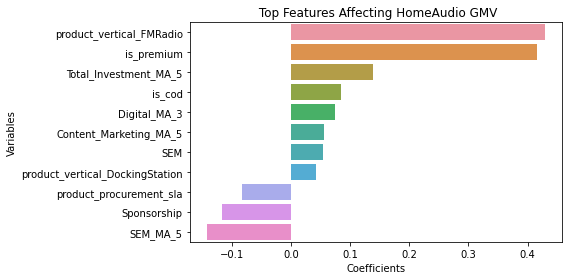

In [370]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (8,4)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title(' Top Features Affecting HomeAudio GMV')
plt.tight_layout()
plt.show()

## **KOYCK MODEL**

***Here, we take note of the fact that the current gmv is dependent on the past gmv. So, we take a lag of the dependent variable.***

In [371]:
# Creating a copy of the three dfs to use in the Koyck model
camera_data_koyck = camera_data.copy()
gaming_data_koyck = gaming_data.copy()
homeaudio_data_koyck = homeaudio_data.copy()

In [372]:
# Creating lag variable function for the dependent variable and all lags we will use in future
def Lag_variables(df,var,n):
  for i in var:
    loc_index = df.columns.get_loc(i) + 1
    df.insert(loc=loc_index,column= i+'_Lag_'+np.str(n),value=df[i].shift(-n))
    return df

In [373]:
# Taking 1st lag of gmv for all the three dfs
col = ['gmv']
camera_data_koyck = Lag_variables(camera_data_koyck,col,1) 
gaming_data_koyck = Lag_variables(gaming_data_koyck,col,1) 
homeaudio_data_koyck = Lag_variables(homeaudio_data_koyck,col,1) 

In [374]:
#Filling all the missing values with '0'
camera_data_koyck.fillna(0, inplace = True)
gaming_data_koyck.fillna(0, inplace = True)
homeaudio_data_koyck.fillna(0, inplace = True)

In [375]:
# We can remove week from all the three dataframes now as we will not need it in the model
camera_data_koyck = camera_data_koyck.drop('Week',axis = 1)
gaming_data_koyck = gaming_data_koyck.drop('Week',axis = 1)
homeaudio_data_koyck = homeaudio_data_koyck.drop('Week',axis = 1)

In [376]:
# Scaling the variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

camera_data_koyck[camera_data_koyck.columns]=scaler.fit_transform(camera_data_koyck[camera_data_koyck.columns])
gaming_data_koyck[gaming_data_koyck.columns]=scaler.fit_transform(gaming_data_koyck[gaming_data_koyck.columns])
homeaudio_data_koyck[homeaudio_data_koyck.columns]=scaler.fit_transform(homeaudio_data_koyck[homeaudio_data_koyck.columns])

In [377]:
#Dividing into Train and Test sets
from sklearn.model_selection import train_test_split
#Camera
camera_train, camera_test = train_test_split(camera_data_koyck, train_size=0.7, test_size=0.3, random_state=100)

#Gaming
gaming_train, gaming_test = train_test_split(gaming_data_koyck, train_size=0.7, test_size=0.3, random_state=100)

#HomeAudio
homeaudio_train, homeaudio_test = train_test_split(homeaudio_data_koyck, train_size=0.7, test_size=0.3, random_state=100)

In [378]:
# Putting feature variable to X and response variable to Y
#Camera
y_train_camera_koyck = camera_train.pop('gmv')
X_train_camera_koyck = camera_train

y_test_camera_koyck = camera_test.pop('gmv')
X_test_camera_koyck = camera_test

#Gaming
y_train_gaming_koyck = gaming_train.pop('gmv')
X_train_gaming_koyck = gaming_train

y_test_gaming_koyck = gaming_test.pop('gmv')
X_test_gaming_koyck = gaming_test

#Home Audio
y_train_homeaudio_koyck = homeaudio_train.pop('gmv')
X_train_homeaudio_koyck = homeaudio_train

y_test_homeaudio_koyck = homeaudio_test.pop('gmv')
X_test_homeaudio_koyck = homeaudio_test

### **Camera Accessories**

***Without Feature Selection***


In [379]:
lr_camera_koyck = LinearRegression().fit(X_train_camera_koyck,y_train_camera_koyck)

In [380]:
y_test_pred_camera_koyck = lr_camera_koyck.predict(X_test_camera_koyck)

In [381]:
print('R2 Score: ',r2_score(y_test_camera_koyck, y_test_pred_camera_koyck))
print('Mean Squared Error: ',mean_squared_error(y_test_camera_koyck, y_test_pred_camera_koyck))

R2 Score:  0.9123308368965709
Mean Squared Error:  0.11261660800031956


**Trying Cross Validation on our Dataset**

In [382]:
y_camera_koyck = camera_data_koyck.pop('gmv')
X_camera_koyck = camera_data_koyck

In [383]:
camera_koyck_model_cv = LinearRegression().fit(X_camera_koyck, y_camera_koyck)

In [384]:
camera_koyck_predictions_cv = cross_val_predict(camera_koyck_model_cv, X_camera_koyck, y_camera_koyck,cv=10)

In [385]:
r_squared = metrics.r2_score(y_camera_koyck, camera_koyck_predictions_cv)

In [386]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.8486533093071944


***With Feature Selection***


**Using RFE**


In [387]:
lr_camera_koyck_rfe = LinearRegression()

In [388]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_camera_koyck_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_camera_koyck, y_train_camera_koyck)

In [389]:
list(zip(X_train_camera_koyck.columns, rfe.support_, rfe.ranking_))

[('gmv_Lag_1', False, 56),
 ('sla', False, 26),
 ('product_procurement_sla', False, 13),
 ('list_price', False, 34),
 ('list_price_MA_5', True, 1),
 ('list_price_MA_3', False, 32),
 ('discount', False, 35),
 ('discount_MA_5', False, 38),
 ('discount_MA_3', False, 49),
 ('Pay_day', False, 3),
 ('is_special_saleday_holiday', False, 11),
 ('is_cod', False, 4),
 ('is_premium', False, 15),
 ('product_vertical_CameraAccessory', False, 57),
 ('product_vertical_CameraBag', True, 1),
 ('product_vertical_CameraBattery', True, 1),
 ('product_vertical_CameraBatteryCharger', True, 1),
 ('product_vertical_CameraBatteryGrip', False, 68),
 ('product_vertical_CameraEyeCup', False, 8),
 ('product_vertical_CameraFilmRolls', False, 33),
 ('product_vertical_CameraHousing', True, 1),
 ('product_vertical_CameraMicrophone', True, 1),
 ('product_vertical_CameraMount', False, 16),
 ('product_vertical_CameraRemoteControl', True, 1),
 ('product_vertical_CameraTripod', True, 1),
 ('product_vertical_ExtensionTube',

In [390]:
col = X_train_camera_koyck.columns[rfe.support_]

In [391]:
X_train_camera_koyck.columns[~rfe.support_]

Index(['gmv_Lag_1', 'sla', 'product_procurement_sla', 'list_price',
       'list_price_MA_3', 'discount', 'discount_MA_5', 'discount_MA_3',
       'Pay_day', 'is_special_saleday_holiday', 'is_cod', 'is_premium',
       'product_vertical_CameraAccessory',
       'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup',
       'product_vertical_CameraFilmRolls', 'product_vertical_CameraMount',
       'product_vertical_ExtensionTube', 'product_vertical_Filter',
       'product_vertical_FlashShoeAdapter',
       'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox',
       'product_vertical_Strap', 'product_vertical_Telescope', 'max_temp_c',
       'min_temp_c', 'mean_temp_c', 'heat_deg_days_c', 'cool_deg_days_c',
       'total_rain_mm', 'total_precip_mm', 'snow_on_grnd_cm', 'NPS_MA_5',
       'NPS_MA_3', 'Stock Index', 'Stock Index_MA_3', 'Total_Investment',
       'Total_Investment_MA_5', 'Total_Investment_MA_3', 'TV', 'TV_MA_5',
       'TV_MA_3', 'Digital', 'Digi

In [392]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_koyck[col]
y = y_train_camera_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     276.5
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.53e-19
Time:                        15:54:59   Log-Likelihood:                 47.788
No. Observations:                  35   AIC:                            -63.58
Df Residuals:                      19   BIC:                            -38.69
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [393]:
col = col.drop(['product_vertical_CameraBag','product_vertical_CameraHousing','product_vertical_CameraMicrophone'], 1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'total_snow_cm',
       'NPS', 'Stock Index_MA_5', 'Sponsorship', 'Radio'],
      dtype='object')

In [394]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_koyck[col]
y = y_train_camera_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     270.7
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.41e-21
Time:                        15:54:59   Log-Likelihood:                 40.985
No. Observations:                  35   AIC:                            -55.97
Df Residuals:                      22   BIC:                            -35.75
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [395]:
col = col.drop(['total_snow_cm'], 1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Stock Index_MA_5', 'Sponsorship', 'Radio'],
      dtype='object')

In [396]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_koyck[col]
y = y_train_camera_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     266.5
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.59e-21
Time:                        15:54:59   Log-Likelihood:                 38.431
No. Observations:                  35   AIC:                            -52.86
Df Residuals:                      23   BIC:                            -34.20
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [397]:
col = col.drop(['Radio'], 1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Stock Index_MA_5', 'Sponsorship'],
      dtype='object')

In [398]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_koyck[col]
y = y_train_camera_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     261.7
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.58e-22
Time:                        15:54:59   Log-Likelihood:                 35.722
No. Observations:                  35   AIC:                            -49.44
Df Residuals:                      24   BIC:                            -32.33
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [399]:
col = col.drop(['product_vertical_CameraBatteryCharger'], 1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Stock Index_MA_5', 'Sponsorship'],
      dtype='object')

In [400]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_koyck[col]
y = y_train_camera_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     275.9
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           9.76e-23
Time:                        15:54:59   Log-Likelihood:                 34.106
No. Observations:                  35   AIC:                            -48.21
Df Residuals:                      25   BIC:                            -32.66
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [401]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera_koyck[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera_koyck[col].values, i) for i in range(X_train_camera_koyck[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,Stock Index_MA_5,17.77
0,list_price_MA_5,15.98
4,product_vertical_Flash,5.34
2,product_vertical_CameraRemoteControl,4.31
5,product_vertical_Lens,4.27
8,Sponsorship,3.23
1,product_vertical_CameraBattery,3.20
6,NPS,3.05
3,product_vertical_CameraTripod,2.39


In [402]:
col = col.drop(['Stock Index_MA_5'], 1)
col

Index(['list_price_MA_5', 'product_vertical_CameraBattery',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Sponsorship'],
      dtype='object')

In [403]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_koyck[col]
y = y_train_camera_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     245.6
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.74e-22
Time:                        15:54:59   Log-Likelihood:                 29.374
No. Observations:                  35   AIC:                            -40.75
Df Residuals:                      26   BIC:                            -26.75
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [404]:
col = col.drop(['list_price_MA_5'], 1)
col

Index(['product_vertical_CameraBattery',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Lens', 'NPS',
       'Sponsorship'],
      dtype='object')

In [405]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_koyck[col]
y = y_train_camera_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     253.6
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           6.16e-23
Time:                        15:54:59   Log-Likelihood:                 26.974
No. Observations:                  35   AIC:                            -37.95
Df Residuals:                      27   BIC:                            -25.51
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [406]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera_koyck[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera_koyck[col].values, i) for i in range(X_train_camera_koyck[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,product_vertical_CameraRemoteControl,4.15
4,product_vertical_Lens,3.96
3,product_vertical_Flash,2.88
6,Sponsorship,2.55
0,product_vertical_CameraBattery,2.43
5,NPS,2.32
2,product_vertical_CameraTripod,2.11


***Using these 7 variables for our final model***

In [407]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_camera_koyck_rfe = LinearRegression()
lr_camera_koyck_rfe.fit(X_train_camera_koyck[col], y_train_camera_koyck)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [408]:
y_pred_rf_camera_koyck = lr_camera_koyck_rfe.predict(X_test_camera_koyck[col])

In [409]:
print('R2 Score: ',r2_score(y_test_camera_koyck, y_pred_rf_camera_koyck))
print('Mean Squared Error: ',mean_squared_error(y_test_camera_koyck, y_pred_rf_camera_koyck))

R2 Score:  0.919421135996422
Mean Squared Error:  0.10350866849152199


In [410]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_camera_koyck_rfe.coef_, lr_camera_koyck_rfe.intercept_)

[ 0.4717513   0.11479068  0.20928012  0.28810656  0.18840666 -0.17900837
 -0.13710761] 0.05786218884331389


In [411]:
# intercept
intercept_df = pd.DataFrame(lr_camera_koyck_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [412]:
# Coefficients 
coefficients = lr_camera_koyck_rfe.coef_.reshape((7, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_camera_koyck[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [413]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
0,product_vertical_CameraBattery,0.472
3,product_vertical_Flash,0.288
2,product_vertical_CameraTripod,0.209
4,product_vertical_Lens,0.188
1,product_vertical_CameraRemoteControl,0.115
6,Sponsorship,-0.137
5,NPS,-0.179


**TOP VARIABLES AFFECTING GMV OF CAMERA ACCESSORIES**


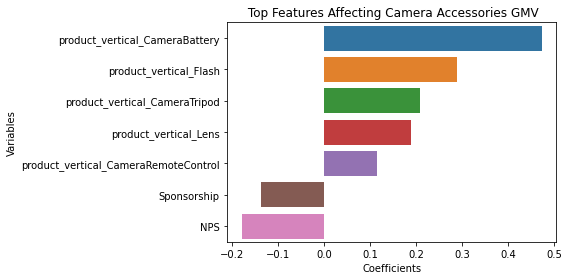

In [414]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (8,4)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title(' Top Features Affecting Camera Accessories GMV')
plt.tight_layout()
plt.show()

### **Gaming Accessories**

***Without Feature Selection***


In [415]:
lr_gaming_koyck = LinearRegression().fit(X_train_gaming_koyck,y_train_gaming_koyck)

In [416]:
y_test_pred_gaming_koyck = lr_gaming_koyck.predict(X_test_gaming_koyck)

In [417]:
print('R2 Score: ',r2_score(y_test_gaming_koyck, y_test_pred_gaming_koyck))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming_koyck, y_test_pred_gaming_koyck))

R2 Score:  0.7392228016444156
Mean Squared Error:  0.28754997264612575


**Trying Cross Validation on our Dataset**


In [418]:
y_gaming_koyck = gaming_data_koyck.pop('gmv')
X_gaming_koyck = gaming_data_koyck

In [419]:
gaming_koyck_model_cv = LinearRegression().fit(X_gaming_koyck, y_gaming_koyck)

In [420]:
gaming_koyck_predictions_cv = cross_val_predict(gaming_koyck_model_cv, X_gaming_koyck, y_gaming_koyck,cv=10)

In [421]:
r_squared = metrics.r2_score(y_gaming_koyck, gaming_koyck_predictions_cv)

In [422]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.08026998660773721


***With Feature Selection***


**Using RFE**


In [423]:
lr_gaming_koyck_rfe = LinearRegression()

In [424]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_gaming_koyck_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_gaming_koyck, y_train_gaming_koyck)

In [425]:
list(zip(X_train_gaming_koyck.columns, rfe.support_, rfe.ranking_))

[('gmv_Lag_1', False, 60),
 ('sla', False, 11),
 ('product_procurement_sla', False, 19),
 ('list_price', True, 1),
 ('list_price_MA_5', False, 35),
 ('list_price_MA_3', True, 1),
 ('discount', False, 63),
 ('discount_MA_5', False, 22),
 ('discount_MA_3', False, 50),
 ('Pay_day', False, 21),
 ('is_special_saleday_holiday', True, 1),
 ('is_cod', False, 37),
 ('is_premium', False, 4),
 ('product_vertical_GameControlMount', False, 46),
 ('product_vertical_GamePad', False, 12),
 ('product_vertical_GamingAccessoryKit', True, 1),
 ('product_vertical_GamingAdapter', False, 15),
 ('product_vertical_GamingChargingStation', True, 1),
 ('product_vertical_GamingGun', False, 62),
 ('product_vertical_GamingHeadset', True, 1),
 ('product_vertical_GamingKeyboard', True, 1),
 ('product_vertical_GamingMemoryCard', True, 1),
 ('product_vertical_GamingMouse', False, 8),
 ('product_vertical_GamingMousePad', False, 7),
 ('product_vertical_GamingSpeaker', False, 9),
 ('product_vertical_JoystickGamingWheel', F

In [426]:
col = X_train_gaming_koyck.columns[rfe.support_]

In [427]:
X_train_gaming_koyck.columns[~rfe.support_]

Index(['gmv_Lag_1', 'sla', 'product_procurement_sla', 'list_price_MA_5',
       'discount', 'discount_MA_5', 'discount_MA_3', 'Pay_day', 'is_cod',
       'is_premium', 'product_vertical_GameControlMount',
       'product_vertical_GamePad', 'product_vertical_GamingAdapter',
       'product_vertical_GamingGun', 'product_vertical_GamingMouse',
       'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker',
       'product_vertical_JoystickGamingWheel',
       'product_vertical_MotionController',
       'product_vertical_TVOutCableAccessory', 'max_temp_c', 'min_temp_c',
       'mean_temp_c', 'cool_deg_days_c', 'total_snow_cm', 'total_precip_mm',
       'snow_on_grnd_cm', 'NPS', 'NPS_MA_5', 'Stock Index', 'Stock Index_MA_5',
       'Stock Index_MA_3', 'Total_Investment', 'Total_Investment_MA_5',
       'Total_Investment_MA_3', 'TV', 'TV_MA_5', 'TV_MA_3', 'Sponsorship',
       'Sponsorship_MA_5', 'Sponsorship_MA_3', 'Content_Marketing',
       'Content_Marketing_MA_5', 'Content_M

In [428]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_koyck[col]
y = y_train_gaming_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     311.0
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.47e-20
Time:                        15:55:00   Log-Likelihood:                 48.031
No. Observations:                  36   AIC:                            -64.06
Df Residuals:                      20   BIC:                            -38.73
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [429]:
col = col.drop(['NPS_MA_3','Digital_MA_3'], 1)
col

Index(['list_price', 'list_price_MA_3', 'is_special_saleday_holiday',
       'product_vertical_GamingAccessoryKit',
       'product_vertical_GamingChargingStation',
       'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard',
       'product_vertical_GamingMemoryCard', 'heat_deg_days_c', 'total_rain_mm',
       'Digital', 'Digital_MA_5', 'Online_marketing_MA_3'],
      dtype='object')

In [430]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_koyck[col]
y = y_train_gaming_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     341.6
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           3.04e-22
Time:                        15:55:00   Log-Likelihood:                 45.440
No. Observations:                  36   AIC:                            -62.88
Df Residuals:                      22   BIC:                            -40.71
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [431]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_gaming_koyck[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_gaming_koyck[col].values, i) for i in range(X_train_gaming_koyck[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,Online_marketing_MA_3,7.12
5,product_vertical_GamingHeadset,4.63
6,product_vertical_GamingKeyboard,4.00
8,heat_deg_days_c,3.84
10,Digital,3.08
4,product_vertical_GamingChargingStation,2.78
7,product_vertical_GamingMemoryCard,2.78
2,is_special_saleday_holiday,2.71
1,list_price_MA_3,2.60
3,product_vertical_GamingAccessoryKit,2.48


In [432]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_gaming_koyck_rfe = LinearRegression()
lr_gaming_koyck_rfe.fit(X_train_gaming_koyck[col], y_train_gaming_koyck)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [433]:
y_pred_rf_gaming_koyck = lr_gaming_koyck_rfe.predict(X_test_gaming_koyck[col])

In [434]:
print('R2 Score: ',r2_score(y_test_gaming_koyck, y_pred_rf_gaming_koyck))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming_koyck, y_pred_rf_gaming_koyck))

R2 Score:  0.6843660394088888
Mean Squared Error:  0.34803862188290413


R-squared on the test set is 0.68

In [435]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_gaming_koyck_rfe.coef_, lr_gaming_koyck_rfe.intercept_)

[ 0.16439065  0.24536236  0.07975192  0.32006207  0.10068461  0.37118503
  0.3749276   0.11112048 -0.25934096  0.18075057 -0.08983845 -0.08021899
  0.35123038] -0.011680567572481648


In [436]:
# intercept
intercept_df = pd.DataFrame(lr_gaming_koyck_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [437]:
# Coefficients 
coefficients = lr_gaming_koyck_rfe.coef_.reshape((13, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_gaming_koyck[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [438]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
6,product_vertical_GamingKeyboard,0.375
5,product_vertical_GamingHeadset,0.371
12,Online_marketing_MA_3,0.351
3,product_vertical_GamingAccessoryKit,0.320
1,list_price_MA_3,0.245
9,total_rain_mm,0.181
0,list_price,0.164
7,product_vertical_GamingMemoryCard,0.111
4,product_vertical_GamingChargingStation,0.101
2,is_special_saleday_holiday,0.080


**TOP VARIABLES AFFECTING GMV OF GAMING ACCESSORIES**


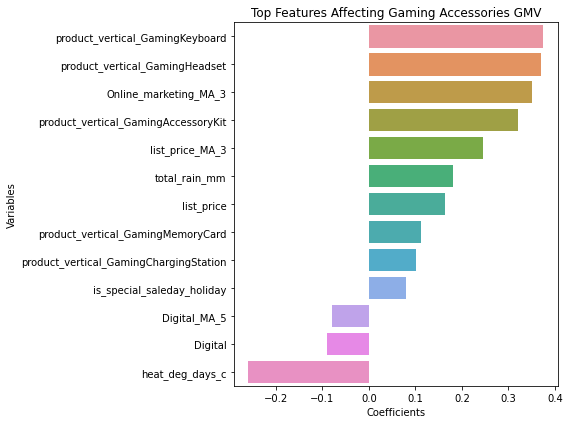

In [439]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (8,6)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title('Top Features Affecting Gaming Accessories GMV')
plt.tight_layout()
plt.show()

### **Home Audio**

***Without Feature Selection***


In [440]:
lr_homeaudio_koyck = LinearRegression().fit(X_train_homeaudio_koyck,y_train_homeaudio_koyck)

In [441]:
y_test_pred_homeaudio_koyck = lr_homeaudio_koyck.predict(X_test_homeaudio_koyck)

In [442]:
print('R2 Score: ',r2_score(y_test_homeaudio_koyck, y_test_pred_homeaudio_koyck))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio_koyck, y_test_pred_homeaudio_koyck))

R2 Score:  0.9243188913058948
Mean Squared Error:  0.20791054618513302


**Trying Cross Validation on our Dataset**


In [443]:
y_homeaudio_koyck = homeaudio_data_koyck.pop('gmv')
X_homeaudio_koyck = homeaudio_data_koyck

In [444]:
homeaudio_koyck_model_cv = LinearRegression().fit(X_homeaudio_koyck, y_homeaudio_koyck)

In [445]:
homeaudio_koyck_predictions_cv = cross_val_predict(homeaudio_koyck_model_cv, X_homeaudio_koyck, y_homeaudio_koyck,cv=10)

In [446]:
r_squared = metrics.r2_score(y_homeaudio_koyck, homeaudio_koyck_predictions_cv)

In [447]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.9625651811440696


***With Feature Selection***


**Using RFE**


In [448]:
lr_homeaudio_koyck_rfe = LinearRegression()

from sklearn.feature_selection import RFE
rfe = RFE(lr_homeaudio_koyck_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_homeaudio_koyck, y_train_homeaudio_koyck)

In [449]:
list(zip(X_train_homeaudio_koyck.columns, rfe.support_, rfe.ranking_))

[('gmv_Lag_1', False, 40),
 ('sla', False, 44),
 ('product_procurement_sla', True, 1),
 ('list_price', True, 1),
 ('list_price_MA_5', False, 22),
 ('list_price_MA_3', False, 47),
 ('discount', False, 14),
 ('discount_MA_5', False, 46),
 ('discount_MA_3', False, 15),
 ('Pay_day', False, 19),
 ('is_special_saleday_holiday', False, 48),
 ('is_cod', False, 9),
 ('is_premium', True, 1),
 ('product_vertical_Dock', False, 7),
 ('product_vertical_DockingStation', False, 52),
 ('product_vertical_FMRadio', True, 1),
 ('product_vertical_HiFiSystem', False, 53),
 ('product_vertical_HomeAudioSpeaker', True, 1),
 ('product_vertical_VoiceRecorder', True, 1),
 ('max_temp_c', False, 16),
 ('min_temp_c', False, 3),
 ('mean_temp_c', False, 6),
 ('heat_deg_days_c', False, 39),
 ('cool_deg_days_c', False, 33),
 ('total_rain_mm', False, 45),
 ('total_snow_cm', False, 17),
 ('total_precip_mm', False, 20),
 ('snow_on_grnd_cm', False, 34),
 ('NPS', False, 13),
 ('NPS_MA_5', False, 12),
 ('NPS_MA_3', True, 1),


In [450]:
col = X_train_homeaudio_koyck.columns[rfe.support_]

In [451]:
X_train_homeaudio_koyck.columns[~rfe.support_]

Index(['gmv_Lag_1', 'sla', 'list_price_MA_5', 'list_price_MA_3', 'discount',
       'discount_MA_5', 'discount_MA_3', 'Pay_day',
       'is_special_saleday_holiday', 'is_cod', 'product_vertical_Dock',
       'product_vertical_DockingStation', 'product_vertical_HiFiSystem',
       'max_temp_c', 'min_temp_c', 'mean_temp_c', 'heat_deg_days_c',
       'cool_deg_days_c', 'total_rain_mm', 'total_snow_cm', 'total_precip_mm',
       'snow_on_grnd_cm', 'NPS', 'NPS_MA_5', 'Stock Index', 'Stock Index_MA_5',
       'Total_Investment', 'Total_Investment_MA_5', 'Total_Investment_MA_3',
       'TV', 'TV_MA_5', 'TV_MA_3', 'Digital', 'Digital_MA_5', 'Digital_MA_3',
       'Sponsorship', 'Sponsorship_MA_5', 'Content_Marketing',
       'Content_Marketing_MA_5', 'Content_Marketing_MA_3',
       'Online_marketing_MA_5', 'Online_marketing_MA_3', 'Affiliates',
       'Affiliates_MA_5', 'Affiliates_MA_3', 'SEM', 'SEM_MA_5', 'SEM_MA_3',
       'Radio', 'TV_adstock', 'Sponsorship_adstock',
       'Content_Marke

In [452]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_koyck[col]
y = y_train_homeaudio_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1529.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.44e-23
Time:                        15:55:01   Log-Likelihood:                 99.030
No. Observations:                  33   AIC:                            -166.1
Df Residuals:                      17   BIC:                            -142.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [453]:
col = col.drop(['Sponsorship_MA_3','Online_marketing','SEM_adstock'], 1)
col

Index(['product_procurement_sla', 'list_price', 'is_premium',
       'product_vertical_FMRadio', 'product_vertical_HomeAudioSpeaker',
       'product_vertical_VoiceRecorder', 'NPS_MA_3', 'Stock Index_MA_3',
       'Radio_MA_5', 'Radio_MA_3', 'Digital_adstock', 'Radio_adstock'],
      dtype='object')

In [454]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_koyck[col]
y = y_train_homeaudio_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1807.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.32e-27
Time:                        15:55:01   Log-Likelihood:                 95.430
No. Observations:                  33   AIC:                            -164.9
Df Residuals:                      20   BIC:                            -145.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [455]:
col = col.drop(['NPS_MA_3','product_procurement_sla','Stock Index_MA_3'], 1)
col

Index(['list_price', 'is_premium', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder',
       'Radio_MA_5', 'Radio_MA_3', 'Digital_adstock', 'Radio_adstock'],
      dtype='object')

In [456]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_koyck[col]
y = y_train_homeaudio_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1930.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           6.44e-31
Time:                        15:55:01   Log-Likelihood:                 89.469
No. Observations:                  33   AIC:                            -158.9
Df Residuals:                      23   BIC:                            -144.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [457]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_homeaudio_koyck[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_homeaudio_koyck[col].values, i) for i in range(X_train_homeaudio_koyck[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,Radio_MA_3,42.53
8,Radio_adstock,38.49
3,product_vertical_HomeAudioSpeaker,12.53
1,is_premium,10.26
5,Radio_MA_5,7.45
2,product_vertical_FMRadio,4.27
0,list_price,4.08
4,product_vertical_VoiceRecorder,4.02
7,Digital_adstock,1.64


In [458]:
col = col.drop(['Radio_MA_3'], 1)
col

Index(['list_price', 'is_premium', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder',
       'Radio_MA_5', 'Digital_adstock', 'Radio_adstock'],
      dtype='object')

In [459]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_koyck[col]
y = y_train_homeaudio_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1623.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           7.04e-31
Time:                        15:55:01   Log-Likelihood:                 83.976
No. Observations:                  33   AIC:                            -150.0
Df Residuals:                      24   BIC:                            -136.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [460]:
col = col.drop(['Radio_adstock','Digital_adstock','Radio_MA_5','is_premium'], 1)
col

Index(['list_price', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder'],
      dtype='object')

In [461]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_koyck[col]
y = y_train_homeaudio_koyck

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2503.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.57e-35
Time:                        15:55:01   Log-Likelihood:                 77.160
No. Observations:                  33   AIC:                            -144.3
Df Residuals:                      28   BIC:                            -136.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [462]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_homeaudio_koyck[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_homeaudio_koyck[col].values, i) for i in range(X_train_homeaudio_koyck[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,product_vertical_HomeAudioSpeaker,3.30
0,list_price,3.08
1,product_vertical_FMRadio,2.16
3,product_vertical_VoiceRecorder,1.56


In [463]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_homeaudio_koyck_rfe = LinearRegression()
lr_homeaudio_koyck_rfe.fit(X_train_homeaudio_koyck[col], y_train_homeaudio_koyck)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [464]:
y_pred_rf_homeaudio_koyck = lr_homeaudio_koyck_rfe.predict(X_test_homeaudio_koyck[col])

In [465]:
print('R2 Score: ',r2_score(y_test_homeaudio_koyck, y_pred_rf_homeaudio_koyck))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio_koyck, y_pred_rf_homeaudio_koyck))

R2 Score:  0.9757189557326561
Mean Squared Error:  0.06670469371654525


In [466]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_homeaudio_koyck_rfe.coef_, lr_homeaudio_koyck_rfe.intercept_)

[0.11313269 0.20606013 0.66410972 0.02889709] -0.006954841703644146


In [467]:
# intercept
intercept_df = pd.DataFrame(lr_homeaudio_koyck_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [468]:
# Coefficients 
coefficients = lr_homeaudio_koyck_rfe.coef_.reshape((4, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_homeaudio_koyck[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [469]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
2,product_vertical_HomeAudioSpeaker,0.664
1,product_vertical_FMRadio,0.206
0,list_price,0.113
3,product_vertical_VoiceRecorder,0.029


**TOP VARIABLES AFFECTING GMV OF HOMEAUDIO**


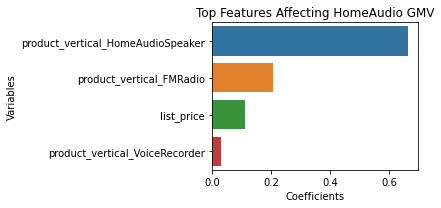

In [470]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (6,3)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title('Top Features Affecting HomeAudio GMV')
plt.tight_layout()
plt.show()

## **DISTRIBUTIVE LAG MODEL**

### ***Additive Model***

In [471]:
# Creating a copy of the three dfs to use in the first model
camera_data_lagadd = camera_data.copy()
gaming_data_lagadd = gaming_data.copy()
homeaudio_data_lagadd = homeaudio_data.copy()

In [472]:
# We can remove week from all the three dataframes now as we will not need it in the model
camera_data_lagadd = camera_data_lagadd.drop('Week',axis = 1)
gaming_data_lagadd = gaming_data_lagadd.drop('Week',axis = 1)
homeaudio_data_lagadd = homeaudio_data_lagadd.drop('Week',axis = 1)

In [473]:
col_list_camera = camera_data_lagadd.columns
col_list_gaming = gaming_data_lagadd.columns
col_list_homeaudio = homeaudio_data_lagadd.columns

In [474]:
# Creating Lag of 1 week
camera_data_lagadd = Lag_variables(camera_data_lagadd,col_list_camera,1)
gaming_data_lagadd = Lag_variables(gaming_data_lagadd,col_list_gaming,1)
homeaudio_data_lagadd = Lag_variables(homeaudio_data_lagadd,col_list_homeaudio,1)

In [475]:
# Creating Lag of 2 weeks
camera_data_lagadd = Lag_variables(camera_data_lagadd,col_list_camera,2)
gaming_data_lagadd = Lag_variables(gaming_data_lagadd,col_list_gaming,2)
homeaudio_data_lagadd = Lag_variables(homeaudio_data_lagadd,col_list_homeaudio,2)

In [476]:
# Creating Lag of 3 weeks
camera_data_lagadd = Lag_variables(camera_data_lagadd,col_list_camera,3)
gaming_data_lagadd = Lag_variables(gaming_data_lagadd,col_list_gaming,3)
homeaudio_data_lagadd = Lag_variables(homeaudio_data_lagadd,col_list_homeaudio,3)

In [477]:
#Filling all the missing values with '0'
camera_data_lagadd.fillna(0, inplace = True)
gaming_data_lagadd.fillna(0, inplace = True)
homeaudio_data_lagadd.fillna(0, inplace = True)

In [478]:
# Scaling the variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

camera_data_lagadd[camera_data_lagadd.columns]=scaler.fit_transform(camera_data_lagadd[camera_data_lagadd.columns])
gaming_data_lagadd[gaming_data_lagadd.columns]=scaler.fit_transform(gaming_data_lagadd[gaming_data_lagadd.columns])
homeaudio_data_lagadd[homeaudio_data_lagadd.columns]=scaler.fit_transform(homeaudio_data_lagadd[homeaudio_data_lagadd.columns])

In [479]:
#Dividing into Train and Test sets
from sklearn.model_selection import train_test_split
#Camera
camera_train, camera_test = train_test_split(camera_data_lagadd, train_size=0.7, test_size=0.3, random_state=100)

#Gaming
gaming_train, gaming_test = train_test_split(gaming_data_lagadd, train_size=0.7, test_size=0.3, random_state=100)

#HomeAudio
homeaudio_train, homeaudio_test = train_test_split(homeaudio_data_lagadd, train_size=0.7, test_size=0.3, random_state=100)


# Putting feature variable to X and response variable to Y
#Camera
y_train_camera_lagadd = camera_train.pop('gmv')
X_train_camera_lagadd = camera_train

y_test_camera_lagadd = camera_test.pop('gmv')
X_test_camera_lagadd = camera_test

#Gaming
y_train_gaming_lagadd = gaming_train.pop('gmv')
X_train_gaming_lagadd = gaming_train

y_test_gaming_lagadd = gaming_test.pop('gmv')
X_test_gaming_lagadd = gaming_test

#Home Audio
y_train_homeaudio_lagadd = homeaudio_train.pop('gmv')
X_train_homeaudio_lagadd = homeaudio_train

y_test_homeaudio_lagadd = homeaudio_test.pop('gmv')
X_test_homeaudio_lagadd = homeaudio_test

### **Camera Accessories**

***Without Feature Selection***

In [480]:
lr_camera_lagadd = LinearRegression().fit(X_train_camera_lagadd,y_train_camera_lagadd)

In [481]:
y_test_pred_camera_lagadd = lr_camera_lagadd.predict(X_test_camera_lagadd)

In [482]:
print('R2 Score: ',r2_score(y_test_camera_lagadd, y_test_pred_camera_lagadd))
print('Mean Squared Error: ',mean_squared_error(y_test_camera_lagadd, y_test_pred_camera_lagadd))

R2 Score:  0.9238823607955815
Mean Squared Error:  0.0977779418982325


**Trying Cross Validation on our Dataset**


In [483]:
y_camera_lagadd= camera_data_lagadd.pop('gmv')
X_camera_lagadd = camera_data_lagadd

In [484]:
camera_lagadd_model_cv = LinearRegression().fit(X_camera_lagadd, y_camera_lagadd)

In [485]:
camera_lagadd_predictions_cv = cross_val_predict(camera_lagadd_model_cv, X_camera_lagadd, y_camera_lagadd,cv=10)

In [486]:
r_squared = metrics.r2_score(y_camera_lagadd, camera_lagadd_predictions_cv)

In [487]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.8902558288141774


***With Feature Selection***


**Using RFE**


In [488]:
lr_camera_lagadd_rfe = LinearRegression()

In [489]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_camera_lagadd_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_camera_lagadd, y_train_camera_lagadd)

In [490]:
list(zip(X_train_camera_lagadd.columns, rfe.support_, rfe.ranking_))

[('gmv_Lag_3', False, 7),
 ('gmv_Lag_2', False, 25),
 ('gmv_Lag_1', False, 68),
 ('sla', False, 14),
 ('product_procurement_sla', True, 1),
 ('list_price', False, 58),
 ('list_price_MA_5', False, 28),
 ('list_price_MA_3', False, 49),
 ('discount', False, 27),
 ('discount_MA_5', False, 37),
 ('discount_MA_3', False, 31),
 ('Pay_day', False, 53),
 ('is_special_saleday_holiday', False, 9),
 ('is_cod', True, 1),
 ('is_premium', True, 1),
 ('product_vertical_CameraAccessory', False, 10),
 ('product_vertical_CameraBag', True, 1),
 ('product_vertical_CameraBattery', True, 1),
 ('product_vertical_CameraBatteryCharger', False, 8),
 ('product_vertical_CameraBatteryGrip', False, 60),
 ('product_vertical_CameraEyeCup', False, 6),
 ('product_vertical_CameraFilmRolls', False, 46),
 ('product_vertical_CameraHousing', False, 11),
 ('product_vertical_CameraMicrophone', True, 1),
 ('product_vertical_CameraMount', False, 24),
 ('product_vertical_CameraRemoteControl', True, 1),
 ('product_vertical_CameraT

In [491]:
col = X_train_camera_lagadd.columns[rfe.support_]

In [492]:
X_train_camera_lagadd.columns[~rfe.support_]

Index(['gmv_Lag_3', 'gmv_Lag_2', 'gmv_Lag_1', 'sla', 'list_price',
       'list_price_MA_5', 'list_price_MA_3', 'discount', 'discount_MA_5',
       'discount_MA_3', 'Pay_day', 'is_special_saleday_holiday',
       'product_vertical_CameraAccessory',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup',
       'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing',
       'product_vertical_CameraMount', 'product_vertical_ExtensionTube',
       'product_vertical_Filter', 'product_vertical_FlashShoeAdapter',
       'product_vertical_Lens', 'product_vertical_ReflectorUmbrella',
       'product_vertical_Strap', 'max_temp_c', 'mean_temp_c',
       'heat_deg_days_c', 'cool_deg_days_c', 'total_rain_mm',
       'total_precip_mm', 'snow_on_grnd_cm', 'NPS', 'NPS_MA_5', 'NPS_MA_3',
       'Stock Index', 'Stock Index_MA_5', 'Stock Index_MA_3',
       'Total_Investment', 'Total_Investment_MA_5', 'Total_Investment_MA

In [493]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_lagadd[col]
y = y_train_camera_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     611.0
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           3.08e-22
Time:                        15:55:02   Log-Likelihood:                 61.618
No. Observations:                  35   AIC:                            -91.24
Df Residuals:                      19   BIC:                            -66.35
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [494]:
col = col.drop(['min_temp_c','product_vertical_CameraBattery'], 1)
col

Index(['product_procurement_sla', 'is_cod', 'is_premium',
       'product_vertical_CameraBag', 'product_vertical_CameraMicrophone',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Softbox',
       'product_vertical_Telescope', 'total_snow_cm', 'TV_MA_5', 'TV_MA_3'],
      dtype='object')

In [495]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_lagadd[col]
y = y_train_camera_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     662.3
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.16e-24
Time:                        15:55:02   Log-Likelihood:                 58.780
No. Observations:                  35   AIC:                            -89.56
Df Residuals:                      21   BIC:                            -67.79
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [496]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera_lagadd[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera_lagadd[col].values, i) for i in range(X_train_camera_lagadd[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,TV_MA_5,21.05
12,TV_MA_3,16.29
7,product_vertical_Flash,10.53
1,is_cod,9.32
3,product_vertical_CameraBag,7.23
9,product_vertical_Telescope,6.96
5,product_vertical_CameraRemoteControl,5.09
2,is_premium,4.46
6,product_vertical_CameraTripod,3.99
4,product_vertical_CameraMicrophone,3.09


In [497]:
col = col.drop(['TV_MA_5'], 1)
col

Index(['product_procurement_sla', 'is_cod', 'is_premium',
       'product_vertical_CameraBag', 'product_vertical_CameraMicrophone',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Flash', 'product_vertical_Softbox',
       'product_vertical_Telescope', 'total_snow_cm', 'TV_MA_3'],
      dtype='object')

In [498]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_lagadd[col]
y = y_train_camera_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     439.1
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.75e-23
Time:                        15:55:02   Log-Likelihood:                 49.405
No. Observations:                  35   AIC:                            -72.81
Df Residuals:                      22   BIC:                            -52.59
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [499]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera_lagadd[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera_lagadd[col].values, i) for i in range(X_train_camera_lagadd[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,product_vertical_CameraBag,7.23
7,product_vertical_Flash,6.61
9,product_vertical_Telescope,6.36
1,is_cod,5.54
5,product_vertical_CameraRemoteControl,5.09
2,is_premium,3.99
6,product_vertical_CameraTripod,3.38
4,product_vertical_CameraMicrophone,3.02
11,TV_MA_3,1.99
10,total_snow_cm,1.84


Using these 12 variables to check their performance on the test set

In [500]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_camera_lagadd_rfe = LinearRegression()
lr_camera_lagadd_rfe.fit(X_train_camera_lagadd[col], y_train_camera_lagadd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [501]:
y_pred_rf_camera_lagadd = lr_camera_lagadd_rfe.predict(X_test_camera_lagadd[col])

In [502]:
print('R2 Score: ',r2_score(y_test_camera_lagadd, y_pred_rf_camera_lagadd))
print('Mean Squared Error: ',mean_squared_error(y_test_camera_lagadd, y_pred_rf_camera_lagadd))

R2 Score:  0.8423926543649223
Mean Squared Error:  0.20245664533624572


The R-squared is 0.84, which is quite good

In [503]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_camera_lagadd_rfe.coef_, lr_camera_lagadd_rfe.intercept_)

[ 0.2020996   0.07374688  0.24417812  0.22969999  0.12744014  0.05851651
  0.16918921  0.27321538 -0.08267203  0.09900862 -0.04716388  0.04255392] 0.019951609013557525


In [504]:
# intercept
intercept_df = pd.DataFrame(lr_camera_lagadd_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [505]:
# Coefficients 
coefficients = lr_camera_lagadd_rfe.coef_.reshape((12, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]
linear_features = list(X_test_camera_lagadd[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [506]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
7,product_vertical_Flash,0.273
2,is_premium,0.244
3,product_vertical_CameraBag,0.230
0,product_procurement_sla,0.202
6,product_vertical_CameraTripod,0.169
4,product_vertical_CameraMicrophone,0.127
9,product_vertical_Telescope,0.099
1,is_cod,0.074
5,product_vertical_CameraRemoteControl,0.059
11,TV_MA_3,0.043


**TOP VARIABLES AFFECTING GMV OF CAMERA ACCESSORIES**

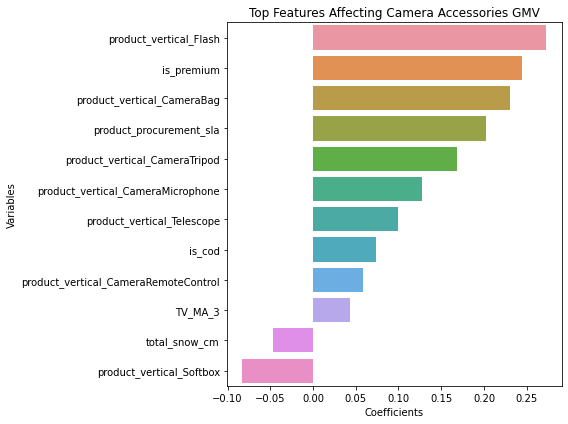

In [507]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (8,6)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title('Top Features Affecting Camera Accessories GMV')
plt.tight_layout()
plt.show()

### **Gaming Accessories**

***Without Feature Selection***


In [508]:
lr_gaming_lagadd = LinearRegression().fit(X_train_gaming_lagadd,y_train_gaming_lagadd)

In [509]:
y_test_pred_gaming_lagadd = lr_gaming_lagadd.predict(X_test_gaming_lagadd)

In [510]:
print('R2 Score: ',r2_score(y_test_gaming_lagadd, y_test_pred_gaming_lagadd))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming_lagadd, y_test_pred_gaming_lagadd))

R2 Score:  0.7145750251834242
Mean Squared Error:  0.3147282209432859


**Trying Cross Validation on our Dataset**


In [511]:
y_gaming_lagadd = gaming_data_lagadd.pop('gmv')
X_gaming_lagadd = gaming_data_lagadd

In [512]:
gaming_lagadd_model_cv = LinearRegression().fit(X_gaming_lagadd, y_gaming_lagadd)

In [513]:
gaming_lagadd_predictions_cv = cross_val_predict(gaming_lagadd_model_cv, X_gaming_lagadd, y_gaming_lagadd,cv=10)

In [514]:
r_squared = metrics.r2_score(y_gaming_lagadd, gaming_lagadd_predictions_cv)

In [515]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.27523313847863884


***With Feature Selection***


**Using RFE**


In [516]:
lr_gaming_lagadd_rfe = LinearRegression()

In [517]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_gaming_lagadd_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_gaming_lagadd, y_train_gaming_lagadd)

In [518]:
list(zip(X_train_gaming_lagadd.columns, rfe.support_, rfe.ranking_))

[('gmv_Lag_3', False, 61),
 ('gmv_Lag_2', False, 17),
 ('gmv_Lag_1', False, 56),
 ('sla', True, 1),
 ('product_procurement_sla', False, 8),
 ('list_price', True, 1),
 ('list_price_MA_5', False, 38),
 ('list_price_MA_3', True, 1),
 ('discount', False, 45),
 ('discount_MA_5', False, 52),
 ('discount_MA_3', False, 48),
 ('Pay_day', False, 19),
 ('is_special_saleday_holiday', False, 2),
 ('is_cod', False, 47),
 ('is_premium', False, 5),
 ('product_vertical_GameControlMount', False, 42),
 ('product_vertical_GamePad', True, 1),
 ('product_vertical_GamingAccessoryKit', True, 1),
 ('product_vertical_GamingAdapter', False, 25),
 ('product_vertical_GamingChargingStation', False, 6),
 ('product_vertical_GamingGun', False, 18),
 ('product_vertical_GamingHeadset', True, 1),
 ('product_vertical_GamingKeyboard', True, 1),
 ('product_vertical_GamingMemoryCard', True, 1),
 ('product_vertical_GamingMouse', True, 1),
 ('product_vertical_GamingMousePad', False, 62),
 ('product_vertical_GamingSpeaker', Fal

In [519]:
col = X_train_gaming_lagadd.columns[rfe.support_]

In [520]:
X_train_gaming_lagadd.columns[~rfe.support_]

Index(['gmv_Lag_3', 'gmv_Lag_2', 'gmv_Lag_1', 'product_procurement_sla',
       'list_price_MA_5', 'discount', 'discount_MA_5', 'discount_MA_3',
       'Pay_day', 'is_special_saleday_holiday', 'is_cod', 'is_premium',
       'product_vertical_GameControlMount', 'product_vertical_GamingAdapter',
       'product_vertical_GamingChargingStation', 'product_vertical_GamingGun',
       'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker',
       'product_vertical_MotionController', 'max_temp_c', 'min_temp_c',
       'heat_deg_days_c', 'cool_deg_days_c', 'total_snow_cm',
       'total_precip_mm', 'snow_on_grnd_cm', 'NPS', 'NPS_MA_5', 'Stock Index',
       'Stock Index_MA_5', 'Stock Index_MA_3', 'Total_Investment',
       'Total_Investment_MA_5', 'Total_Investment_MA_3', 'TV', 'TV_MA_5',
       'TV_MA_3', 'Digital', 'Digital_MA_5', 'Digital_MA_3', 'Sponsorship',
       'Sponsorship_MA_5', 'Sponsorship_MA_3', 'Content_Marketing',
       'Content_Marketing_MA_5', 'Content_Marketing_

In [521]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagadd[col]
y = y_train_gaming_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     610.4
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           3.01e-23
Time:                        15:55:03   Log-Likelihood:                 60.129
No. Observations:                  36   AIC:                            -88.26
Df Residuals:                      20   BIC:                            -62.92
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [522]:
col = col.drop(['NPS_MA_3'], 1)
col

Index(['sla', 'list_price', 'list_price_MA_3', 'product_vertical_GamePad',
       'product_vertical_GamingAccessoryKit', 'product_vertical_GamingHeadset',
       'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard',
       'product_vertical_GamingMouse', 'product_vertical_JoystickGamingWheel',
       'product_vertical_TVOutCableAccessory', 'mean_temp_c', 'total_rain_mm',
       'Affiliates_MA_3'],
      dtype='object')

In [523]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagadd[col]
y = y_train_gaming_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     591.4
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.33e-24
Time:                        15:55:03   Log-Likelihood:                 57.447
No. Observations:                  36   AIC:                            -84.89
Df Residuals:                      21   BIC:                            -61.14
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [524]:
col = col.drop(['list_price_MA_3','product_vertical_TVOutCableAccessory'], 1)
col

Index(['sla', 'list_price', 'product_vertical_GamePad',
       'product_vertical_GamingAccessoryKit', 'product_vertical_GamingHeadset',
       'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard',
       'product_vertical_GamingMouse', 'product_vertical_JoystickGamingWheel',
       'mean_temp_c', 'total_rain_mm', 'Affiliates_MA_3'],
      dtype='object')

In [525]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagadd[col]
y = y_train_gaming_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     544.8
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.98e-25
Time:                        15:55:03   Log-Likelihood:                 51.577
No. Observations:                  36   AIC:                            -77.15
Df Residuals:                      23   BIC:                            -56.57
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [526]:
col = col.drop(['total_rain_mm','mean_temp_c'], 1)
col

Index(['sla', 'list_price', 'product_vertical_GamePad',
       'product_vertical_GamingAccessoryKit', 'product_vertical_GamingHeadset',
       'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard',
       'product_vertical_GamingMouse', 'product_vertical_JoystickGamingWheel',
       'Affiliates_MA_3'],
      dtype='object')

In [527]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagadd[col]
y = y_train_gaming_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     581.7
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.07e-27
Time:                        15:55:04   Log-Likelihood:                 47.985
No. Observations:                  36   AIC:                            -73.97
Df Residuals:                      25   BIC:                            -56.55
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [528]:
col = col.drop(['Affiliates_MA_3'], 1)
col

Index(['sla', 'list_price', 'product_vertical_GamePad',
       'product_vertical_GamingAccessoryKit', 'product_vertical_GamingHeadset',
       'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard',
       'product_vertical_GamingMouse', 'product_vertical_JoystickGamingWheel'],
      dtype='object')

In [529]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagadd[col]
y = y_train_gaming_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     623.9
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.93e-28
Time:                        15:55:04   Log-Likelihood:                 46.651
No. Observations:                  36   AIC:                            -73.30
Df Residuals:                      26   BIC:                            -57.47
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [530]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_gaming_lagadd[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_gaming_lagadd[col].values, i) for i in range(X_train_gaming_lagadd[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,product_vertical_GamingAccessoryKit,4.33
7,product_vertical_GamingMouse,3.10
4,product_vertical_GamingHeadset,2.69
2,product_vertical_GamePad,2.51
0,sla,2.41
5,product_vertical_GamingKeyboard,2.19
8,product_vertical_JoystickGamingWheel,1.71
1,list_price,1.52
6,product_vertical_GamingMemoryCard,1.50


Using these 9 variables to see the performance on the test set

In [531]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_gaming_lagadd_rfe = LinearRegression()
lr_gaming_lagadd_rfe.fit(X_train_gaming_lagadd[col], y_train_gaming_lagadd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [532]:
y_pred_rf_gaming_lagadd = lr_gaming_lagadd_rfe.predict(X_test_gaming_lagadd[col])

In [533]:
print('R2 Score: ',r2_score(y_test_gaming_lagadd, y_pred_rf_gaming_lagadd))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming_lagadd, y_pred_rf_gaming_lagadd))

R2 Score:  0.6580031092364194
Mean Squared Error:  0.3771081106946853


In [534]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_gaming_lagadd_rfe.coef_, lr_gaming_lagadd_rfe.intercept_)

[-0.12060362  0.3792896   0.22422578  0.15096909  0.4959991   0.06404776
  0.13196866  0.23253143  0.03771096] 0.04703727764765439


In [535]:
# intercept
intercept_df = pd.DataFrame(lr_gaming_lagadd_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [536]:
# Coefficients 
coefficients = lr_gaming_lagadd_rfe.coef_.reshape((9, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_gaming_lagadd[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [537]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
4,product_vertical_GamingHeadset,0.496
1,list_price,0.379
7,product_vertical_GamingMouse,0.233
2,product_vertical_GamePad,0.224
3,product_vertical_GamingAccessoryKit,0.151
6,product_vertical_GamingMemoryCard,0.132
5,product_vertical_GamingKeyboard,0.064
8,product_vertical_JoystickGamingWheel,0.038
0,sla,-0.121


**TOP VARIABLES AFFECTING GMV OF GAMING ACCESSORIES**


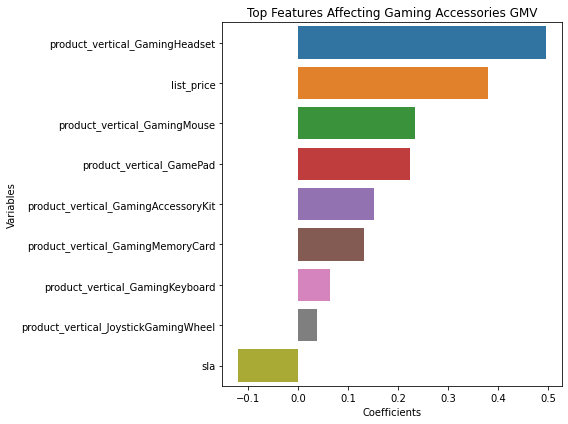

In [538]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (8,6)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title('Top Features Affecting Gaming Accessories GMV')
plt.tight_layout()
plt.show()

### **Home Audio**


***Without Feature Selection***


In [539]:
lr_homeaudio_lagadd = LinearRegression().fit(X_train_homeaudio_lagadd,y_train_homeaudio_lagadd)

In [540]:
y_test_pred_homeaudio_lagadd = lr_homeaudio_lagadd.predict(X_test_homeaudio_lagadd)

In [541]:
print('R2 Score: ',r2_score(y_test_homeaudio_lagadd, y_test_pred_homeaudio_lagadd))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio_lagadd, y_test_pred_homeaudio_lagadd))

R2 Score:  0.8997233072162972
Mean Squared Error:  0.27547934122590784


**Trying Cross Validation on our Dataset**


In [542]:
y_homeaudio_lagadd = homeaudio_data_lagadd.pop('gmv')
X_homeaudio_lagadd = homeaudio_data_lagadd

In [543]:
homeaudio_lagadd_model_cv = LinearRegression().fit(X_homeaudio_lagadd, y_homeaudio_lagadd)

In [544]:
homeaudio_lagadd_predictions_cv = cross_val_predict(homeaudio_lagadd_model_cv, X_homeaudio_lagadd, y_homeaudio_lagadd,cv=10)

In [545]:
r_squared = metrics.r2_score(y_homeaudio_lagadd, homeaudio_lagadd_predictions_cv)

In [546]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.960962470112284


***With Feature Selection***


**Using RFE**


In [547]:
lr_homeaudio_lagadd_rfe = LinearRegression()

In [548]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_homeaudio_lagadd_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_homeaudio_lagadd, y_train_homeaudio_lagadd)

In [549]:
list(zip(X_train_homeaudio_lagadd.columns, rfe.support_, rfe.ranking_))

[('gmv_Lag_3', False, 17),
 ('gmv_Lag_2', False, 8),
 ('gmv_Lag_1', False, 29),
 ('sla', False, 47),
 ('product_procurement_sla', False, 6),
 ('list_price', True, 1),
 ('list_price_MA_5', False, 35),
 ('list_price_MA_3', False, 44),
 ('discount', False, 12),
 ('discount_MA_5', False, 33),
 ('discount_MA_3', True, 1),
 ('Pay_day', False, 5),
 ('is_special_saleday_holiday', False, 10),
 ('is_cod', False, 7),
 ('is_premium', True, 1),
 ('product_vertical_Dock', True, 1),
 ('product_vertical_DockingStation', False, 28),
 ('product_vertical_FMRadio', True, 1),
 ('product_vertical_HiFiSystem', False, 49),
 ('product_vertical_HomeAudioSpeaker', True, 1),
 ('product_vertical_VoiceRecorder', True, 1),
 ('max_temp_c', False, 3),
 ('min_temp_c', False, 18),
 ('mean_temp_c', False, 55),
 ('heat_deg_days_c', False, 27),
 ('cool_deg_days_c', False, 16),
 ('total_rain_mm', False, 40),
 ('total_snow_cm', False, 4),
 ('total_precip_mm', False, 14),
 ('snow_on_grnd_cm', False, 21),
 ('NPS', False, 23),


In [550]:
col = X_train_homeaudio_lagadd.columns[rfe.support_]

In [551]:
X_train_homeaudio_lagadd.columns[~rfe.support_]

Index(['gmv_Lag_3', 'gmv_Lag_2', 'gmv_Lag_1', 'sla', 'product_procurement_sla',
       'list_price_MA_5', 'list_price_MA_3', 'discount', 'discount_MA_5',
       'Pay_day', 'is_special_saleday_holiday', 'is_cod',
       'product_vertical_DockingStation', 'product_vertical_HiFiSystem',
       'max_temp_c', 'min_temp_c', 'mean_temp_c', 'heat_deg_days_c',
       'cool_deg_days_c', 'total_rain_mm', 'total_snow_cm', 'total_precip_mm',
       'snow_on_grnd_cm', 'NPS', 'NPS_MA_5', 'Stock Index', 'Stock Index_MA_3',
       'Total_Investment', 'Total_Investment_MA_5', 'Total_Investment_MA_3',
       'TV', 'TV_MA_5', 'TV_MA_3', 'Digital', 'Digital_MA_3', 'Sponsorship',
       'Sponsorship_MA_5', 'Sponsorship_MA_3', 'Content_Marketing',
       'Content_Marketing_MA_3', 'Online_marketing_MA_5',
       'Online_marketing_MA_3', 'Affiliates', 'Affiliates_MA_5',
       'Affiliates_MA_3', 'SEM_MA_5', 'SEM_MA_3', 'Radio', 'TV_adstock',
       'Digital_adstock', 'Sponsorship_adstock', 'Content_Marketing_a

In [552]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_lagadd[col]
y = y_train_homeaudio_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2450.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.63e-25
Time:                        15:55:04   Log-Likelihood:                 106.81
No. Observations:                  33   AIC:                            -181.6
Df Residuals:                      17   BIC:                            -157.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [553]:
col = col.drop(['discount_MA_3','NPS_MA_3','Digital_MA_5'], 1)
col

Index(['list_price', 'is_premium', 'product_vertical_Dock',
       'product_vertical_FMRadio', 'product_vertical_HomeAudioSpeaker',
       'product_vertical_VoiceRecorder', 'Stock Index_MA_5',
       'Content_Marketing_MA_5', 'Online_marketing', 'SEM', 'Radio_MA_5',
       'Radio_MA_3'],
      dtype='object')

In [554]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_lagadd[col]
y = y_train_homeaudio_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2559.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.09e-29
Time:                        15:55:05   Log-Likelihood:                 101.17
No. Observations:                  33   AIC:                            -176.3
Df Residuals:                      20   BIC:                            -156.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [555]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_homeaudio_lagadd[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_homeaudio_lagadd[col].values, i) for i in range(X_train_homeaudio_lagadd[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,product_vertical_HomeAudioSpeaker,18.59
1,is_premium,11.10
8,Online_marketing,7.31
10,Radio_MA_5,6.98
0,list_price,6.77
11,Radio_MA_3,6.61
3,product_vertical_FMRadio,5.36
5,product_vertical_VoiceRecorder,4.25
9,SEM,4.20
6,Stock Index_MA_5,3.71


In [556]:
col = col.drop(['product_vertical_HomeAudioSpeaker'], 1)
col

Index(['list_price', 'is_premium', 'product_vertical_Dock',
       'product_vertical_FMRadio', 'product_vertical_VoiceRecorder',
       'Stock Index_MA_5', 'Content_Marketing_MA_5', 'Online_marketing', 'SEM',
       'Radio_MA_5', 'Radio_MA_3'],
      dtype='object')

In [557]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_lagadd[col]
y = y_train_homeaudio_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     94.98
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.40e-15
Time:                        15:55:05   Log-Likelihood:                 44.898
No. Observations:                  33   AIC:                            -65.80
Df Residuals:                      21   BIC:                            -47.84
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [558]:
col = col.drop(['product_vertical_Dock','product_vertical_VoiceRecorder','Radio_MA_5','Radio_MA_3'], 1)
col

Index(['list_price', 'is_premium', 'product_vertical_FMRadio',
       'Stock Index_MA_5', 'Content_Marketing_MA_5', 'Online_marketing',
       'SEM'],
      dtype='object')

In [559]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_lagadd[col]
y = y_train_homeaudio_lagadd

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     98.95
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.26e-16
Time:                        15:55:05   Log-Likelihood:                 35.496
No. Observations:                  33   AIC:                            -54.99
Df Residuals:                      25   BIC:                            -43.02
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [560]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_homeaudio_lagadd[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_homeaudio_lagadd[col].values, i) for i in range(X_train_homeaudio_lagadd[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,is_premium,5.90
0,list_price,4.28
2,product_vertical_FMRadio,3.65
5,Online_marketing,3.18
3,Stock Index_MA_5,1.97
4,Content_Marketing_MA_5,1.89
6,SEM,1.81


Using these 7 variables to test the performance

In [561]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_homeaudio_lagadd_rfe = LinearRegression()
lr_homeaudio_lagadd_rfe.fit(X_train_homeaudio_lagadd[col], y_train_homeaudio_lagadd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [562]:
y_pred_rf_homeaudio_lagadd = lr_homeaudio_lagadd_rfe.predict(X_test_homeaudio_lagadd[col])

In [563]:
print('R2 Score: ',r2_score(y_test_homeaudio_lagadd, y_pred_rf_homeaudio_lagadd))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio_lagadd, y_pred_rf_homeaudio_lagadd))

R2 Score:  0.8934448052539004
Mean Squared Error:  0.2927275924044487


In [564]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_homeaudio_lagadd_rfe.coef_, lr_homeaudio_lagadd_rfe.intercept_)

[ 0.2124143   0.39002934  0.31214471 -0.07204897  0.05284547  0.14481327
 -0.1067945 ] -0.013197150271396188


In [565]:
# intercept
intercept_df = pd.DataFrame(lr_homeaudio_lagadd_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [566]:
# Coefficients 
coefficients = lr_homeaudio_lagadd_rfe.coef_.reshape((7, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_homeaudio_lagadd[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [567]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
1,is_premium,0.390
2,product_vertical_FMRadio,0.312
0,list_price,0.212
5,Online_marketing,0.145
4,Content_Marketing_MA_5,0.053
3,Stock Index_MA_5,-0.072
6,SEM,-0.107


**TOP VARIABLES AFFECTING GMV OF HOME AUDIO**


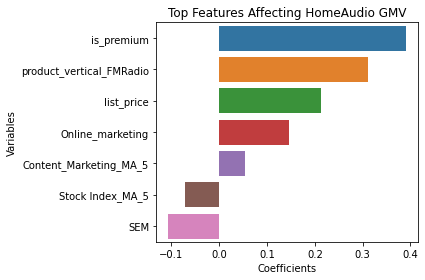

In [568]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (6,4)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title('Top Features Affecting HomeAudio GMV')
plt.tight_layout()
plt.show()

## **DISTRIBUTIVE LAG MODEL**

### ***Multiplicative Model***

In [569]:
#Creating a copy of the three dfs to use in the model
camera_data_lagmult = camera_data.copy()
gaming_data_lagmult = gaming_data.copy()
homeaudio_data_lagmult = homeaudio_data.copy()

In [570]:
# We can remove week from all the three dataframes now as we will not need it in the model
camera_data_lagmult = camera_data_lagmult.drop('Week',axis = 1)
gaming_data_lagmult = gaming_data_lagmult.drop('Week',axis = 1)
homeaudio_data_lagmult = homeaudio_data_lagmult.drop('Week',axis = 1)

In [571]:
# Creating the column list including all columns to form the lag variables
col_list_camera = camera_data_lagmult.columns
col_list_gaming = gaming_data_lagmult.columns
col_list_homeaudio = homeaudio_data_lagmult.columns

In [572]:
# Creating Lag of 1 week
camera_data_lagmult = Lag_variables(camera_data_lagmult,col_list_camera,1)
gaming_data_lagmult = Lag_variables(gaming_data_lagmult,col_list_gaming,1)
homeaudio_data_lagmult = Lag_variables(homeaudio_data_lagmult,col_list_homeaudio,1)

In [573]:
# Creating Lag of 2 weeks
camera_data_lagmult = Lag_variables(camera_data_lagmult,col_list_camera,2)
gaming_data_lagmult = Lag_variables(gaming_data_lagmult,col_list_gaming,2)
homeaudio_data_lagmult = Lag_variables(homeaudio_data_lagmult,col_list_homeaudio,2)

In [574]:
# Creating Lag of 3 weeks
camera_data_lagmult = Lag_variables(camera_data_lagmult,col_list_camera,3)
gaming_data_lagmult = Lag_variables(gaming_data_lagmult,col_list_gaming,3)
homeaudio_data_lagmult = Lag_variables(homeaudio_data_lagmult,col_list_homeaudio,3)

In [575]:
#Filling all the missing values with '0'
camera_data_lagmult.fillna(0, inplace = True)
gaming_data_lagmult.fillna(0, inplace = True)
homeaudio_data_lagmult.fillna(0, inplace = True)

In [576]:
# Taking log of all the three dfs and replacing the infinite and null values with 0
camera_data_lagmult = camera_data_lagmult.applymap(lambda x: np.log(x))
camera_data_lagmult = camera_data_lagmult.replace([np.inf, -np.inf], 0)
camera_data_lagmult = camera_data_lagmult.fillna(0)

gaming_data_lagmult = gaming_data_lagmult.applymap(lambda x: np.log(x))
gaming_data_lagmult = gaming_data_lagmult.replace([np.inf, -np.inf], 0)
gaming_data_lagmult = gaming_data_lagmult.fillna(0)

homeaudio_data_lagmult = homeaudio_data_lagmult.applymap(lambda x: np.log(x))
homeaudio_data_lagmult = homeaudio_data_lagmult.replace([np.inf, -np.inf], 0)
homeaudio_data_lagmult = homeaudio_data_lagmult.fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [577]:
# Scaling the variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

camera_data_lagmult[camera_data_lagmult.columns]=scaler.fit_transform(camera_data_lagmult[camera_data_lagmult.columns])
gaming_data_lagmult[gaming_data_lagmult.columns]=scaler.fit_transform(gaming_data_lagmult[gaming_data_lagmult.columns])
homeaudio_data_lagmult[homeaudio_data_lagmult.columns]=scaler.fit_transform(homeaudio_data_lagmult[homeaudio_data_lagmult.columns])

In [578]:
#Dividing into Train and Test sets
from sklearn.model_selection import train_test_split
#Camera
camera_train, camera_test = train_test_split(camera_data_lagmult, train_size=0.7, test_size=0.3, random_state=100)

#Camera
gaming_train, gaming_test = train_test_split(gaming_data_lagmult, train_size=0.7, test_size=0.3, random_state=100)

#Camera
homeaudio_train, homeaudio_test = train_test_split(homeaudio_data_lagmult, train_size=0.7, test_size=0.3, random_state=100)

In [579]:
# Putting feature variable to X and response variable to Y
#Camera
y_train_camera_lagmult = camera_train.pop('gmv')
X_train_camera_lagmult = camera_train

y_test_camera_lagmult = camera_test.pop('gmv')
X_test_camera_lagmult = camera_test

#Gaming
y_train_gaming_lagmult = gaming_train.pop('gmv')
X_train_gaming_lagmult = gaming_train

y_test_gaming_lagmult = gaming_test.pop('gmv')
X_test_gaming_lagmult = gaming_test

#Home Audio
y_train_homeaudio_lagmult = homeaudio_train.pop('gmv')
X_train_homeaudio_lagmult = homeaudio_train

y_test_homeaudio_lagmult = homeaudio_test.pop('gmv')
X_test_homeaudio_lagmult = homeaudio_test

### **Camera Accessories**


***Without Feature Selection***


In [580]:
lr_camera_lagmult = LinearRegression().fit(X_train_camera_lagmult,y_train_camera_lagmult)

In [581]:
y_test_pred_camera_lagmult = lr_camera_lagmult.predict(X_test_camera_lagmult)

In [582]:
print('R2 Score: ',r2_score(y_test_camera_lagmult, y_test_pred_camera_lagmult))
print('Mean Squared Error: ',mean_squared_error(y_test_camera_lagmult, y_test_pred_camera_lagmult))

R2 Score:  0.9420366300732436
Mean Squared Error:  0.12106519844924021


**Trying Cross Validation on our Dataset**


In [583]:
y_camera_lagmult = camera_data_lagmult.pop('gmv')
X_camera_lagmult = camera_data_lagmult

In [584]:
camera_lagmult_model_cv = LinearRegression().fit(X_camera_lagmult, y_camera_lagmult)

In [585]:
camera_lagmult_predictions_cv = cross_val_predict(camera_lagmult_model_cv, X_camera_lagmult, y_camera_lagmult,cv=10)

In [586]:
r_squared = metrics.r2_score(y_camera_lagmult, camera_lagmult_predictions_cv)

In [587]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.929790679481752


***With Feature Selection***


**Using RFE**


In [588]:
lr_camera_lagmult_rfe = LinearRegression()

In [589]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_camera_lagmult_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_camera_lagmult, y_train_camera_lagmult)

In [590]:
list(zip(X_train_camera_lagmult.columns, rfe.support_, rfe.ranking_))

[('gmv_Lag_3', False, 31),
 ('gmv_Lag_2', False, 68),
 ('gmv_Lag_1', False, 17),
 ('sla', True, 1),
 ('product_procurement_sla', True, 1),
 ('list_price', True, 1),
 ('list_price_MA_5', False, 24),
 ('list_price_MA_3', False, 55),
 ('discount', False, 44),
 ('discount_MA_5', False, 30),
 ('discount_MA_3', False, 40),
 ('Pay_day', False, 61),
 ('is_special_saleday_holiday', False, 23),
 ('is_cod', True, 1),
 ('is_premium', True, 1),
 ('product_vertical_CameraAccessory', False, 7),
 ('product_vertical_CameraBag', True, 1),
 ('product_vertical_CameraBattery', True, 1),
 ('product_vertical_CameraBatteryCharger', True, 1),
 ('product_vertical_CameraBatteryGrip', False, 43),
 ('product_vertical_CameraEyeCup', False, 26),
 ('product_vertical_CameraFilmRolls', False, 5),
 ('product_vertical_CameraHousing', False, 71),
 ('product_vertical_CameraMicrophone', False, 63),
 ('product_vertical_CameraMount', False, 42),
 ('product_vertical_CameraRemoteControl', True, 1),
 ('product_vertical_CameraTri

In [591]:
col = X_train_camera_lagmult.columns[rfe.support_]

In [592]:
X_train_camera_lagmult.columns[~rfe.support_]

Index(['gmv_Lag_3', 'gmv_Lag_2', 'gmv_Lag_1', 'list_price_MA_5',
       'list_price_MA_3', 'discount', 'discount_MA_5', 'discount_MA_3',
       'Pay_day', 'is_special_saleday_holiday',
       'product_vertical_CameraAccessory',
       'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup',
       'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing',
       'product_vertical_CameraMicrophone', 'product_vertical_CameraMount',
       'product_vertical_ExtensionTube', 'product_vertical_Filter',
       'product_vertical_Flash', 'product_vertical_FlashShoeAdapter',
       'product_vertical_Lens', 'product_vertical_ReflectorUmbrella',
       'product_vertical_Softbox', 'max_temp_c', 'min_temp_c', 'mean_temp_c',
       'heat_deg_days_c', 'cool_deg_days_c', 'total_rain_mm', 'total_snow_cm',
       'total_precip_mm', 'snow_on_grnd_cm', 'NPS', 'NPS_MA_5', 'NPS_MA_3',
       'Stock Index', 'Stock Index_MA_5', 'Stock Index_MA_3',
       'Total_Investment', 'Total_Inve

In [593]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_lagmult[col]
y = y_train_camera_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1348.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.71e-25
Time:                        15:55:06   Log-Likelihood:                 87.802
No. Observations:                  35   AIC:                            -143.6
Df Residuals:                      19   BIC:                            -118.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [594]:
col = col.drop(['product_vertical_Strap','product_vertical_CameraBattery','is_premium','product_procurement_sla'], 1)
col

Index(['sla', 'list_price', 'is_cod', 'product_vertical_CameraBag',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod',
       'product_vertical_Telescope', 'TV_MA_3', 'Sponsorship', 'Radio'],
      dtype='object')

In [595]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_lagmult[col]
y = y_train_camera_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1297.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.19e-29
Time:                        15:55:06   Log-Likelihood:                 78.372
No. Observations:                  35   AIC:                            -132.7
Df Residuals:                      23   BIC:                            -114.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [596]:
col = col.drop(['product_vertical_CameraRemoteControl'], 1)
col

Index(['sla', 'list_price', 'is_cod', 'product_vertical_CameraBag',
       'product_vertical_CameraBatteryCharger',
       'product_vertical_CameraTripod', 'product_vertical_Telescope',
       'TV_MA_3', 'Sponsorship', 'Radio'],
      dtype='object')

In [597]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_lagmult[col]
y = y_train_camera_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1287.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           3.13e-30
Time:                        15:55:06   Log-Likelihood:                 75.826
No. Observations:                  35   AIC:                            -129.7
Df Residuals:                      24   BIC:                            -112.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [598]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera_lagmult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera_lagmult[col].values, i) for i in range(X_train_camera_lagmult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,product_vertical_CameraBatteryCharger,29.79
3,product_vertical_CameraBag,25.53
5,product_vertical_CameraTripod,9.47
6,product_vertical_Telescope,6.04
2,is_cod,5.11
7,TV_MA_3,3.10
1,list_price,2.89
8,Sponsorship,2.15
9,Radio,2.04
0,sla,1.84


In [599]:
col = col.drop(['product_vertical_CameraBatteryCharger'], 1)
col

Index(['sla', 'list_price', 'is_cod', 'product_vertical_CameraBag',
       'product_vertical_CameraTripod', 'product_vertical_Telescope',
       'TV_MA_3', 'Sponsorship', 'Radio'],
      dtype='object')

In [600]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_lagmult[col]
y = y_train_camera_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     660.1
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.97e-27
Time:                        15:55:06   Log-Likelihood:                 61.627
No. Observations:                  35   AIC:                            -103.3
Df Residuals:                      25   BIC:                            -87.70
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [601]:
col = col.drop(['list_price'], 1)
col

Index(['sla', 'is_cod', 'product_vertical_CameraBag',
       'product_vertical_CameraTripod', 'product_vertical_Telescope',
       'TV_MA_3', 'Sponsorship', 'Radio'],
      dtype='object')

In [602]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_lagmult[col]
y = y_train_camera_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     665.2
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.69e-28
Time:                        15:55:06   Log-Likelihood:                 59.026
No. Observations:                  35   AIC:                            -100.1
Df Residuals:                      26   BIC:                            -86.05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [603]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera_lagmult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera_lagmult[col].values, i) for i in range(X_train_camera_lagmult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,product_vertical_CameraBag,9.74
3,product_vertical_CameraTripod,7.82
1,is_cod,4.82
4,product_vertical_Telescope,4.01
5,TV_MA_3,2.95
6,Sponsorship,2.07
7,Radio,1.60
0,sla,1.25


In [604]:
col = col.drop(['product_vertical_CameraBag'], 1)
col

Index(['sla', 'is_cod', 'product_vertical_CameraTripod',
       'product_vertical_Telescope', 'TV_MA_3', 'Sponsorship', 'Radio'],
      dtype='object')

In [605]:
import statsmodels.api as sm
from scipy import stats

X = X_train_camera_lagmult[col]
y = y_train_camera_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     129.2
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.42e-19
Time:                        15:55:06   Log-Likelihood:                 27.782
No. Observations:                  35   AIC:                            -39.56
Df Residuals:                      27   BIC:                            -27.12
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [606]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_camera_lagmult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_camera_lagmult[col].values, i) for i in range(X_train_camera_lagmult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,product_vertical_CameraTripod,5.73
1,is_cod,3.95
4,TV_MA_3,2.93
3,product_vertical_Telescope,2.65
5,Sponsorship,1.88
6,Radio,1.47
0,sla,1.25


Using these 7 variables for testing the performance on the test set

In [607]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_camera_lagmult_rfe = LinearRegression()
lr_camera_lagmult_rfe.fit(X_train_camera_lagmult[col], y_train_camera_lagmult)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [608]:
y_pred_rf_camera_lagmult = lr_camera_lagmult_rfe.predict(X_test_camera_lagmult[col])

In [609]:
print('R2 Score: ',r2_score(y_test_camera_lagmult, y_pred_rf_camera_lagmult))
print('Mean Squared Error: ',mean_squared_error(y_test_camera_lagmult, y_pred_rf_camera_lagmult))

R2 Score:  0.9175973646895137
Mean Squared Error:  0.1721102725602457


In [610]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_camera_lagmult_rfe.coef_, lr_camera_lagmult_rfe.intercept_)

[-0.12664781  0.21405478  0.39633764  0.2687873   0.1444622  -0.11216759
  0.07004439] 0.06467061441492895


In [611]:
# intercept
intercept_df = pd.DataFrame(lr_camera_lagmult_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [612]:
# Coefficients 
coefficients = lr_camera_lagmult_rfe.coef_.reshape((7, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_camera_lagmult[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [613]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
2,product_vertical_CameraTripod,0.396
3,product_vertical_Telescope,0.269
1,is_cod,0.214
4,TV_MA_3,0.144
6,Radio,0.070
5,Sponsorship,-0.112
0,sla,-0.127


**TOP VARIABLES AFFECTING GMV OF CAMERA ACCESSORIES**


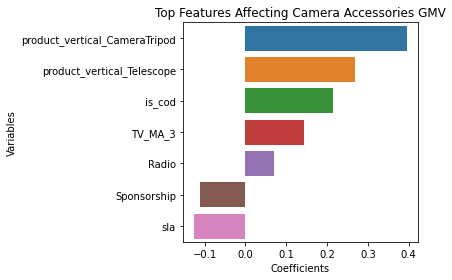

In [614]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (6,4)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title('Top Features Affecting Camera Accessories GMV')
plt.tight_layout()
plt.show()

### **Gaming Accessories**


***Without Feature Selection***


In [615]:
lr_gaming_lagmult = LinearRegression().fit(X_train_gaming_lagmult,y_train_gaming_lagmult)

In [616]:
y_test_pred_gaming_lagmult = lr_gaming_lagmult.predict(X_test_gaming_lagmult)

In [617]:
print('R2 Score: ',r2_score(y_test_gaming_lagmult, y_test_pred_gaming_lagmult))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming_lagmult, y_test_pred_gaming_lagmult))

R2 Score:  0.9623421074531576
Mean Squared Error:  0.06084907814929453


**Trying Cross Validation on our Dataset**


In [618]:
y_gaming_lagmult = gaming_data_lagmult.pop('gmv')
X_gaming_lagmult = gaming_data_lagmult

In [619]:
gaming_lagmult_model_cv = LinearRegression().fit(X_gaming_lagmult, y_gaming_lagmult)

In [620]:
gaming_lagmult_predictions_cv = cross_val_predict(gaming_lagmult_model_cv, X_gaming_lagmult, y_gaming_lagmult,cv=10)

In [621]:
r_squared = metrics.r2_score(y_gaming_lagmult, gaming_lagmult_predictions_cv)

In [622]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.7702662132466684


***With Feature Selection***


**Using RFE**


In [623]:
lr_gaming_lagmult_rfe = LinearRegression()

In [624]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_gaming_lagmult_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_gaming_lagmult, y_train_gaming_lagmult)

In [625]:
list(zip(X_train_gaming_lagmult.columns, rfe.support_, rfe.ranking_))

[('gmv_Lag_3', False, 44),
 ('gmv_Lag_2', False, 11),
 ('gmv_Lag_1', False, 26),
 ('sla', True, 1),
 ('product_procurement_sla', True, 1),
 ('list_price', False, 14),
 ('list_price_MA_5', False, 23),
 ('list_price_MA_3', False, 57),
 ('discount', False, 38),
 ('discount_MA_5', False, 41),
 ('discount_MA_3', False, 64),
 ('Pay_day', False, 48),
 ('is_special_saleday_holiday', True, 1),
 ('is_cod', False, 15),
 ('is_premium', True, 1),
 ('product_vertical_GameControlMount', False, 65),
 ('product_vertical_GamePad', True, 1),
 ('product_vertical_GamingAccessoryKit', True, 1),
 ('product_vertical_GamingAdapter', False, 2),
 ('product_vertical_GamingChargingStation', True, 1),
 ('product_vertical_GamingGun', False, 66),
 ('product_vertical_GamingHeadset', False, 7),
 ('product_vertical_GamingKeyboard', False, 36),
 ('product_vertical_GamingMemoryCard', False, 62),
 ('product_vertical_GamingMouse', True, 1),
 ('product_vertical_GamingMousePad', True, 1),
 ('product_vertical_GamingSpeaker', T

In [626]:
col = X_train_gaming_lagmult.columns[rfe.support_]

In [627]:
X_train_gaming_lagmult.columns[~rfe.support_]

Index(['gmv_Lag_3', 'gmv_Lag_2', 'gmv_Lag_1', 'list_price', 'list_price_MA_5',
       'list_price_MA_3', 'discount', 'discount_MA_5', 'discount_MA_3',
       'Pay_day', 'is_cod', 'product_vertical_GameControlMount',
       'product_vertical_GamingAdapter', 'product_vertical_GamingGun',
       'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard',
       'product_vertical_GamingMemoryCard',
       'product_vertical_JoystickGamingWheel',
       'product_vertical_MotionController',
       'product_vertical_TVOutCableAccessory', 'max_temp_c', 'min_temp_c',
       'mean_temp_c', 'heat_deg_days_c', 'cool_deg_days_c', 'total_rain_mm',
       'total_snow_cm', 'total_precip_mm', 'snow_on_grnd_cm', 'NPS',
       'NPS_MA_5', 'NPS_MA_3', 'Stock Index_MA_5', 'Stock Index_MA_3',
       'Total_Investment', 'Total_Investment_MA_3', 'TV', 'TV_MA_5', 'TV_MA_3',
       'Digital', 'Digital_MA_5', 'Digital_MA_3', 'Sponsorship_MA_5',
       'Sponsorship_MA_3', 'Content_Marketing', 'Content_Mar

In [628]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagmult[col]
y = y_train_gaming_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1435.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.97e-27
Time:                        15:55:07   Log-Likelihood:                 81.187
No. Observations:                  36   AIC:                            -130.4
Df Residuals:                      20   BIC:                            -105.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [629]:
col = col.drop(['product_vertical_GamingAccessoryKit','product_vertical_GamingMousePad','Total_Investment_MA_5'], 1)
col

Index(['sla', 'product_procurement_sla', 'is_special_saleday_holiday',
       'is_premium', 'product_vertical_GamePad',
       'product_vertical_GamingChargingStation',
       'product_vertical_GamingMouse', 'product_vertical_GamingSpeaker',
       'Stock Index', 'Sponsorship', 'Content_Marketing_MA_3',
       'Radio_adstock'],
      dtype='object')

In [630]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagmult[col]
y = y_train_gaming_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1373.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           7.51e-30
Time:                        15:55:07   Log-Likelihood:                 73.865
No. Observations:                  36   AIC:                            -121.7
Df Residuals:                      23   BIC:                            -101.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [631]:
col = col.drop(['product_vertical_GamingChargingStation'], 1)
col

Index(['sla', 'product_procurement_sla', 'is_special_saleday_holiday',
       'is_premium', 'product_vertical_GamePad',
       'product_vertical_GamingMouse', 'product_vertical_GamingSpeaker',
       'Stock Index', 'Sponsorship', 'Content_Marketing_MA_3',
       'Radio_adstock'],
      dtype='object')

In [632]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagmult[col]
y = y_train_gaming_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1345.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.11e-30
Time:                        15:55:07   Log-Likelihood:                 71.166
No. Observations:                  36   AIC:                            -118.3
Df Residuals:                      24   BIC:                            -99.33
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [633]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_gaming_lagmult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_gaming_lagmult[col].values, i) for i in range(X_train_gaming_lagmult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,is_premium,34.19
5,product_vertical_GamingMouse,27.61
4,product_vertical_GamePad,10.39
9,Content_Marketing_MA_3,6.44
1,product_procurement_sla,4.97
6,product_vertical_GamingSpeaker,2.89
10,Radio_adstock,2.17
8,Sponsorship,2.08
0,sla,1.78
7,Stock Index,1.78


In [634]:
col = col.drop(['is_premium'], 1)
col

Index(['sla', 'product_procurement_sla', 'is_special_saleday_holiday',
       'product_vertical_GamePad', 'product_vertical_GamingMouse',
       'product_vertical_GamingSpeaker', 'Stock Index', 'Sponsorship',
       'Content_Marketing_MA_3', 'Radio_adstock'],
      dtype='object')

In [635]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagmult[col]
y = y_train_gaming_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1178.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           7.78e-31
Time:                        15:55:07   Log-Likelihood:                 66.339
No. Observations:                  36   AIC:                            -110.7
Df Residuals:                      25   BIC:                            -93.26
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [636]:
col = col.drop(['product_vertical_GamingSpeaker','is_special_saleday_holiday'], 1)
col

Index(['sla', 'product_procurement_sla', 'product_vertical_GamePad',
       'product_vertical_GamingMouse', 'Stock Index', 'Sponsorship',
       'Content_Marketing_MA_3', 'Radio_adstock'],
      dtype='object')

In [637]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagmult[col]
y = y_train_gaming_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1343.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.76e-33
Time:                        15:55:08   Log-Likelihood:                 63.305
No. Observations:                  36   AIC:                            -108.6
Df Residuals:                      27   BIC:                            -94.36
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [638]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_gaming_lagmult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_gaming_lagmult[col].values, i) for i in range(X_train_gaming_lagmult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,product_vertical_GamingMouse,10.28
2,product_vertical_GamePad,7.11
6,Content_Marketing_MA_3,5.07
1,product_procurement_sla,3.28
5,Sponsorship,1.97
0,sla,1.64
7,Radio_adstock,1.51
4,Stock Index,1.41


In [639]:
col = col.drop(['product_vertical_GamingMouse'], 1)
col

Index(['sla', 'product_procurement_sla', 'product_vertical_GamePad',
       'Stock Index', 'Sponsorship', 'Content_Marketing_MA_3',
       'Radio_adstock'],
      dtype='object')

In [640]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagmult[col]
y = y_train_gaming_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     308.0
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           9.29e-25
Time:                        15:55:08   Log-Likelihood:                 33.933
No. Observations:                  36   AIC:                            -51.87
Df Residuals:                      28   BIC:                            -39.20
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [641]:
col = col.drop(['Stock Index'], 1)
col

Index(['sla', 'product_procurement_sla', 'product_vertical_GamePad',
       'Sponsorship', 'Content_Marketing_MA_3', 'Radio_adstock'],
      dtype='object')

In [642]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagmult[col]
y = y_train_gaming_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     359.0
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           7.67e-26
Time:                        15:55:08   Log-Likelihood:                 33.290
No. Observations:                  36   AIC:                            -52.58
Df Residuals:                      29   BIC:                            -41.50
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [643]:
col = col.drop(['product_procurement_sla'], 1)
col

Index(['sla', 'product_vertical_GamePad', 'Sponsorship',
       'Content_Marketing_MA_3', 'Radio_adstock'],
      dtype='object')

In [644]:
import statsmodels.api as sm
from scipy import stats

X = X_train_gaming_lagmult[col]
y = y_train_gaming_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     392.9
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.20e-26
Time:                        15:55:08   Log-Likelihood:                 31.055
No. Observations:                  36   AIC:                            -50.11
Df Residuals:                      30   BIC:                            -40.61
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [645]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_gaming_lagmult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_gaming_lagmult[col].values, i) for i in range(X_train_gaming_lagmult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Content_Marketing_MA_3,2.81
1,product_vertical_GamePad,2.64
2,Sponsorship,1.88
0,sla,1.60
4,Radio_adstock,1.08


Using these 5 variables to test our model

In [646]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_gaming_lagmult_rfe = LinearRegression()
lr_gaming_lagmult_rfe.fit(X_train_gaming_lagmult[col], y_train_gaming_lagmult)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [647]:
y_pred_rf_gaming_lagmult = lr_gaming_lagmult_rfe.predict(X_test_gaming_lagmult[col])

In [648]:
print('R2 Score: ',r2_score(y_test_gaming_lagmult, y_pred_rf_gaming_lagmult))
print('Mean Squared Error: ',mean_squared_error(y_test_gaming_lagmult, y_pred_rf_gaming_lagmult))

R2 Score:  0.9628051807267052
Mean Squared Error:  0.060100826457410966


R-squared is 0.96!

In [649]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_gaming_lagmult_rfe.coef_, lr_gaming_lagmult_rfe.intercept_)

[ 0.07921419  0.81689162 -0.07576287  0.18174636 -0.08332008] -0.0044018242986324785


In [650]:
# intercept
intercept_df = pd.DataFrame(lr_gaming_lagmult_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [651]:
# Coefficients 
coefficients = lr_gaming_lagmult_rfe.coef_.reshape((5, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_gaming_lagmult[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [652]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
1,product_vertical_GamePad,0.817
3,Content_Marketing_MA_3,0.182
0,sla,0.079
2,Sponsorship,-0.076
4,Radio_adstock,-0.083


**TOP VARIABLES AFFECTING GMV OF GAMING ACCESSORIES**


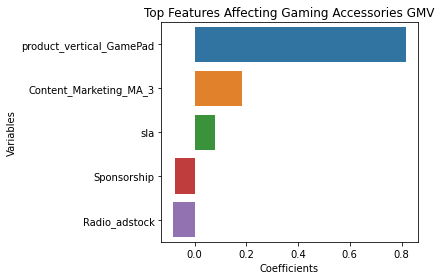

In [653]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (6,4)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title('Top Features Affecting Gaming Accessories GMV')
plt.tight_layout()
plt.show()

### **Home Audio**


***Without Feature Selection***


In [654]:
lr_homeaudio_lagmult = LinearRegression().fit(X_train_homeaudio_lagmult,y_train_homeaudio_lagmult)

In [655]:
y_test_pred_homeaudio_lagmult = lr_homeaudio_lagmult.predict(X_test_homeaudio_lagmult)

In [656]:
print('R2 Score: ',r2_score(y_test_homeaudio_lagmult, y_test_pred_homeaudio_lagmult))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio_lagmult, y_test_pred_homeaudio_lagmult))

R2 Score:  0.9377760488377953
Mean Squared Error:  0.17047595685564806


**Trying Cross Validation on our Dataset**


In [657]:
y_homeaudio_lagmult = homeaudio_data_lagmult.pop('gmv')
X_homeaudio_lagmult = homeaudio_data_lagmult

In [658]:
homeaudio_lagmult_model_cv = LinearRegression().fit(X_homeaudio_lagmult, y_homeaudio_lagmult)

In [659]:
homeaudio_lagmult_predictions_cv = cross_val_predict(homeaudio_lagmult_model_cv, X_homeaudio_lagmult, y_homeaudio_lagmult,cv=10)

In [660]:
r_squared = metrics.r2_score(y_homeaudio_lagmult, homeaudio_lagmult_predictions_cv)

In [661]:
print("Cross-Predicted R-squared:", r_squared)

Cross-Predicted R-squared: 0.970219643062616


***With Feature Selection***


**Using RFE**


In [662]:
lr_homeaudio_lagmult_rfe = LinearRegression()

In [663]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_homeaudio_lagmult_rfe, 15)   #RFE selects 15 most important features for us
rfe = rfe.fit(X_train_homeaudio_lagmult, y_train_homeaudio_lagmult)

In [664]:
list(zip(X_train_homeaudio_lagmult.columns, rfe.support_, rfe.ranking_))

[('gmv_Lag_3', False, 32),
 ('gmv_Lag_2', False, 38),
 ('gmv_Lag_1', False, 6),
 ('sla', True, 1),
 ('product_procurement_sla', True, 1),
 ('list_price', False, 24),
 ('list_price_MA_5', False, 33),
 ('list_price_MA_3', False, 42),
 ('discount', True, 1),
 ('discount_MA_5', False, 39),
 ('discount_MA_3', False, 10),
 ('Pay_day', False, 30),
 ('is_special_saleday_holiday', False, 9),
 ('is_cod', False, 12),
 ('is_premium', True, 1),
 ('product_vertical_Dock', False, 3),
 ('product_vertical_DockingStation', False, 31),
 ('product_vertical_FMRadio', True, 1),
 ('product_vertical_HiFiSystem', False, 44),
 ('product_vertical_HomeAudioSpeaker', True, 1),
 ('product_vertical_VoiceRecorder', True, 1),
 ('max_temp_c', False, 16),
 ('min_temp_c', True, 1),
 ('mean_temp_c', True, 1),
 ('heat_deg_days_c', False, 13),
 ('cool_deg_days_c', False, 27),
 ('total_rain_mm', False, 14),
 ('total_snow_cm', False, 2),
 ('total_precip_mm', False, 47),
 ('snow_on_grnd_cm', False, 56),
 ('NPS', False, 11),
 (

In [665]:
col = X_train_homeaudio_lagmult.columns[rfe.support_]

In [666]:
X_train_homeaudio_lagmult.columns[~rfe.support_]

Index(['gmv_Lag_3', 'gmv_Lag_2', 'gmv_Lag_1', 'list_price', 'list_price_MA_5',
       'list_price_MA_3', 'discount_MA_5', 'discount_MA_3', 'Pay_day',
       'is_special_saleday_holiday', 'is_cod', 'product_vertical_Dock',
       'product_vertical_DockingStation', 'product_vertical_HiFiSystem',
       'max_temp_c', 'heat_deg_days_c', 'cool_deg_days_c', 'total_rain_mm',
       'total_snow_cm', 'total_precip_mm', 'snow_on_grnd_cm', 'NPS',
       'NPS_MA_3', 'Stock Index', 'Stock Index_MA_5', 'Stock Index_MA_3',
       'Total_Investment', 'Total_Investment_MA_5', 'Total_Investment_MA_3',
       'TV_MA_5', 'TV_MA_3', 'Digital', 'Digital_MA_5', 'Sponsorship',
       'Sponsorship_MA_5', 'Sponsorship_MA_3', 'Content_Marketing',
       'Content_Marketing_MA_3', 'Online_marketing', 'Online_marketing_MA_5',
       'Online_marketing_MA_3', 'Affiliates', 'Affiliates_MA_5',
       'Affiliates_MA_3', 'SEM_MA_5', 'SEM_MA_3', 'Radio', 'Radio_MA_5',
       'Radio_MA_3', 'TV_adstock', 'Digital_adstock', 

In [667]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_lagmult[col]
y = y_train_homeaudio_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     695.1
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.15e-20
Time:                        15:55:08   Log-Likelihood:                 88.080
No. Observations:                  33   AIC:                            -144.2
Df Residuals:                      17   BIC:                            -120.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [668]:
col = col.drop(['product_procurement_sla','min_temp_c','mean_temp_c','TV','Digital_MA_3','Content_Marketing_MA_5','SEM','SEM_adstock'], 1)
col

Index(['sla', 'discount', 'is_premium', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder',
       'NPS_MA_5'],
      dtype='object')

In [669]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_lagmult[col]
y = y_train_homeaudio_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1517.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           3.14e-31
Time:                        15:55:08   Log-Likelihood:                 82.026
No. Observations:                  33   AIC:                            -148.1
Df Residuals:                      25   BIC:                            -136.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [670]:
col = col.drop(['sla'], 1)
col

Index(['discount', 'is_premium', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder',
       'NPS_MA_5'],
      dtype='object')

In [671]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_lagmult[col]
y = y_train_homeaudio_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1579.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.06e-32
Time:                        15:55:09   Log-Likelihood:                 79.505
No. Observations:                  33   AIC:                            -145.0
Df Residuals:                      26   BIC:                            -134.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [672]:
col = col.drop(['NPS_MA_5'], 1)
col

Index(['discount', 'is_premium', 'product_vertical_FMRadio',
       'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder'],
      dtype='object')

In [673]:
import statsmodels.api as sm
from scipy import stats

X = X_train_homeaudio_lagmult[col]
y = y_train_homeaudio_lagmult

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     1704.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           7.43e-33
Time:                        15:55:09   Log-Likelihood:                 77.142
No. Observations:                  33   AIC:                            -142.3
Df Residuals:                      27   BIC:                            -133.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [674]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_homeaudio_lagmult[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_homeaudio_lagmult[col].values, i) for i in range(X_train_homeaudio_lagmult[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,is_premium,9.49
3,product_vertical_HomeAudioSpeaker,7.37
2,product_vertical_FMRadio,2.57
0,discount,1.57
4,product_vertical_VoiceRecorder,1.41


Using these 5 variables to test our model as the VIF's are still acceptable

In [675]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr_homeaudio_lagmult_rfe = LinearRegression()
lr_homeaudio_lagmult_rfe.fit(X_train_homeaudio_lagmult[col], y_train_homeaudio_lagmult)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [676]:
y_pred_rf_homeaudio_lagmult = lr_homeaudio_lagmult_rfe.predict(X_test_homeaudio_lagmult[col])

In [677]:
print('R2 Score: ',r2_score(y_test_homeaudio_lagmult, y_pred_rf_homeaudio_lagmult))
print('Mean Squared Error: ',mean_squared_error(y_test_homeaudio_lagmult, y_pred_rf_homeaudio_lagmult))

R2 Score:  0.9988864275800168
Mean Squared Error:  0.003050872216870912


In [678]:
# Getting the coefficients and interecept of the regression with all feature variables
print(lr_homeaudio_lagmult_rfe.coef_, lr_homeaudio_lagmult_rfe.intercept_)

[-0.06169819  0.26814522  0.21218704  0.50402282  0.0295579 ] -0.0023532174807691375


In [679]:
# intercept
intercept_df = pd.DataFrame(lr_homeaudio_lagmult_rfe.intercept_.reshape((1,1)), columns = ['intercept'])

In [680]:
# Coefficients 
coefficients = lr_homeaudio_lagmult_rfe.coef_.reshape((5, 1)).tolist()
coefficients = [val for sublist in coefficients for val in sublist]
coefficients = [round(coefficient, 3) for coefficient in coefficients]

linear_features = list(X_test_homeaudio_lagmult[col].columns)

coefficients_df = list(zip(linear_features, coefficients))

In [681]:
# Coefficients Dataframe
coefficients_df = pd.DataFrame(coefficients_df, columns=["Variables", "Coefficients"])
coefficients_df = coefficients_df.sort_values(by= ['Coefficients'], ascending=False)
coefficients_df

,Variables,Coefficients
3,product_vertical_HomeAudioSpeaker,0.504
1,is_premium,0.268
2,product_vertical_FMRadio,0.212
4,product_vertical_VoiceRecorder,0.030
0,discount,-0.062


**TOP VARIABLES AFFECTING GMV OF HOME AUDIO**


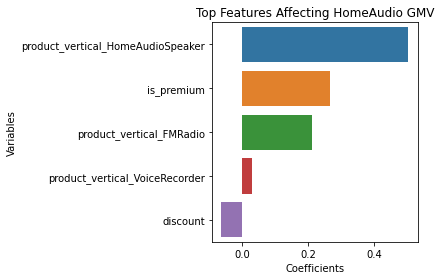

In [682]:
# Importance of Variables Plot
plt.rcParams["figure.figsize"] = (6,4)
sns.barplot(y='Variables',x='Coefficients',data = coefficients_df, estimator=np.sum)
plt.title('Top Features Affecting HomeAudio GMV')
plt.tight_layout()
plt.show()

**CHOOSING THE BEST MODEL**

***Going by the values of R-squared values, we have come to the conclusion that Linear Multiplicative Model provides the best results for all three product sub-categories. The second best model should be the Distributive Lag Multiplicative Model. This ensures the fact that there is an 'interaction effect' amongst the feature variables. We will now check the assumptions of linear regression for these two particular models and talk about the variables that appear significant and important from the analysis.***

***i) For Camera Accessories, the best performing model provides a R-squared of 0.96 and the second best model has around 0.92.***

***ii) For Gaming Accessories, the best performing model provides a R-squared of 0.99 and the second best model has around 0.96.***

***iii)For Home Audio, the best performing model provides a R-squared of 0.99 and the second best model has almost the same value.***

**We have done outlier treatment for our data, so we have taken the models without cross validation as most of them gave better scores than the cross validation ones and even if cross validation provided a better R-squared in some cases, the difference was negligible.**

## **VARIABLE IMPORTANCE**

*** We have chosen only those variables which came out significant after successive droppings of variables using p-values and VIF. So the different number of variables in each case is nothing but because of the variables which came as significant differed in all cases***

## ***Equation of the best fitted line***

## **MULTIPLICATIVE MODEL**

## ***CAMERA ACCESSORIES***

***GMV = -0.028 + 0.726 product_vertical_Lens + 0.344 product_vertical_CameraTripod - 0.051 Sponsorship***

Lens and Camera Tripods have a positive effect on the GMV of camera accessories while an increase in sponsorship leads to a decline in GMV

## ***GAMING ACCESSORIES***

***GMV = -0.014 + 0.647 product_vertical_GamePad + 0.371 product_vertical_GamingHeadset + 0.12 list_price***
Gamepad and Gaming Headset and list price have a positive relation with GMV

## ***HOME AUDIO***

***GMV = -0.016 + 0.429 product_vertical_FMRadio + 0.416 is_premium + 0.139 Total_Investment + 0.085 is_cod + 0.075 Digital_MA_3 + 0.056 Content_Marketing_MA_5 + 0.054 SEM + 0.043 product_vertical_DockingStation - 0.083 product_procurement_sla - 0.117 Sponsorship - 0.142 SEM_MA_5***   

##**DISTRIBUTIVE LAG MULTIPLICATIVE MODEL**

## ***CAMERA ACCESSORIES***

***GMV = 0.06 + 0.396 product_vertical_CameraTripod + 0.269 product_vertical_Telescope + 0.214 is_cod + 0.144 TV_MA_3 + 0.07 Radio - 0.112 Sponsorship - 0.127 sla***  

## ***GAMING ACCESSORIES***

***GMV = -0.004 + 0.817 product_vertical_GamePad + 0.182 Content_Marketing_MA_3 + 0.079 sla - 0.076 Sponsorship - 0.083 Radio_adstock*** 

## ***HOME AUDIO***

***GMV = -0.002 + 0.504 product_vertical_HomeAudioSpeaker + 0.268 is_premium + 0.212 product_vertical_FMRadio + 0.03 product_vertical_VoiceRecorder - 0.062 discount***

## **CHECKING THE ASSUMPTIONS OF LINEAR REGRESSION**

## ****MULTIPLICATIVE MODEL****

**Plotting y and y-pred**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'y_pred')

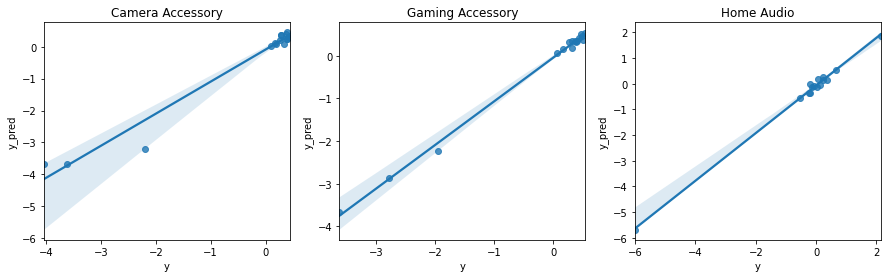

In [683]:
# Plotting y and y_pred to understand the spread
plt.figure(figsize=(15, 4))

#Camera
plt.subplot(1,3,1)
sns.regplot(y_test_camera_mult, y_pred_rf_camera_mult)
fig.suptitle('y vs y_pred', fontsize = 14)
plt.title('Camera Accessory')         
plt.xlabel('y', fontsize = 10)                          
plt.ylabel('y_pred', fontsize = 10)  


#Gaming
plt.subplot(1,3,2)
sns.regplot(y_test_gaming_mult, y_pred_rf_gaming_mult)
fig.suptitle('y vs y_pred', fontsize = 14)
plt.title('Gaming Accessory')         
plt.xlabel('y', fontsize = 10)                          
plt.ylabel('y_pred', fontsize = 10)

#Home Audio
plt.subplot(1,3,3)
sns.regplot(y_test_homeaudio_mult, y_pred_rf_homeaudio_mult)
fig.suptitle('y vs y_pred', fontsize = 14)
plt.title('Home Audio')         
plt.xlabel('y', fontsize = 10)                          
plt.ylabel('y_pred', fontsize = 10)

**Residuals Plot**

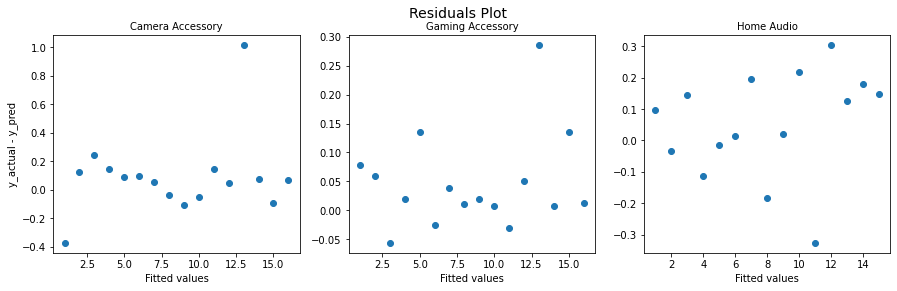

In [684]:
plt.figure(figsize=(15, 4))

# Camera
plt.subplot(1, 3, 1)
# Error terms
diff_cam = y_test_camera_mult.values-y_pred_rf_camera_mult
d_1 = [i for i in range(1,17,1)]
plt.scatter(d_1,diff_cam)
plt.suptitle('Residuals Plot', fontsize=14)              
plt.title('Camera Accessory', fontsize=10)              
plt.xlabel('Fitted values', fontsize=10)                      
plt.ylabel('y_actual - y_pred', fontsize=10)                

# Gaming
plt.subplot(1, 3, 2)
# Error terms
diff_gam = y_test_gaming_mult.values-y_pred_rf_gaming_mult
d_2 = [i for i in range(1,17,1)]
plt.scatter(d_2,diff_gam)
plt.title('Gaming Accessory', fontsize=10)               
plt.xlabel('Fitted values', fontsize=10)                      

# Home Audio
plt.subplot(1, 3, 3)
# Error terms
diff_ha = y_test_homeaudio_mult.values-y_pred_rf_homeaudio_mult
d_3 = [i for i in range(1,16,1)]
plt.scatter(d_3,diff_ha)
plt.title('Home Audio', fontsize=10)              
plt.xlabel('Fitted values', fontsize=10)                      


plt.show()

**Checking Normality**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

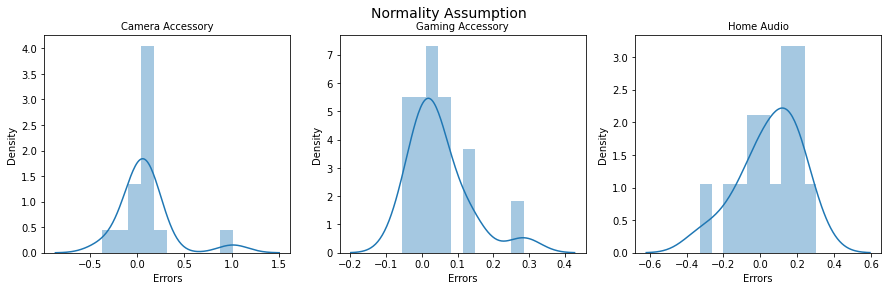

In [685]:
plt.figure(figsize=(15, 4))

# Camera
plt.subplot(1, 3, 1)
# Error terms
diff_cam = y_test_camera_mult.values-y_pred_rf_camera_mult

sns.distplot(diff_cam, bins = 10)
plt.suptitle('Normality Assumption', fontsize=14)              
plt.title('Camera Accessory', fontsize=10)              
plt.xlabel('Errors', fontsize=10)                      
                

# Gaming
plt.subplot(1, 3, 2)
# Error terms
diff_gam = y_test_gaming_mult.values-y_pred_rf_gaming_mult

sns.distplot(diff_gam, bins = 10)
plt.title('Gaming Accessory', fontsize=10)               
plt.xlabel('Errors', fontsize=10)                      

# Home Audio
plt.subplot(1, 3, 3)
# Error terms
diff_ha = y_test_homeaudio_mult.values-y_pred_rf_homeaudio_mult

sns.distplot(diff_ha, bins = 10)
plt.title('Home Audio', fontsize=10)              
plt.xlabel('Errors', fontsize=10)                      


plt.show()

## ****DISTRIBUTIVE LAG MULTIPLICATIVE MODEL****

**Plotting y and y-pred**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'y_pred')

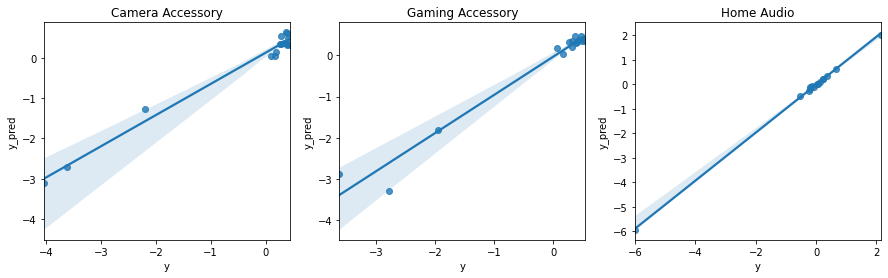

In [686]:
# Plotting y and y_pred to understand the spread
plt.figure(figsize=(15, 4))

#Camera
plt.subplot(1,3,1)
sns.regplot(y_test_camera_lagmult, y_pred_rf_camera_lagmult)
fig.suptitle('y vs y_pred', fontsize = 14)
plt.title('Camera Accessory')         
plt.xlabel('y', fontsize = 10)                          
plt.ylabel('y_pred', fontsize = 10)  


#Gaming
plt.subplot(1,3,2)
sns.regplot(y_test_gaming_lagmult, y_pred_rf_gaming_lagmult)
fig.suptitle('y vs y_pred', fontsize = 14)
plt.title('Gaming Accessory')         
plt.xlabel('y', fontsize = 10)                          
plt.ylabel('y_pred', fontsize = 10)

#Home Audio
plt.subplot(1,3,3)
sns.regplot(y_test_homeaudio_lagmult, y_pred_rf_homeaudio_lagmult)
fig.suptitle('y vs y_pred', fontsize = 14)
plt.title('Home Audio')         
plt.xlabel('y', fontsize = 10)                          
plt.ylabel('y_pred', fontsize = 10)

**Residuals Plot**

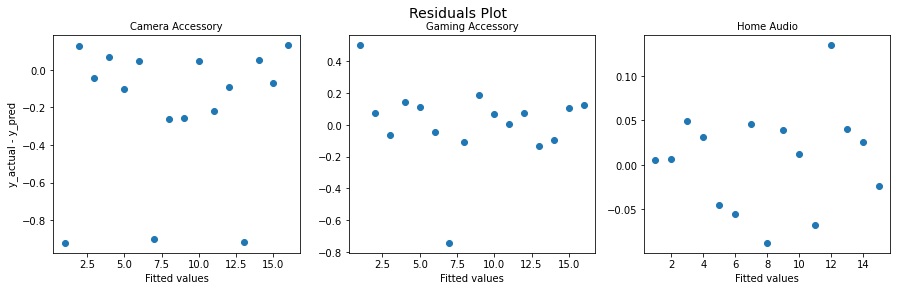

In [687]:
plt.figure(figsize=(15, 4))

# Camera
plt.subplot(1, 3, 1)
# Error terms
diff_cam = y_test_camera_lagmult.values-y_pred_rf_camera_lagmult
d_1 = [i for i in range(1,17,1)]
plt.scatter(d_1,diff_cam)
plt.suptitle('Residuals Plot', fontsize=14)              
plt.title('Camera Accessory', fontsize=10)              
plt.xlabel('Fitted values', fontsize=10)                      
plt.ylabel('y_actual - y_pred', fontsize=10)                

# Gaming
plt.subplot(1, 3, 2)
# Error terms
diff_gam = y_test_gaming_lagmult.values-y_pred_rf_gaming_lagmult
d_2 = [i for i in range(1,17,1)]
plt.scatter(d_2,diff_gam)
plt.title('Gaming Accessory', fontsize=10)               
plt.xlabel('Fitted values', fontsize=10)                      

# Home Audio
plt.subplot(1, 3, 3)
# Error terms
diff_ha = y_test_homeaudio_lagmult.values-y_pred_rf_homeaudio_lagmult
d_3 = [i for i in range(1,16,1)]
plt.scatter(d_3,diff_ha)
plt.title('Home Audio', fontsize=10)              
plt.xlabel('Fitted values', fontsize=10)                      


plt.show()

**Checking Normality**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

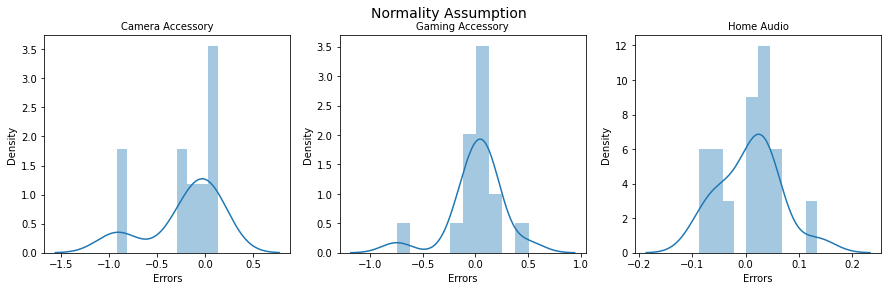

In [688]:
plt.figure(figsize=(15, 4))

# Camera
plt.subplot(1, 3, 1)
# Error terms
diff_cam = y_test_camera_lagmult.values-y_pred_rf_camera_lagmult

sns.distplot(diff_cam, bins = 10)
plt.suptitle('Normality Assumption', fontsize=14)              
plt.title('Camera Accessory', fontsize=10)              
plt.xlabel('Errors', fontsize=10)                      
                

# Gaming
plt.subplot(1, 3, 2)
# Error terms
diff_gam = y_test_gaming_lagmult.values-y_pred_rf_gaming_lagmult

sns.distplot(diff_gam, bins = 10)
plt.title('Gaming Accessory', fontsize=10)               
plt.xlabel('Errors', fontsize=10)                      

# Home Audio
plt.subplot(1, 3, 3)
# Error terms
diff_ha = y_test_homeaudio_lagmult.values-y_pred_rf_homeaudio_lagmult

sns.distplot(diff_ha, bins = 10)
plt.title('Home Audio', fontsize=10)              
plt.xlabel('Errors', fontsize=10)                      


plt.show()

### **Homoskedasticity and Normality assumptions are satisfied for both the models**

# **CONCLUSION & SUGGESTIONS**

Combining the results of the multiplicative models, we can come to this conclusion:

***Camera Accessories***

i) ***Lens***, ***Camera Tripod*** and ***Telescope*** are the ***highest*** revenue-generating verticals

ii) ***Cash-on-Delivery*** has a ***positive*** impact on the gmv

iii) Advertisements on ***TV*** and ***Radio*** have ***positive*** effect on revenue but ***Sponsorship*** has a ***negative*** impact

iv) The ***more*** the time taken to deliver a product, the more the revenue is ***affected***


***Gaming Accessories***

i) ***GamePad*** and ***Gaming Headset*** are the ***biggest** revenue-generating products


ii) Higher ***list price*** has a positive relation with gmv which is not so surprising due to the fact that gaming accessories are mostly bought by the younger generation who has this innate nature to ***perceive a higher priced product as a better product***

iii) Money spent on ***Content Marketing*** has a ***positive*** effect on the revenue but ***sponsorship*** spends as well as ***radio adstock*** contribute ***negatively***, which signifies the fact that content is a key factor for impacting the young minds while they are not so much interested about the sponsorships and hardly listen to the radio


***Home Audio***

i) ***FM Radio***, ***Home Audio Speaker*** and ***Voice Recorder*** generate the highest revenues

ii) 5 weeks average of ***Total Investment*** has a ***positive*** impact on revenues i.e. investment should be done for a ***consistent period of time to reap the benefits***

iii) ***Cash-on-Delivery*** has a ***positive*** impact on the gmv

iv) 3 weeks average of ***Digital media*** and 5 weeks average of ***Content Marketing*** spends impact revenue ***positively***, so the point to note again is that ***advertisement and marketing spends in home audio should be carried on for a good amount of time*** 

v) The ***more*** the time taken to deliver a product, the more the revenue is ***affected***

vi) Spends on ***Sponsorship*** and ***Search Engine Marketing*** have an ***adverse effect*** on the revenue

